# Import libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import plotly.graph_objs as go
from IPython.display import HTML, display
from plotly.subplots import make_subplots
from plotly import express as px
import plotly.figure_factory as ff
from copy import deepcopy
from collections import defaultdict

from math import log
from scipy.stats import chi2, chi2_contingency, ks_2samp, gaussian_kde
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, label_binarize
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from umap import UMAP
from sklearn.manifold import TSNE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTENC

import sklearn
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import *
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from inspect import signature
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
import shap
from tqdm import tqdm

# import warnings
# warnings.filterwarnings("ignore")

# !pip install "kaleido==0.1.0.post1"

SEED = 17
PROBLEM_TYPE = "classification"
compare_metric_name = "Accuracy"
CV = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=SEED)
N_TRIALS = 100
METRICS_NAMES: dict[str, callable] = {
    "Accuracy": accuracy_score,
    "Balanced Accuracy": balanced_accuracy_score,
    "F1": f1_score,
    "F1 (Micro)": lambda y_true, y_pred: f1_score(y_true, y_pred, average="micro"),
    "F1 (Macro)": lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro"),
    "F1 (Weighted)": lambda y_true, y_pred: f1_score(y_true, y_pred, average="weighted"),
    "Recall": recall_score,
    "Precision": precision_score,
    "Roc AUC": roc_auc_score,
    "MAE": mean_absolute_error,
    "MAPE": mean_absolute_percentage_error,
    "MSE": mean_squared_error,
    "RMSE": root_mean_squared_error,
    "RMSLE": root_mean_squared_log_error,
    "R2": r2_score,
}

METRICS = {
    key: [
        eval_func,
        "preds" if key not in ["Roc AUC", "Mean Average Precision"] else "probs",
        "minimize" if key in ["MAE", "MAPE", "MSE", "RMSE", "RMSLE"] else "maximize"
    ]
    for key, eval_func in METRICS_NAMES.items()
}

# Utility functions

In [2]:
def base_information(data):
    df = pd.DataFrame(data.dtypes, columns=['dtypes'])
    df['Number of missing values'] = data.isna().sum()
    df['Percentage of missing values'] = data.isna().sum() / data.shape[0] * 100
    df['Unique values'] = data.nunique().values
    df['Count'] = data.count().values
    df = df.reset_index().rename(columns={'index': 'Column'})
    styled_df = (
        df
        .style
        .set_caption("📝 Base Information")
        .format({
            'Number of missing values': '{:,.0f}',
            'Percentage of missing values': '{:.2f}%',
            'Unique values': '{:,.0f}',
            'Count': '{:,.0f}'
        })
        .bar(subset=['Percentage of missing values'], color='#4a90e2', vmin=0, vmax=100)
        .set_properties(**{
            'text-align': 'left',
            'font-family': 'Times New Roman',
            'font-size': '1.25em',  # Increased font size for cell content
            'background-color':  '#f9f9f9',
            'border': '1px solid #ddd',
            'color': '#333'
        })
        .set_table_styles([{'selector': 'th','props': [('font-weight', 'bold'), ('border', '1px solid #ddd')]}])
    )
    return styled_df

def initial_columns_removal(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove features that are not useful for the model:
        - 1 unique value (variance = 0)
        - all missing values
        - duplicated columns
    
    Args:
        df (pd.DataFrame): DataFrame to be cleaned.
    
    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    number_of_columns_before = df.shape[1]

    # Remove columns with only 1 unique value (if there are no nulls)
    nunique_mask = df.nunique(dropna=False) > 1
    single_unique_cols = df.columns[~nunique_mask].tolist()
    if single_unique_cols:
        print(f"Removed columns with only 1 unique value: {single_unique_cols}")
    df = df.loc[:, nunique_mask]

    # Remove columns with all missing values
    na_mask = ~df.isna().all()
    all_na_cols = df.columns[~na_mask].tolist()
    if all_na_cols:
        print(f"Removed columns with all missing values: {all_na_cols}")
    df = df.loc[:, na_mask]

    # Remove duplicated columns
    cols = list(df.columns)
    to_drop = set()
    for i in range(len(cols)):
        col1 = cols[i]
        if col1 in to_drop:
            continue
        for j in range(i + 1, len(cols)):
            col2 = cols[j]
            if col2 in to_drop:
                continue
            if df[col1].equals(df[col2]):
                print(f"Columns {col1} and {col2} are identical. Removing the column: {col2}")
                to_drop.add(col2)
    if to_drop:
        df = df.drop(columns=list(to_drop))

    print(f"\nNumber of columns after removal: {df.shape[1]}. Removed {number_of_columns_before - df.shape[1]} columns.")
    return df.reset_index(drop=True)

def get_categorical_columns(df: pd.DataFrame) -> list[str]:
    """
    Get categorical columns from the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        list[str]: List of categorical columns.
    """
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    categorical_columns = [col for col in categorical_columns if df[col].nunique() < 100]
    categorical_columns = list(set(categorical_columns) | set(df.columns[df.nunique() == 2]))
    return categorical_columns

def drop_highly_skewed_categorical_columns(df, columns_to_investigate, threshold=0.99) -> pd.DataFrame:
    """
    Drop categorical columns where one value accounts for more than the specified threshold of the data.

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns_to_investigate (list): List of categorical columns to investigate.
        threshold (float): The threshold for skewness in the distribution.

    Returns:
        pd.DataFrame: The DataFrame with highly skewed categorical columns dropped.
    """
    df = df.copy()
    cols_to_drop = []
    print(f"Highly skewed categorical columns with a distribution where one value is more than {threshold*100:.2f}% of the data:\n")
    for column in columns_to_investigate:
        value_counts = df[column].value_counts(normalize=True, dropna=False)
        if value_counts.max() > threshold:
            print(f"  - {column} (value '{value_counts.idxmax()}' with {value_counts.max()*100:.2f}% of the data)")
            cols_to_drop.append(column)
    df = df.drop(columns=cols_to_drop)
    print(f"\nNumber of columns after removal: {df.shape[1]}. Removed {len(cols_to_drop)} columns.")
    return df

def categorize_categorical_columns_by_missing(data: pd.DataFrame, categorical_columns: list[str]) -> dict[str, list[str]]:
    """
    Categorize categorical columns in the DataFrame by their proportion of missing values.

    Args:
        data (pd.DataFrame): The input DataFrame.
        categorical_columns (list[str]): List of categorical columns.

    Returns:
        dict[str, list[str]]: Dictionary with keys as types of categorical columns and values as lists of column names.
    """
    categorical_not_many_missing_columns = [col for col in categorical_columns if 0 < data[col].isnull().mean() <= 0.1]
    categorical_many_missing_columns = [col for col in categorical_columns if data[col].isnull().mean() > 0.1]
    categorical_missing_columns = [col for col in categorical_columns if data[col].isnull().mean() > 0.0]
    non_missing_categorical_columns = [col for col in categorical_columns if data[col].isnull().mean() == 0.0]
    return  {
        "categorical_not_many_missing_columns": categorical_not_many_missing_columns,
        "categorical_many_missing_columns": categorical_many_missing_columns,
        "categorical_missing_columns": categorical_missing_columns,
        "non_missing_categorical_columns": non_missing_categorical_columns
    }

def describe_numerical_feature(data, feature):
    """
    Enhanced numerical feature analysis with styling for clear Copilot sharing.

    Args:
        data (pd.DataFrame): The input DataFrame.
        feature (str): The numerical feature to analyze.

    Returns:
        pd.DataFrame: A styled DataFrame summarizing the feature's statistics.
    """
    stats = data[feature].describe().T
    stats["5%"] = data[feature].quantile(0.05)
    stats["95%"] = data[feature].quantile(0.95)
    stats['variance'] = data[feature].var()
    stats['skewness'] = data[feature].skew()
    stats['kurtosis'] = data[feature].kurtosis()
    missing_count = data[feature].isna().sum()
    missing_pct = missing_count / len(data) * 100
    stats['missing_count'] = missing_count
    stats['missing_pct'] = missing_pct
    stats = stats.rename({
        "count": "Count",
        "mean": "Mean",
        "std": "Std",
        "min": "Min",
        "25%": "Q1",
        "50%": "Median",
        "75%": "Q3",
        "max": "Max"
    })
    stats = stats[["Count", "Mean", "Std", "Min", "5%", "Q1", "Median", "Q3", "95%", "Max", "variance", "skewness", "kurtosis", "missing_count", "missing_pct"]]
    stats_df = stats.to_frame().T

    styled_stats = (
        stats_df
        .style
        .set_caption(f"📈 {feature} Statistics")
        .format({
            'Count': '{:,.0f}',
            'Mean': '{:,.2f}',
            'Std': '{:,.2f}',
            'Min': '{:,.2f}',
            '5%': '{:,.2f}',
            'Q1': '{:,.2f}',
            'Median': '{:,.2f}',
            'Q3': '{:,.2f}',
            '95%': '{:,.2f}',
            'Max': '{:,.2f}',
            'variance': '{:,.2f}',
            'skewness': '{:,.2f}',
            'kurtosis': '{:,.2f}',
            'missing_count': '{:,.0f}',
            'missing_pct': '{:.2f}%'
        })
        .set_properties(**{
            'text-align': 'left',
            'font-family': 'Times New Roman',
            'font-size': '1.25em',  # Increased font size for cell content
            'background-color':  '#f9f9f9',
            'border': '1px solid #ddd',
            'color': '#333'
        })
        .set_table_styles([{'selector': 'th','props': [('font-weight', 'bold'),('border', '1px solid #ddd')]}])
    )
    return styled_stats

def describe_categorical_feature(data: pd.DataFrame, feature: str, top_n: int = 15) -> pd.DataFrame:
    """
    Enhanced categorical feature analysis with styling for clear Copilot sharing.

    Args:
        data (pd.DataFrame): The input DataFrame.
        feature (str): The categorical feature to analyze.
        top_n (int): The number of top categories to display.
    
    Returns:
        pd.DataFrame: A styled DataFrame summarizing the feature's distribution.
    """
    data_copy = data.copy()
    counts = data_copy[feature].value_counts()
    total = len(data_copy)
    if len(counts) > top_n:
        top_counts = counts[:top_n]
        other_count = counts[top_n:].sum()
        counts = pd.concat([top_counts, pd.Series({'Other': other_count})])

    percentages = (counts / total * 100).round(2)
    missing_count = data_copy[feature].isna().sum()
    missing_pct = (missing_count / total * 100).round(2)

    # Only add the 'Missing' row if there are actually missing values
    if missing_count > 0:
        stats = pd.DataFrame({
            'Category': counts.index.tolist() + ['Missing'],
            'Count': counts.values.tolist() + [missing_count],
            'Percentage (%)': percentages.values.tolist() + [missing_pct]
        })
    else:
        stats = pd.DataFrame({
            'Category': counts.index.tolist(),
            'Count': counts.values.tolist(),
            'Percentage (%)': percentages.values.tolist()
        })

    styled_stats = (
        stats
        .style
        .set_caption(f"📊 {feature} Distribution")
        .format({'Count': '{:,.0f}', 'Percentage (%)': '{:.2f}%'})
        .bar(subset=['Percentage (%)'], color='#4a90e2', vmin=0, vmax=100)
        .set_properties(**{
            'text-align': 'left',
            'font-family': 'Times New Roman',
            'font-size': '1.25em',  # Increased font size for cell content
            'background-color':  '#f9f9f9',
            'border': '1px solid #ddd',
            'color': '#333'
        })
        .set_table_styles([{'selector': 'th','props': [('font-weight', 'bold'),('border', '1px solid #ddd')]}])
    )
    return styled_stats

def describe_time_series_feature(data, feature):
    data_copy = data.copy()
    data_copy.reset_index(drop=True, inplace=True)
    data_copy[feature] = pd.to_datetime(data_copy[feature])
    year_counts = data_copy[feature].dt.year.value_counts().sort_index()
    year_df = pd.DataFrame({'Year': year_counts.index, 'Count': year_counts.values})
    year_df['missing_count'] = data_copy[feature].isna().sum()
    year_df['missing_pct'] = data_copy[feature].isna().sum() / len(data_copy) * 100

    month_counts = data_copy[feature].dt.month.value_counts().sort_index()
    month_df = pd.DataFrame({'Month': month_counts.index, 'Count': month_counts.values})
    month_df['missing_count'] = data_copy[feature].isna().sum()
    month_df['missing_pct'] = data_copy[feature].isna().sum() / len(data_copy) * 100

    day_counts = data_copy[feature].dt.day.value_counts().sort_index()
    day_df = pd.DataFrame({'Day': day_counts.index, 'Count': day_counts.values})
    day_df['missing_count'] = data_copy[feature].isna().sum()
    day_df['missing_pct'] = data_copy[feature].isna().sum() / len(data_copy) * 100

    print("Year Distribution")
    display(year_df.style.background_gradient(cmap='Blues').format({"Count": "{:.0f}", "missing_count": "{:.0f}", "missing_pct": "{:.2f}"}))
    print("Month Distribution")
    display(month_df.style.background_gradient(cmap='Blues').format({"Count": "{:.0f}", "missing_count": "{:.0f}", "missing_pct": "{:.2f}"}))
    print("Day Distribution")
    display(day_df.style.background_gradient(cmap='Blues').format({"Count": "{:.0f}", "missing_count": "{:.0f}", "missing_pct": "{:.2f}"}))

In [3]:
def compute_shap_values(
    model: object,
    X: pd.DataFrame,
    feature_names: list[str],
):
    """
    Compute SHAP values for a model or ensemble.

    Args:
        model (object): Trained model or ensemble of models.
        X (pd.DataFrame): Input data for which to compute SHAP values.
        feature_names (list[str]): Names of the features in X.

    Returns:
        shap.Explanation object with SHAP values for X.
    """
    X_temp = X.copy()
    is_ensemble = hasattr(model, 'estimators') and model.estimators is not None

    if not is_ensemble:
        if model.__class__.__name__.startswith("HistGradientBoosting"):
            for col in X_temp.select_dtypes(include="category").columns:
                X_temp[col] = X_temp[col].cat.codes
        explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
        shap_values = explainer(X_temp)
        return shap_values
    
    # Handle ensemble models
    shap_values_list = []
    for estimator in model.estimators:
        if estimator.__class__.__name__.startswith("HistGradientBoosting"):
            for col in X_temp.select_dtypes(include="category").columns:
                X_temp[col] = X_temp[col].cat.codes
        explainer = shap.TreeExplainer(estimator, feature_perturbation="tree_path_dependent")
        shap_values_list.append(explainer(X_temp))
    
    shap_values_sum = sum(w * sv.values for w, sv in zip(model.weights, shap_values_list))
    base_values = np.average([sv.base_values for sv in shap_values_list], axis=0, weights=model.weights)
    return shap.Explanation(
        values=shap_values_sum,
        base_values=base_values,
        data=X.values,
        feature_names=feature_names
    )

def fit_algorithm(algorithm: BaseEstimator, X_train: pd.DataFrame, y_train: pd.Series, X_valid: pd.DataFrame = None, y_valid: pd.Series = None) -> BaseEstimator:
    """
    Fit the algorithm with training and validation data.
    
    Args:
        algorithm (BaseEstimator): Algorithm to setup.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        X_valid (pd.DataFrame, optional): Validation features. Defaults to None.
        y_valid (pd.Series, optional): Validation target. Defaults to None.
    
    Returns:
        BaseEstimator: Fitted algorithm.
    """
    sig = signature(algorithm.fit)
    fit_params = {}
    if "eval_set" in sig.parameters:
        fit_params["eval_set"] = [(X_valid, y_valid)] if X_valid is not None else []
    if "verbose" in sig.parameters:
        fit_params["verbose"] = False
    if "X_val" and "y_val" in sig.parameters:
        fit_params["X_val"] = X_valid
        fit_params["y_val"] = y_valid
    if "X_test" in sig.parameters:
        fit_params["X_test"] = X_valid
    # if "sample_weight" in sig.parameters:
    #     fit_params["sample_weight"] = compute_sample_weight(class_weight="balanced", y=y_train)
    algorithm.fit(X_train, y_train, **fit_params)
    return algorithm

def fit_and_predict(algorithm: BaseEstimator, X_train: pd.DataFrame, y_train: pd.Series, X_valid: pd.DataFrame, y_valid: pd.Series, metric_type: str = "preds") -> tuple[np.ndarray, np.ndarray]:
    """
    Fit the algorithm on training data and predict on test data.
    
    Args:
        algorithm (BaseEstimator): Algorithm to fit and predict.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        X_valid (pd.DataFrame): Validation features.
        y_valid (pd.Series, optional): Validation target.
        metric_type (str, optional): Type of metric to use for prediction. Defaults to "preds".
    
    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple of predicted values for training and validation sets.
    """
    sig = signature(algorithm.fit)
    fit_params = {}
    if "eval_set" in sig.parameters:
        fit_params["eval_set"] = [(X_valid, y_valid)]
    if "verbose" in sig.parameters:
        fit_params["verbose"] = False
    if "X_val" and "y_val" in sig.parameters:
        fit_params["X_val"] = X_valid
        fit_params["y_val"] = y_valid
    if "X_test" in sig.parameters:
        fit_params["X_test"] = X_valid
    # if "sample_weight" in sig.parameters:
    #     fit_params["sample_weight"] = compute_sample_weight(class_weight="balanced", y=y_train)
    algorithm.fit(X_train, y_train, **fit_params)
    
    if metric_type == "preds":
        y_train_pred = algorithm.predict(X_train)
        y_test_pred = algorithm.predict(X_valid)
    elif metric_type == "probs":
        y_train_pred = algorithm.predict_proba(X_train)
        y_test_pred = algorithm.predict_proba(X_valid)
    else:
        raise ValueError(f"Unknown metric type {metric_type}")
    return y_train_pred, y_test_pred

def postprocess_predictions(y_pred: np.ndarray, min_value: float = 0, max_value: float = None) -> np.ndarray:
    """
    Postprocess predictions to ensure they are within specified bounds.
    
    Args:
        y_pred (np.ndarray): Predicted values.
        min_value (float, optional): Minimum value for predictions. Defaults to 0.
        max_value (float, optional): Maximum value for predictions. Defaults to None.
    
    Returns:
        np.ndarray: Postprocessed predictions.
    """
    if max_value is not None:
        y_pred = np.clip(y_pred, a_min=min_value, a_max=max_value)
    else:
        y_pred = np.clip(y_pred, a_min=min_value)
    return y_pred

def perform_cv(X: pd.DataFrame, y: pd.Series, algorithm: object, cv: sklearn.model_selection = KFold(n_splits=5, shuffle=True, random_state=17), metric_name: str = "RMSE") -> tuple[list[float], list[float]]:
    """
    Perform cross-validation and return list of scores
    
    Args:
        X (pd.DataFrame): input data
        y (pd.Series): target data
        algorithm (Any): algorithm to use for training and prediction
        cv (sklearn.model_selection, default=KFold(n_splits=5, shuffle=True, random_state=17)): cross-validation strategy
        metric_name (str, default="RMSE"): metric name to use for evaluation
    
    Returns:
        tuple[list[float], list[float]]: Tuple of lists of train and validation scores
    """
    if metric_name not in METRICS.keys():
        raise ValueError(f"Metric {metric_name} not found in METRICS dictionary")
    eval_metric = METRICS[metric_name][0]
    metric_type = METRICS[metric_name][1]
    train_scores, validation_scores = [], []
    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        y_train_pred, y_valid_pred = fit_and_predict(algorithm, X_train, y_train, X_valid, y_valid, metric_type)
        train_scores.append(eval_metric(y_train, y_train_pred))
        validation_scores.append(eval_metric(y_valid, y_valid_pred))
    return train_scores, validation_scores

In [4]:
class Plots:
    def __init__(self):
        self.quantiles_dict = {"Min": 0, "Q1": 0.25, "Med": 0.5, "Q3": 0.75, "Max": 1}

    def check_data(self, data):
        if not isinstance(data, pd.DataFrame) and not isinstance(data, pd.Series) and not isinstance(data, np.ndarray):
            raise TypeError('Wrong type of data. It should be pandas DataFrame, pandas Series, numpy array')
        data = np.array(data)
        data = data[~np.isnan(data)]
        if(data.ndim == 2):
            data = data.squeeze()
        return data

    def check_2d_data(self, data):
        if not isinstance(data, pd.DataFrame) and not isinstance(data, pd.Series) and not isinstance(data, np.ndarray):
            raise TypeError('Wrong type of data. It should be pandas DataFrame, pandas Series, numpy array')
        return np.array(data)
    
    def barplot_missing_values(self, data, features_names, name=""):
        data = self.check_data(data=data)
        fig = go.Figure()
        fig.add_trace(go.Bar(
            x=features_names,
            y=data,
            marker=dict(color=data, colorscale='rainbow', line=dict(color='black', width=1)),
            text=data,
            textposition='auto'
        ))
        fig.update_layout(template="simple_white", width=max(30*len(features_names), 1600), height=max(30*len(features_names), 800), title=f"<b>Bar chart {name.title()}<b>", title_x=0.5, yaxis_title="Frequency", xaxis=dict(title="Features", showticklabels=True), font=dict(family="Times New Roman", size=22 ,color="Black"))
        fig.show("png")
    
    def pie_barplot(self, data, feature, plot_title=""):
        data_copy = data[feature].copy()
        data_copy.dropna(inplace=True)
        data_copy.reset_index(drop=True, inplace=True)
        labels, frequency = np.array(data_copy.value_counts().index), np.array(data_copy.value_counts().values)
        n_colors = len(labels)
        if n_colors > 10:
            colors = px.colors.sample_colorscale("rainbow", list(np.linspace(0, 1, n_colors)))
        else:
            colors = px.colors.qualitative.Pastel
        fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
        fig.add_trace(go.Pie(values=frequency, labels=labels, showlegend=False, textinfo='value+percent', hole=0.3, marker=dict(line=dict(color='black', width=2), colors=colors)), row=1, col=1)
        fig.add_trace(go.Bar(x=labels, y=frequency, text=[f"{val:.1f}%" for val in frequency / np.sum(frequency) * 100], textposition='auto', marker=dict(color=colors, line=dict(color='black', width=2)), showlegend=False), row=1, col=2)
        fig.update_yaxes(title_text="Count", row=1, col=2)
        fig.update_xaxes(title_text=feature, row=1, col=2)
        fig.update_layout(barmode='stack', width=1600, height=800, title=f"<b>{plot_title.title()}<b>", template="simple_white", title_x=0.5, font=dict(family="Times New Roman", size=20) , legend=dict(font=dict(size=20), bordercolor="black", borderwidth=1, bgcolor="white", traceorder="normal", x=0.9, y=1.1, orientation="v", itemclick="toggleothers", itemdoubleclick="toggle", tracegroupgap=5))
        fig.show("png")
    
    def boxplot_histogram_boxplot_by_hue(self, data, feature, hue, plot_title="", annotations=True, bin_size=1):
        data_copy = data[[feature, hue]].copy()
        data_copy.dropna(inplace=True)
        data_copy.reset_index(drop=True, inplace=True)
        fig = make_subplots(rows=1, cols=3, specs=[[{"type": "histogram"}, {"type": "box"}, {"type": "box"}]])
        fig.add_trace(go.Box(y=data_copy[feature], name='', marker=dict(color="rgb(48,70,116)"), showlegend=False), row=1, col=1)
        fig.add_trace(go.Histogram(x=data_copy[feature], marker=dict(color="rgb(48,70,116)"), showlegend=False, xbins=dict(size=bin_size)), row=1, col=2)
        fig.update_yaxes(title_text=feature, row=1, col=1)
        fig.update_xaxes(title_text=feature, row=1, col=2)
        fig.update_yaxes(title_text=feature, row=1, col=3)
        fig.update_xaxes(title_text=hue, row=1, col=3)
        if type(annotations) == list:
            for x in annotations:
                fig.add_annotation(x=0.4, y=np.quantile(data_copy[feature], self.quantiles_dict[x]), text=x + ": " + str(np.round(np.quantile(data_copy[feature], self.quantiles_dict[x]), 3)), showarrow=False)
        elif type(annotations) == bool:
            if annotations:
                for key, value in self.quantiles_dict.items():
                    fig.add_annotation(x=0.4, y=np.quantile(data_copy[feature], value), text=key + ": " + str(np.round(np.quantile(data_copy[feature], value), 3)), showarrow=False)
        labels, frequency = np.array(data_copy[hue].value_counts().index), np.array(data_copy[hue].value_counts().values)
        sorted_indices = np.argsort(frequency)[::-1]
        labels = labels[sorted_indices]
        frequency = frequency[sorted_indices]
        n_colors = len(labels)
        if n_colors > 10:
            colors = px.colors.sample_colorscale("rainbow", list(np.linspace(0, 1, n_colors)))
        else:
            colors = px.colors.qualitative.Pastel
        for color_idx, category in enumerate(labels):
            indices = list(np.where(data_copy[hue]==category)[0])
            grouped_data = list(data_copy[feature][indices])
            fig.add_trace(go.Box(y=grouped_data, name=str(category), marker=dict(color=colors[color_idx]), showlegend=False), row=1, col=3)
        fig.update_layout(template="simple_white", width=2000, height=1000, title=f"<b>{plot_title.title()}<b>", title_x=0.5, font=dict(family="Times New Roman",size=22,color="Black"))
        fig.show("png")
    
    def pie_stacked_barplot_by_hue(self, data, feature, hue, plot_title=""):
        data_copy = data[[feature, hue]].copy()
        data_copy.dropna(inplace=True)
        data_copy.reset_index(drop=True, inplace=True)
        crosstab = pd.crosstab(data_copy[hue], data_copy[feature])
        n_colors = len(crosstab.columns)
        if n_colors > 10:
            colors = px.colors.sample_colorscale("rainbow", list(np.linspace(0, 1, n_colors)))
        else:
            colors = px.colors.qualitative.Pastel
        fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
        labels, frequency = np.array(data_copy[feature].value_counts().index), np.array(data_copy[feature].value_counts().values)
        fig.add_trace(go.Pie(values=frequency, labels=labels, showlegend=True, textinfo='value+percent', hole=0.3, marker=dict(line=dict(color='black', width=2), colors=colors)), row=1, col=1)
        for color_idx, category in enumerate(crosstab.columns):
            percentages = crosstab[category] / crosstab.sum(axis=1) * 100
            fig.add_trace(go.Bar(x=crosstab.index.astype(str), y=crosstab[category], name=str(category), text=[f"{val:.1f}%" if count > 0 else "" for val, count in zip(percentages, crosstab[category])], textposition='auto', marker=dict(color=colors[color_idx], line=dict(color='black', width=2)), showlegend=False), row=1, col=2)
        fig.update_yaxes(title_text="Count", row=1, col=2)
        fig.update_xaxes(title_text=hue, row=1, col=2)
        fig.update_layout(barmode='stack', width=1600, height=800, title=f"<b>{plot_title.title()}<b>", template="simple_white", title_x=0.5, font=dict(family="Times New Roman", size=20) , legend=dict(font=dict(size=20), bordercolor="black", borderwidth=1, bgcolor="white", traceorder="normal", x=0.9, y=1.1, orientation="v", itemclick="toggleothers", itemdoubleclick="toggle", tracegroupgap=5))
        fig.show("png")

    def correlation_plot(self, data, features_names, method="spearman"):
        data = self.check_2d_data(data=data)
        data = pd.DataFrame(data, columns=features_names)
        corr = np.round(data[data.columns.tolist()].corr(method=method), 3)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        data_mask = corr.mask(mask)
        fig = ff.create_annotated_heatmap(z=data_mask.to_numpy(), x=data_mask.columns.tolist(), y=data_mask.columns.tolist(), colorscale=px.colors.diverging.RdBu,hoverinfo="none", showscale=True, ygap=1, xgap=1)
        fig.update_xaxes(side="bottom")
        fig.update_layout(width=1500, height=1500, xaxis_showgrid=False,yaxis_showgrid=False,xaxis_zeroline=False,yaxis_zeroline=False,yaxis_autorange='reversed',template='plotly_white',font=dict(family="Times New Roman",size=26,color="Black"))
        for i in range(len(fig.layout.annotations)):
            if fig.layout.annotations[i].text == 'nan':
                fig.layout.annotations[i].text = ""
        fig.show("png")
    
    def histogram_and_box_plot(self, data, annotations=True, bin_size=1, plot_title=""):
        data = self.check_data(data=data)
        fig = make_subplots(rows=1, cols=2, specs=[[{"type": "histogram"}, {"type": "box"}]])
        fig.add_trace(go.Box(y=data, name='', marker=dict(color="rgb(48,70,116)"), showlegend=False), row=1, col=1)
        fig.add_trace(go.Histogram(x=data, marker=dict(color="rgb(48,70,116)"), showlegend=False, xbins=dict(size=bin_size)), row=1, col=2)
        if type(annotations) == list:
            for x in annotations:
                fig.add_annotation(x=0.4, y=np.quantile(data, self.quantiles_dict[x]), text=x + ": " + str(np.round(np.quantile(data, self.quantiles_dict[x]), 3)), showarrow=False)
        elif type(annotations) == bool:
            if annotations:
                for key, value in self.quantiles_dict.items():
                    fig.add_annotation(x=0.4, y=np.quantile(data, value), text=key + ": " + str(np.round(np.quantile(data, value), 3)), showarrow=False)
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>{plot_title}<b>", title_x=0.5, font=dict(family="Times New Roman",size=26,color="Black"))
        fig.show("png")
    
    def scatter_plot(self, data, hue, plot_title=""):
        data = self.check_2d_data(data=data)
        hue = np.array(hue).squeeze()
        fig = go.Figure()
        unique_hue, freq = np.unique(hue, return_counts=True)
        hue_freq = dict(zip(unique_hue, freq))
        hue_freq = dict(sorted(hue_freq.items(), key=lambda item: item[1], reverse=True))
        colors = px.colors.qualitative.Bold
        outlier = False
        for idx, hue_value in enumerate(hue_freq.keys()):
            if hue_value == -1:
                outlier = True
            fig.add_trace(go.Scatter(x=data[hue == hue_value, 0], y=data[hue == hue_value, 1], mode='markers', marker=dict(color=colors[idx], showscale=False), showlegend=True, name="Outlier" if outlier else "Non-outlier"))
        fig.update_xaxes(title_text="Component 1")
        fig.update_yaxes(title_text="Component 2")
        fig.update_layout(template="simple_white", width=1200, height=1200, title=f"<b>{plot_title}<b>", title_x=0.5, font=dict(family="Times New Roman",size=26,color="Black"))
        fig.show("png")

    def difference_curve(self, data, algorithm_instance, max_clusters=15):
        data = self.check_2d_data(data=data)
        sse = []
        for k in range(1, max_clusters+1):
            algorithm_instance.set_params(n_clusters=k)
            algorithm_instance.fit(data)
            sse_data = 0
            for cluster in np.unique(algorithm_instance.labels_):
                X_cluster = data[np.where(algorithm_instance.labels_ == cluster)]
                center_of_cluster = np.mean(X_cluster, axis=0)
                sse_data += np.linalg.norm(X_cluster-center_of_cluster)**2
            sse.append(sse_data)
        scaled_sse = (sse-np.min(sse))/(np.max(sse)-np.min(sse))
        cluster_range = [k for k in range(1, max_clusters+1)]
        scaled_cluster_range = (np.array(cluster_range)-np.min(cluster_range))/(np.max(cluster_range)-np.min(cluster_range))
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=scaled_cluster_range, y=scaled_sse, mode='lines+markers', name="Normalized curve"))
        fig.add_trace(go.Scatter(x=scaled_cluster_range, y=(1-scaled_cluster_range)-scaled_sse, mode='lines+markers', line=dict(color="orange"), name="Difference curve"))
        maximum_indice = np.argmax((1-scaled_cluster_range)-scaled_sse)
        optimal_sse = sse[maximum_indice]
        optimal_k = cluster_range[maximum_indice]
        fig.add_vline(x=scaled_cluster_range[maximum_indice], line_dash="dash", line_color="red", line_width=2)
        # Add annotation for optimal k
        fig.add_annotation(
            x=scaled_cluster_range[maximum_indice],
            y=scaled_sse[maximum_indice],
            text=f"Optimal k = {optimal_k}",
            showarrow=True,
            arrowhead=2,
            font=dict(size=22, color="red"),
            bgcolor="white"
        )
        fig.update_yaxes(rangemode="tozero")
        fig.update_xaxes(range=[0, 1.05], constrain='domain', linecolor='black')
        fig.update_layout(
            template="simple_white",
            width=1200,
            height=1200,
            xaxis_title="Normalized number of clusters (k)",
            yaxis_title="Normalized distortion Score",
            legend=dict(x=0.75, y=0.9),
            showlegend=True,
            title=f"<b>Difference curve<b><br>Optimal SSE: {np.round(optimal_sse, 4)} for k={optimal_k}",
            title_x=0.5,
            font=dict(family="Times New Roman",size=26,color="Black")
        )
        fig.show("png")
    
    def plot_metric_change_vs_features_removed(self, history: pd.DataFrame, optimal_n_features: int = None):
        history = history.sort_values(by=["n_features_removed"]).reset_index(drop=True)
        step_change_indices = history["step"].ne(history["step"].shift()) if "step" in history.columns else [False]*len(history)
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(
                x=history['n_features_removed'],
                y=history['metric_value'],
                mode='lines+markers',
                marker=dict(size=10, color='blue', opacity=0.6),
                line=dict(width=2, color='blue'),
                name='Metric Change'
            )
        )
        if step_change_indices is not None and hasattr(history, "loc"):
            fig.add_trace(
                go.Scatter(
                    x=history.loc[step_change_indices, 'n_features_removed'],
                    y=history.loc[step_change_indices, 'metric_value'],
                    mode='markers',
                    marker=dict(size=18, color='red', opacity=0.9, symbol='circle'),
                    name='Step Change'
                )
            )
        # Add vertical line for optimal number of features
        if optimal_n_features is not None:
            fig.add_vline(
                x=history['n_features_removed'].max() - optimal_n_features+1,
                line_dash="dash",
                line_color="green",
                line_width=3,
                annotation_text=f"Optimal: {optimal_n_features}",
                annotation_position="top right",
                annotation_font_size=20
            )
        fig.update_layout(
            title='<b>Metric value vs Number of Features Removed<b>',
            title_x=0.5,
            xaxis_title='Number of Features Removed',
            yaxis_title='Metric value',
            template='simple_white',
            width=1200,
            height=800,
            font=dict(family='Times New Roman', size=22, color='Black')
        )
        fig.show("png")
    
    def plot_optuna_optimization_history(self, study: optuna.study.Study, compare_metric_name: str = "RMSE", plot_title: str = "Optuna Optimization History", direction: bool = False) -> None:
        """
        Plots the Optuna optimization history for a given study.

        Args:
            study (optuna.study.Study): The Optuna study object.
            compare_metric_name (str): Name of the metric for y-axis label.
            plot_title (str): Title of the plot.
            direction (bool): If True, report maximum scores (higher is better); if False, report minimum scores (lower is better).
        """
        scores = study.trials_dataframe()
        fig = go.Figure()
        scores.index = scores.index + 1
        fig.add_trace(go.Scatter(x=scores.index, y=scores["value"], mode="markers", name="Trial Score", marker=dict(size=25, color="blue"), showlegend=False))
        tracked_scores = []
        if direction:
            for i in range(len(scores)):
                tracked_scores.append(scores.loc[:i+1, "value"].max())
        else:
            for i in range(len(scores)):
                tracked_scores.append(scores.loc[:i+1, "value"].min())
        fig.add_trace(go.Scatter(x=scores.index, y=tracked_scores, mode="lines", name="Best Score", line=dict(color="red", width=5), showlegend=False))
        fig.update_layout(template="simple_white", width=1200, height=800, title=f"<b>{plot_title}<b>", title_x=0.5, xaxis_title="Trial Number", yaxis_title=compare_metric_name, font=dict(family="Times New Roman", size=26, color="Black"), showlegend=False)
        fig.show("png")

    def plot_optuna_param_importance(self, study: optuna.study.Study, plot_title: str = "Optuna: Params importance") -> None:
        """
        Plots Optuna hyperparameter importance as a bar plot.

        Args:
            study (optuna.study.Study): The Optuna study object.
            plot_title (str): Title of the plot.
        """
        importances = optuna.importance.get_param_importances(study)
        fig = go.Figure()
        n_colors = len(importances)
        colors = px.colors.sample_colorscale("rainbow", [n/(n_colors-1) for n in range(n_colors)])
        fig.add_trace(go.Bar(x=list(importances.keys()), y=list(importances.values()), marker=dict(color=colors, line=dict(color='black', width=1), line_color='black'), text=[f"{v:.2f}" for v in list(importances.values())],textposition="auto"))
        fig.update_layout(template="simple_white", width=1200, height=800, title=f"<b>{plot_title}<b>", title_x=0.5, xaxis_title="Hyperparameter", yaxis_title="Importance", font=dict(family="Times New Roman", size=26, color="Black"), showlegend=False)
        fig.show("png")
    
    def subplot_multilabel_conf_matrix(
        self, y_true, probabilities, cutoffs, id2label, normalize=False, dataset: str = "Test"
    ):
        y_pred_no_threshold = [
            id2label[int(np.argmax(prob))]
            for prob in probabilities
        ]
        y_pred_threshold = np.argmax(probabilities / cutoffs, axis=1)
        y_pred_threshold = [
            id2label[int(pred)]
            for pred in y_pred_threshold
        ]
        thresholds_str = [f"{label}: {threshold:.2f}" for label, threshold in zip(id2label.values(), cutoffs)]
        thresholds_str = "<br>- " + "<br>- ".join(thresholds_str)
        if normalize == True:
            CM_no_threshold = confusion_matrix(
                y_true, y_pred_no_threshold, normalize="true"
            )
            CM_threshold = confusion_matrix(y_true, y_pred_threshold, normalize="true")
            title = f"{dataset}: Normalized Confusion matrix"
        else:
            CM_no_threshold = confusion_matrix(y_true, y_pred_no_threshold, normalize=None)
            CM_threshold = confusion_matrix(y_true, y_pred_threshold, normalize=None)
            title = f"{dataset}: Confusion matrix"
        x = [str(i) for i in id2label.values()]
        z_text_no_threshold = np.around(CM_no_threshold, 3).astype(str)
        z_text_threshold = np.around(CM_threshold, 3).astype(str)

        fig = make_subplots(
            rows=1,
            cols=2,
            subplot_titles=(
                f"<b>No Threshold<br>F1 Score: {f1_score(y_true, y_pred_no_threshold, average='macro'):.4f}<b>",
                f"<b>{thresholds_str}<br>F1 Score: {f1_score(y_true, y_pred_threshold, average='macro'):.4f}<b>",
            ),
        )
        fig.add_trace(
            go.Heatmap(
                z=CM_no_threshold,
                x=x,
                y=x,
                colorscale="blues",
                showscale=True,
                text=z_text_no_threshold,
                texttemplate="%{text}",
            ),
            row=1,
            col=1,
        )
        fig.add_trace(
            go.Heatmap(
                z=CM_threshold,
                x=x,
                y=x,
                colorscale="blues",
                showscale=True,
                text=z_text_threshold,
                texttemplate="%{text}",
            ),
            row=1,
            col=2,
        )
        fig.update_layout(
            template="simple_white",
            width=1600,
            height=800,
            showlegend=False,
            font=dict(family="Times New Roman", size=22, color="Black"),
            title_text=f"<b>{title}<b>",
            title_x=0.5,
            title_y=0.97,
        )
        fig.add_annotation(
            dict(
                font=dict(family="Times New Roman", size=22, color="Black"),
                x=-0.1,
                y=0.5,
                showarrow=False,
                text="True",
                textangle=-90,
                xref="paper",
                yref="paper",
            )
        )
        fig.add_annotation(
            dict(
                font=dict(family="Times New Roman", size=22, color="Black"),
                x=0.19,
                y=-0.1,
                showarrow=False,
                text="Pred",
                xref="paper",
                yref="paper",
            )
        )
        fig.add_annotation(
            dict(
                font=dict(family="Times New Roman", size=20, color="Black"),
                x=0.48,
                y=0.5,
                showarrow=False,
                text="True",
                textangle=-90,
                xref="paper",
                yref="paper",
            )
        )
        fig.add_annotation(
            dict(
                font=dict(family="Times New Roman", size=20, color="Black"),
                x=0.81,
                y=-0.1,
                showarrow=False,
                text="Pred",
                xref="paper",
                yref="paper",
            )
        )
        fig.show("png")
    
    def plot_probabilities_per_class(self, y_true, probabilities, labels, cutoffs):
        for class_idx, class_name in enumerate(labels):
            true_class_indices = np.where(y_true == class_name)[0]
            wide_x_list = [
                str(class_name)
                for _ in range(len(true_class_indices))
                for class_name in labels
            ]
            wide_prob_list = probabilities[true_class_indices].flatten()
            df_temp = pd.DataFrame({"Y": wide_x_list, "Pred_Proba": wide_prob_list})
            fig = px.strip(
                df_temp,
                y="Y",
                x="Pred_Proba",
                color="Y",
                stripmode="overlay",
                orientation="h",
                title="Beeswarm Plot",
                labels={"Y": "True Class", "Pred_Proba": "Predicted Probability"},
            )
            fig.update_layout(
                template="simple_white",
                width=1600,
                height=800,
                showlegend=False,
                title=f"<b>Probability distribution for true class: {class_name}<b>",
                title_x=0.5,
                yaxis_title="Class",
                xaxis_title="Probability",
                font=dict(family="Times New Roman", size=22, color="Black"),
            )
            fig.update_xaxes(range=[-0.01, 1.01])
            fig.update_layout(boxgap=0)
            fig.update_traces(jitter=0.9, marker={"size": 5})
            # Add vertical line for threshold for this class
            threshold = cutoffs[class_idx]
            fig.add_vline(x = threshold, line_width=4, line_dash="dash", line_color="red")
            fig.add_vline(
                x=threshold,
                line_dash="dash",
                line_color="red",
                annotation_text=f"Threshold: {threshold:.2f}",
                annotation_position="top right",
                annotation_font_size=22,
                annotation_font_color="red"
            )
            fig.show("png")

    def roc_auc_multiclass(self, y_true, probabilities, labels):
        """
        Plots ROC curves for multiclass or binary classification.

        Args:
            y_true: True labels (array-like or Series).
            probabilities: Predicted probabilities (n_samples, n_classes) or (n_samples,) for binary.
            labels: List or array of class labels.
        """

        y_true = np.array(y_true)
        n_classes = len(labels)
        fig = go.Figure()
        roc_auc_scores = []
        if n_classes == 2:
            if probabilities.ndim == 2 and probabilities.shape[1] == 2:
                y_score = probabilities[:, 1]
            else:
                y_score = probabilities.ravel()
            y_true_bin = label_binarize(y_true, classes=labels).ravel()
            fpr, tpr, _ = roc_curve(y_true_bin, y_score)
            roc_auc = auc(fpr, tpr)
            roc_auc_scores.append(roc_auc)
            fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'Class {labels[1]} (AUC = {roc_auc:.2f})'))
        else:
            y_true_bin = label_binarize(y_true, classes=labels)
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], probabilities[:, i])
                roc_auc = auc(fpr, tpr)
                roc_auc_scores.append(roc_auc)
                fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'Class {labels[i]} (AUC = {roc_auc:.2f})'))

        fig.add_trace(
            go.Scatter(
                x=[0, 1],
                y=[0, 1],
                mode="lines",
                line=dict(color="black", dash="dash", width=1),
                name="Random classifier",
                showlegend=False
            )
        )
        avg_roc_auc = np.mean(roc_auc_scores)
        fig.update_layout(
            template="simple_white",
            width=1200,
            height=1200,
            showlegend=True,
            title=f"<b>ROC Curve{'s' if n_classes > 2 else ''} (AUC: {avg_roc_auc:.3f})<b>",
            title_x=0.5,
            yaxis_title="True Positive Rate",
            xaxis_title="False Positive Rate",
            font=dict(family="Times New Roman", size=22, color="Black"),
            legend=dict(font=dict(size=20), bordercolor="black", borderwidth=1, bgcolor="white", traceorder="normal", x=0.9, y=0.01, orientation="v", itemclick="toggleothers", itemdoubleclick="toggle", tracegroupgap=5)
        )
        fig.update_xaxes(range=[-0.01, 1.01])
        fig.update_yaxes(range=[-0.01, 1.01])
        fig.show("png")

plots = Plots()

# Load dataset

In [5]:
train_data = pd.read_csv('input/train.csv', index_col='id')
test_data = pd.read_csv('input/test.csv', index_col='id')
# train_data = train_data[:500]
target_feature = 'Personality'
train_data

Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
id                                                                           
0                   0.0         No                      6.0            4.0   
1                   1.0         No                      7.0            3.0   
2                   6.0        Yes                      1.0            0.0   
3                   3.0         No                      7.0            3.0   
4                   1.0         No                      4.0            4.0   
...                 ...        ...                      ...            ...   
18519               3.0         No                      7.0            3.0   
18520               1.0        NaN                      6.0            7.0   
18521               7.0        Yes                      1.0            1.0   
18522               NaN        Yes                      1.0            0.0   
18523               1.0         No                      8.0            6.0   

      Drained_after_socializing  Friends_circle_size  Post_frequency  \
id                                                                     
0                            No                 15.0             5.0   
1                            No                 10.0             8.0   
2                           NaN                  3.0             0.0   
3                            No                 11.0             5.0   
4                            No                 13.0             NaN   
...                         ...                  ...             ...   
18519                        No                  9.0             7.0   
18520                        No                  6.0             5.0   
18521                       Yes                  1.0             NaN   
18522                       Yes                  5.0             2.0   
18523                        No                  4.0             7.0   

      Personality  
id                 
0       Extrovert  
1       Extrovert  
2       Introvert  
3       Extrovert  
4       Extrovert  
...           ...  
18519   Extrovert  
18520   Extrovert  
18521   Introvert  
18522   Introvert  
18523   Extrovert  

[18524 rows x 8 columns]

In [6]:
base_information(train_data)

In [7]:
base_information(test_data)

# Initial features cleaning

In [8]:
train_data = initial_columns_removal(train_data)


Number of columns after removal: 8. Removed 0 columns.


## ❌ Dropped Features

Remove those columns that have at least threshold (default 0.99) of values in one category (are extremely unbalanced)

In [9]:
categorical_columns = get_categorical_columns(train_data)
train_data = drop_highly_skewed_categorical_columns(train_data, train_data.drop(columns=[target_feature]).columns.tolist(), threshold=0.99)
categorical_columns = get_categorical_columns(train_data)

Highly skewed categorical columns with a distribution where one value is more than 99.00% of the data:


Number of columns after removal: 8. Removed 0 columns.


## Duplicates

In [10]:
print(f"Number of duplicated rows: {train_data.duplicated().sum()}")
#Remove duplicated rows (keep last)
train_data = train_data.drop_duplicates(keep='last').reset_index(drop=True)
print(f"Number of duplicated rows after removal: {train_data.duplicated().sum()}")

Number of duplicated rows: 0
Number of duplicated rows after removal: 0


# Missing values

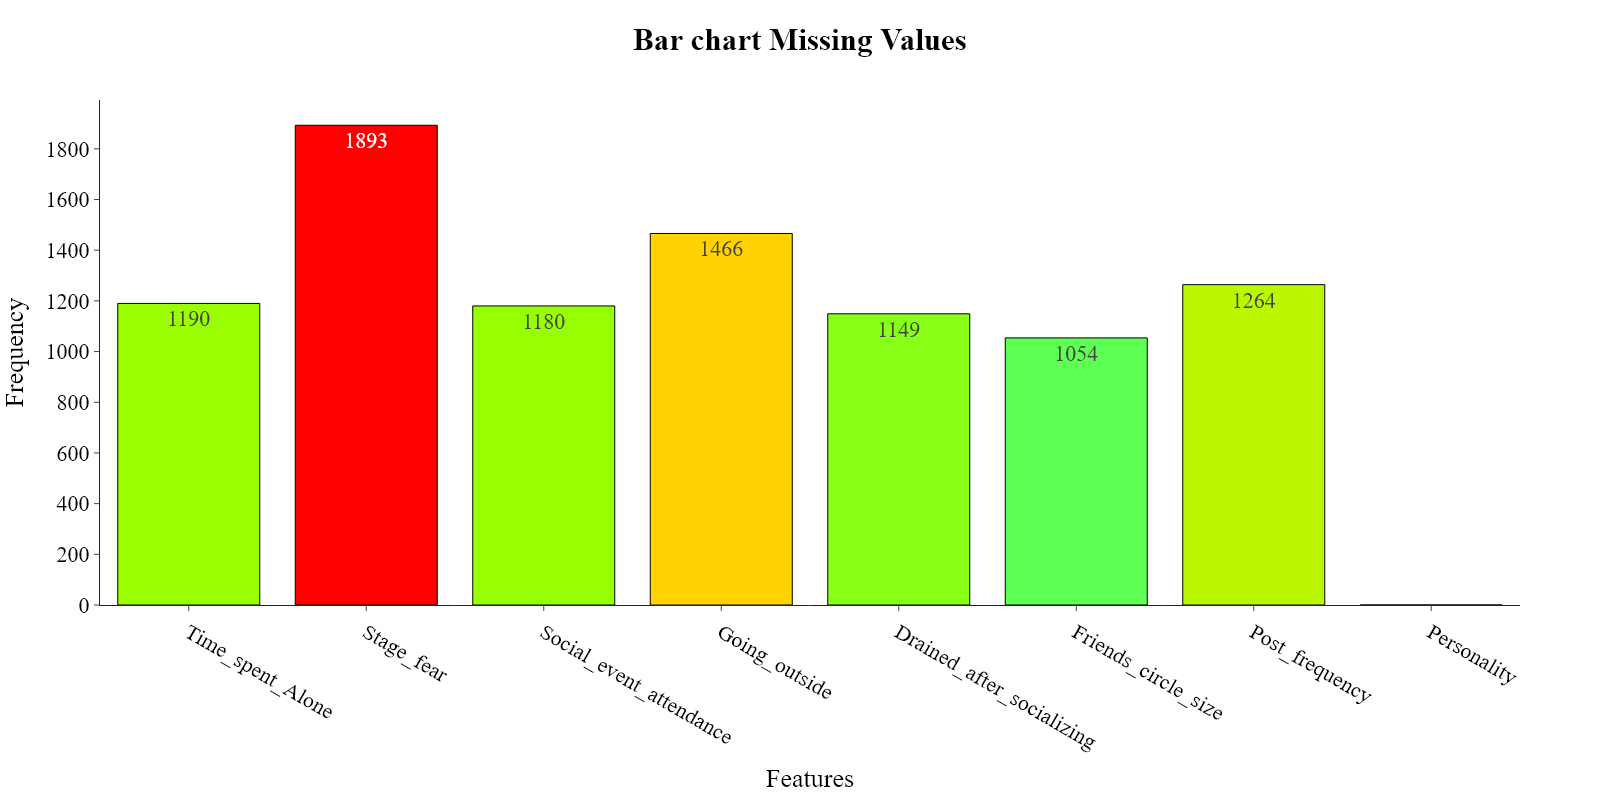

In [11]:
plots.barplot_missing_values(train_data.isna().sum(), train_data.columns, name="Missing values")

## Categorical Features

In [12]:
categorical_columns_by_missing = categorize_categorical_columns_by_missing(train_data, categorical_columns)

Impute missing values based on some insights from the data.

In [13]:
def impute_missing_values(data, categorical_to_impute, non_missing_categorical, threshold_num_observation=10):
    """
    Impute missing values in a DataFrame based on joint distribution of categorical columns.

    Args:
        data (pd.DataFrame): The input DataFrame.
        categorical_to_impute (list): List of categorical columns with some missing values.
        non_missing_categorical (list): List of categorical columns with no missing values.
        threshold_num_observation (int): The minimum number of observations required to perform imputation.

    Returns:
        None: The function modifies the DataFrame in place.
    """
    full = [list(comb) for comb in itertools.product(categorical_to_impute, non_missing_categorical)]
    df_copy = data.copy()
    for comb in full:
        column_with_nulls = comb[0]
        column_without_nulls = comb[1]
        joint_distribution = df_copy.groupby([column_with_nulls, column_without_nulls], observed=False)[column_without_nulls].size().unstack().fillna(0)
        zero_condition = (joint_distribution[joint_distribution != 0.0].count(axis=0) == 1)
        if zero_condition.any():
            zero_value_without_nulls = zero_condition[zero_condition == True].index.tolist()
            for idx, value_without_nulls in enumerate(zero_value_without_nulls):
                number_of_observations = joint_distribution[value_without_nulls].sum()
                if(number_of_observations < threshold_num_observation):
                    #Jeśli liczba obserwacji w danej kategorii zmiennej za pomocą, której przeprowadzamy imputację jest mniejsza niż 10 to nie przeprowadzamy imputacji jest mniejsza niż threshold_num_observation to nie przeprowadzamy imputacji, ponieważ jest to zbyt mało danych aby mieć pewność, że imputacja jest poprawna
                    continue
                second_condition_rows_num = (df_copy[column_with_nulls].isnull() & (df_copy[column_without_nulls] == value_without_nulls)).sum()
                if second_condition_rows_num > 0:
                    value_to_fillna = joint_distribution[value_without_nulls][joint_distribution[value_without_nulls] != 0].index.tolist()[0]
                    plots.heatmap(data=joint_distribution, xaxis_title=column_with_nulls, yaxis_title=column_without_nulls)
                    null_rows_indices = df_copy[(df_copy[column_with_nulls].isnull()) & (df_copy[column_without_nulls] == value_without_nulls)][[column_with_nulls, column_without_nulls]].index.tolist()
                    # print(f"Rows before fillna:\n{df.loc[null_rows_indices][[column_with_nulls, column_without_nulls]].head(5)}")
                    df_copy.loc[(df_copy[column_with_nulls].isnull()) & (df_copy[column_without_nulls] == value_without_nulls), column_with_nulls] = value_to_fillna
                    # print(f"Rows after fillna:\n{df_copy.loc[null_rows_indices][[column_with_nulls, column_without_nulls]].head(5)}")
                    print(f"Imputed {len(null_rows_indices)} rows with {value_to_fillna} value for column: {column_with_nulls} based on {column_without_nulls} column with value: {value_without_nulls}.")
                #     count += 1
                # if count == 1:
                #     return df_copy
    return df_copy
impute_missing_values(train_data, categorical_columns_by_missing["categorical_missing_columns"], categorical_columns_by_missing["non_missing_categorical_columns"], threshold_num_observation=1)
# data = impute_missing_values(data, categorical_columns_by_missing["categorical_missing_columns"], categorical_columns_by_missing["non_missing_categorical_columns"], threshold_num_observation=1) # Only if we want to impute missing values in categorical columns

Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0                   0.0         No                      6.0            4.0   
1                   1.0         No                      7.0            3.0   
2                   6.0        Yes                      1.0            0.0   
3                   3.0         No                      7.0            3.0   
4                   1.0         No                      4.0            4.0   
...                 ...        ...                      ...            ...   
18519               3.0         No                      7.0            3.0   
18520               1.0        NaN                      6.0            7.0   
18521               7.0        Yes                      1.0            1.0   
18522               NaN        Yes                      1.0            0.0   
18523               1.0         No                      8.0            6.0   

      Drained_after_socializing  Friends_circle_size  Post_frequency  \
0                            No                 15.0             5.0   
1                            No                 10.0             8.0   
2                           NaN                  3.0             0.0   
3                            No                 11.0             5.0   
4                            No                 13.0             NaN   
...                         ...                  ...             ...   
18519                        No                  9.0             7.0   
18520                        No                  6.0             5.0   
18521                       Yes                  1.0             NaN   
18522                       Yes                  5.0             2.0   
18523                        No                  4.0             7.0   

      Personality  
0       Extrovert  
1       Extrovert  
2       Introvert  
3       Extrovert  
4       Extrovert  
...           ...  
18519   Extrovert  
18520   Extrovert  
18521   Introvert  
18522   Introvert  
18523   Extrovert  

[18524 rows x 8 columns]

In [14]:
output = []
for col in categorical_columns_by_missing["categorical_missing_columns"]:
    output.append(describe_categorical_feature(train_data, col, top_n=15).to_html())
    output.append("\n")
display(HTML("<br>".join(output)))

- Column name: `Drained_after_socializing`
- Chosen strategy: Keep null values as a separate category 'Unknown'
- Justification: The column is binary, and the missing values might represent a specific state (e.g., "not applicable" or "unknown"). Keeping them as a separate category allows the model to learn from this information.

In [15]:
train_data['Drained_after_socializing'] = train_data['Drained_after_socializing'].fillna('Unknown')
train_data['Drained_after_socializing'] = train_data['Drained_after_socializing'].astype('category')
test_data['Drained_after_socializing'] = test_data['Drained_after_socializing'].fillna('Unknown')
test_data['Drained_after_socializing'] = pd.Categorical(
    test_data['Drained_after_socializing'],
    categories=train_data['Drained_after_socializing'].cat.categories
)

- Column name: `Stage_fear`
- Chosen strategy: Keep null values as a separate category 'Unknown'
- Justification: The column is binary, and the missing values might represent a specific state (e.g., "not applicable" or "unknown"). Keeping them as a separate category allows the model to learn from this information.

In [16]:
train_data['Stage_fear'] = train_data['Stage_fear'].fillna('Unknown')
train_data['Stage_fear'] = train_data['Stage_fear'].astype('category')
test_data['Stage_fear'] = test_data['Stage_fear'].fillna('Unknown')
test_data['Stage_fear'] = pd.Categorical(
    test_data['Stage_fear'],
    categories=train_data['Stage_fear'].cat.categories
)

## Object columns

In [17]:
object_columns = train_data.select_dtypes(include=['object']).columns
object_missing_columns = [col for col in object_columns if train_data[col].isnull().mean() > 0.0]
output = []
for col in object_missing_columns:
    output.append(describe_categorical_feature(train_data, col, top_n=5).to_html())
    output.append("\n")
display(HTML("<br>".join(output)))

## Numerical Features

In [18]:
numerical_columns = train_data.select_dtypes(include=['number']).columns
numerical_missing_columns = [col for col in numerical_columns if train_data[col].isnull().mean() > 0.0]
output = []
for col in numerical_missing_columns:
    output.append(describe_numerical_feature(train_data, col).to_html())
    output.append("\n")
display(HTML("<br>".join(output)))

# Imputation Strategies

In [19]:
class StatisticalAssociationImputer:
    def __init__(
        self,
        metrics: list[str] = ["cramers_v", "mutual_info", "theils_u"],
        top_n: int = 2,
        verbose: bool = False,
    ):
        self.metrics = metrics
        self.top_n = top_n
        self.verbose = verbose
        self.rankings = None
        self.selected_cols = None
        self.bin_edges = {}
        self.categorical_columns = None
        self.impute_stats = None

    def fit(self, df: pd.DataFrame):
        """
        Fits the imputer to the data, learning binning and grouping columns for ALL features.
        Prepares imputation statistics for every column to handle cases where test data
        has missing values in columns that had no missing values in training data.

        Args:
            df (pd.DataFrame): Training DataFrame to learn imputation patterns from.

        Returns:
            StatisticalAssociationImputer: Returns self for method chaining.
        """
        self.bin_edges = {}
        self.categorical_columns = self._get_categorical_columns(df)

        all_features = [col for col in df.columns]
        if self.verbose:
            print(f"Preparing imputation statistics for all features: {all_features}")
        self.impute_stats = {}
        for feature in all_features:
            self.rank_metrics(df, feature)
            self.select_grouping_columns()
            self.impute_stats[feature] = {
                'stats': self.calculate_stats(df, feature),
                'selected_cols': self.selected_cols.copy(),
                'rankings': self.rankings.copy()
            }
        
        return self
    
    def _get_categorical_columns(self, df: pd.DataFrame) -> list[str]:
        """Helper method to identify categorical columns."""
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns
        categorical_columns = [col for col in categorical_columns if df[col].nunique() < 100]
        categorical_columns = list(set(categorical_columns) | set(df.columns[df.nunique() == 2]))
        return categorical_columns

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Applies learned imputation to new data using stored binning information.
        Imputes missing values in ALL columns that have missing values.

        Args:
            df (pd.DataFrame): DataFrame to impute missing values in.

        Returns:
            pd.DataFrame: DataFrame with imputed values.

        Raises:
            ValueError: If fit() has not been called first.
        """
        if self.impute_stats is None:
            raise ValueError("Must call fit() first to learn binning and grouping.")
        
        df = df.copy()
        columns_with_missing = df.columns[df.isnull().any()].tolist()
        
        if self.verbose and columns_with_missing:
            print(f"Found missing values in columns: {columns_with_missing}")
        elif self.verbose:
            print("No missing values found in any columns.")
        
        for feature in columns_with_missing:
            if feature not in self.impute_stats:
                if self.verbose:
                    print(f"Warning: No imputation info for feature '{feature}', skipping.")
                continue

            feature_info = self.impute_stats[feature]
            self.selected_cols = feature_info['selected_cols']
            
            df = self.impute_with_stats(df, feature, feature_info['stats'])
            
            if self.verbose:
                self.ks_test(df, feature)
                #self.plot_distribution(df, feature)
            
            df[feature] = df["imputed"]
            df.drop(columns="imputed", inplace=True)

            if f"{feature}_imputed" in df.columns:
                df.drop(columns=f"{feature}_imputed", inplace=True)
        
        return df

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Fits the imputer and transforms the data in one step.
        Prepares imputation statistics for all columns and imputes missing values.

        Args:
            df (pd.DataFrame): DataFrame to fit on and transform.

        Returns:
            pd.DataFrame: DataFrame with imputed values.
        """
        self.fit(df)
        return self.transform(df)
    
    def rank_metrics(self, df: pd.DataFrame, feature_name: str) -> pd.DataFrame:
        """
        Ranks columns by their association with the target feature using multiple metrics.

        Args:
            df (pd.DataFrame): Input DataFrame.
            feature_name (str): Target feature name.

        Returns:
            pd.DataFrame: Rankings DataFrame with metric scores and ranks.
        """
        rankings = defaultdict(dict)
        df_bin = self.bin_dataframe(df, feature_name)

        if "cramers_v" in self.metrics:
            for col in df_bin.columns:
                if col != feature_name and df_bin[col].nunique() > 1:
                    rankings["cramers_v"][col] = self.cramers_v(
                        df_bin[col], df_bin[feature_name]
                    )

        if "mutual_info" in self.metrics:
            temp = df_bin.dropna()
            if len(temp) > 0:
                y = temp[feature_name].astype("category").cat.codes
                for col in df_bin.columns:
                    if col != feature_name:
                        X = temp[col].astype("category").cat.codes.values.reshape(-1, 1)
                        mi = mutual_info_classif(X, y, discrete_features=True)
                        rankings["mutual_info"][col] = mi[0]

        if "theils_u" in self.metrics:
            for col in df_bin.columns:
                if col != feature_name and df_bin[col].nunique() > 1:
                    rankings["theils_u"][col] = self.theils_u(
                        df_bin[col], df_bin[feature_name]
                    )

        df_ranks = pd.DataFrame(rankings)
        for metric in df_ranks.columns:
            df_ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=False)
        df_ranks["total_rank"] = df_ranks[[c for c in df_ranks.columns if c.endswith("_rank")]].sum(axis=1)
        df_ranks = df_ranks.sort_values("total_rank")
        if self.verbose:
            display(df_ranks)
        self.rankings = df_ranks
        return df_ranks
    
    def bin_dataframe(self, df: pd.DataFrame, feature_name: str, fit_bins: bool = True) -> pd.DataFrame:
        """
        Bins numerical features to reduce cardinality for association metrics.
        Stores binning information for reproducibility on new data.

        Args:
            df (pd.DataFrame): Input DataFrame.
            feature_name (str): Target feature name.
            fit_bins (bool): If True, fits new bins. If False, uses existing bins.

        Returns:
            pd.DataFrame: DataFrame with binned numerical features.
        """
        df_bin = df.copy()
        numerical_columns = list(set(df.columns) - set(self.categorical_columns) - {feature_name})
        for col in numerical_columns:
            try:
                non_na_data = df[col].dropna()
                if len(non_na_data) > 1:
                    if fit_bins:
                        _, bin_edges = pd.qcut(non_na_data, q=10, duplicates="drop", retbins=True)
                        self.bin_edges[col] = bin_edges
                    if col in self.bin_edges:
                        df_bin[col] = pd.cut(df[col], bins=self.bin_edges[col], include_lowest=True, duplicates="drop")
            except (ValueError, TypeError):
                df_bin[col] = df[col]
        return df_bin

    @staticmethod
    def cramers_v(x: pd.Series, y: pd.Series) -> float:
        """
        Calculates Cramer's V association measure between two categorical variables.

        Args:
            x (pd.Series): First categorical variable.
            y (pd.Series): Second categorical variable.

        Returns:
            float: Cramer's V value between 0 and 1, or 0 if calculation fails.
        """
        try:
            temp_df = pd.DataFrame({'x': x, 'y': y}).dropna()
            if len(temp_df) < 2:
                return 0.0
            if temp_df['x'].nunique() <= 1 or temp_df['y'].nunique() <= 1:
                return 0.0
            confusion_matrix = pd.crosstab(temp_df['x'], temp_df['y'])
            chi2 = chi2_contingency(confusion_matrix)[0]
            n = confusion_matrix.sum().sum()
            if n == 0:
                return 0.0
                
            phi2 = chi2 / n
            r, k = confusion_matrix.shape
            phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
            rcorr = r - ((r - 1) ** 2) / (n - 1)
            kcorr = k - ((k - 1) ** 2) / (n - 1)
            
            denominator = min((kcorr - 1), (rcorr - 1))
            if denominator <= 0:
                return 0.0
                
            return np.sqrt(phi2corr / denominator)
        except (ValueError, ZeroDivisionError, IndexError):
            return 0.0

    @staticmethod
    def theils_u(x: pd.Series, y: pd.Series) -> float:
        """
        Calculates Theil's U uncertainty coefficient between two categorical variables.

        Args:
            x (pd.Series): First categorical variable.
            y (pd.Series): Second categorical variable.

        Returns:
            float: Theil's U value between 0 and 1, or 0 if calculation fails.
        """
        try:
            temp_df = pd.DataFrame({'x': x, 'y': y}).dropna()
            if len(temp_df) < 2:
                return 0.0
            if temp_df['x'].nunique() <= 1 or temp_df['y'].nunique() <= 1:
                return 0.0
            s_xy = pd.crosstab(temp_df['x'], temp_df['y'])
            s_x = s_xy.sum(axis=1)
            s_y = s_xy.sum(axis=0)
            total = s_xy.sum().sum()
            if total == 0:
                return 0.0
            H_y = -sum((val / total) * log(val / total + 1e-10) for val in s_y if val > 0)
            if H_y == 0:
                return 0.0
            H_y_given_x = 0
            for row in s_xy.itertuples(index=False):
                row_total = sum(row)
                if row_total == 0:
                    continue
                H_row = -sum(
                    (val / row_total) * log(val / row_total + 1e-10)
                    for val in row
                    if val > 0
                )
                H_y_given_x += row_total / total * H_row
            return (H_y - H_y_given_x) / H_y
        except (ValueError, ZeroDivisionError, IndexError):
            return 0.0
        
    def select_grouping_columns(self) -> list[str]:
        """
        Selects top-N columns based on ranking metrics.

        Returns:
            list[str]: List of selected column names for grouping.

        Raises:
            ValueError: If rank_metrics has not been called first.
        """
        if self.rankings is None:
            raise ValueError("Run rank_metrics first.")
        self.selected_cols = self.rankings.head(self.top_n).index.tolist()
        if self.verbose:
            print(f"Selected grouping columns: {self.selected_cols}")
        return self.selected_cols
    
    def calculate_stats(self, df: pd.DataFrame, feature_name: str) -> dict[str, any]:
        """
        Calculates group-wise and overall statistics for the feature.
        Uses binned values for grouping to ensure reproducibility, but original values for statistics.

        Args:
            df (pd.DataFrame): DataFrame containing the feature and grouping columns.
            feature_name (str): Name of the feature to calculate statistics for.

        Returns:
            dict[str, any]: Dictionary containing group-wise and overall statistics.
        """
        is_categorical = feature_name in self.categorical_columns
        df_binned = self.bin_dataframe(df, feature_name, fit_bins=False)

        df_for_stats = df_binned.copy()
        df_for_stats[feature_name] = df[feature_name]
        grouping_cols_binned = []
        for col in self.selected_cols:
            if col in df_binned.columns:
                grouping_cols_binned.append(col)
        
        grouped = df_for_stats.groupby(grouping_cols_binned, observed=True, dropna=False)[feature_name]
        
        if is_categorical:
            group_stats = grouped.agg(
                lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
            ).dropna()
            overall_stat = (
                df[feature_name].mode().iloc[0]
                if not df[feature_name].mode().empty
                else np.nan
            )
        else:
            group_stats = grouped.mean().dropna()
            overall_stat = df[feature_name].mean()

        if len(grouping_cols_binned) == 1:
            group_stats.index = [(val,) for val in group_stats.index]
        
        stat_dict = {"group": group_stats.to_dict(), "overall": overall_stat}
        if self.verbose:
            print("Stats by group (using binned grouping):")
            for group, stat in stat_dict["group"].items():
                group_str = ", ".join(f"{col}: {val}" for col, val in zip(self.selected_cols, group))
                print(f"{group_str} -> {stat}")
            print("Overall stat:", stat_dict["overall"])
        return stat_dict
    
    def impute_with_stats(
        self, df: pd.DataFrame, feature_name: str, impute_stats: dict[str, any]
    ) -> pd.DataFrame:
        """
        Imputes missing values in the feature using group-wise statistics.
        Uses binned values for grouping to ensure consistency.

        Args:
            df (pd.DataFrame): DataFrame containing the feature and selected grouping columns.
            feature_name (str): Name of the feature to impute.
            impute_stats (dict[str, any]): Dictionary with group-wise and overall statistics.

        Returns:
            pd.DataFrame: DataFrame with imputed values.
        """
        missing_mask = df[feature_name].isna()
        df["imputed"] = df[feature_name]
        df[f"{feature_name}_imputed"] = False
        df_binned = self.bin_dataframe(df, feature_name, fit_bins=False)
        for idx in df[missing_mask].index:
            row_binned = df_binned.loc[idx]
            group_key = tuple(row_binned[col] for col in self.selected_cols)
            if group_key in impute_stats["group"]:
                df.at[idx, "imputed"] = impute_stats["group"][group_key]
            else:
                df.at[idx, "imputed"] = impute_stats["overall"]
            df.at[idx, f"{feature_name}_imputed"] = True
        if self.verbose:
            print(
                f"Imputed {missing_mask.sum()} missing values in '{feature_name}' using group-wise statistics."
            )
        return df
    
    def ks_test(self, df: pd.DataFrame, feature_name: str) -> tuple[float, float]:
        """
        Performs the Kolmogorov-Smirnov test to compare distributions.

        Args:
            df (pd.DataFrame): DataFrame containing the feature and 'imputed' column.
            feature_name (str): Name of the feature to test.

        Returns:
            tuple[float, float]: KS statistic and p-value.
        """
        """
        Performs the Kolmogorov-Smirnov test to compare the distributions of the original and imputed feature values.

        Args:
            df (pd.DataFrame): DataFrame containing the feature and 'imputed' column.
            feature_name (str): Name of the feature to test.

        Returns:
            tuple: (ks_stat, ks_p) where ks_stat is the KS statistic and ks_p is the p-value.
        """
        original = df[feature_name].dropna()
        imputed = df["imputed"]
        ks_stat, ks_p = ks_2samp(original, imputed)
        print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f} - {'Distributions are significantly different (reject H0)' if ks_p < 0.05 else 'Distributions are not significantly different (fail to reject H0)'}")
        return ks_stat, ks_p

    def plot_distribution(self, df: pd.DataFrame, feature_name: str) -> None:
        """
        Plots the distribution of the feature before and after imputation using Plotly.

        Args:
            df (pd.DataFrame): DataFrame containing the feature and 'imputed' column.
            feature_name (str): Name of the feature to plot.
        """
        is_categorical = feature_name in self.categorical_columns
        if is_categorical:
            original_counts = df[feature_name].value_counts(normalize=True).sort_index() * 100
            imputed_counts = df["imputed"].value_counts(normalize=True).sort_index() * 100
            fig = go.Figure()
            fig.add_trace(
                go.Bar(
                    x=original_counts.index,
                    y=original_counts.values,
                    name="Before imputation",
                    marker=dict(color=px.colors.qualitative.Pastel[0]),
                    text=[f"{v:.2f}%" for v in original_counts.values],
                    textposition="auto"
                )
            )
            fig.add_trace(
                go.Bar(
                    x=imputed_counts.index,
                    y=imputed_counts.values,
                    name="After imputation",
                    marker=dict(color=px.colors.qualitative.Pastel[1]),
                    text=[f"{v:.2f}%" for v in imputed_counts.values],
                    textposition="auto"
                )
            )
            fig.update_layout(
                template="simple_white",
                width=1200,
                height=800,
                title=f"<b>Distribution of '{feature_name}' before and after imputation<b>",
                title_x=0.5,
                font=dict(family="Times New Roman", size=22, color="Black"),
                xaxis_title="Feature value",
                yaxis_title="Percentage (%)",
                barmode="group",
            )
            fig.update_xaxes(type="category")
            fig.show("png")
        else:
            original_data = df[feature_name].dropna()
            imputed_data = df["imputed"]
            kde_orig = gaussian_kde(original_data)
            kde_imputed = gaussian_kde(imputed_data)
            x_min = min(original_data.min(), imputed_data.min())
            x_max = max(original_data.max(), imputed_data.max())
            x_vals = np.linspace(x_min, x_max, 500)
            colors = px.colors.qualitative.Pastel
            fig = go.Figure()
            fig.add_trace(
                go.Scatter(
                    x=x_vals,
                    y=kde_orig(x_vals),
                    mode="lines",
                    name="Before imputation",
                    line=dict(color=colors[0], width=5),
                )
            )
            fig.add_trace(
                go.Scatter(
                    x=x_vals,
                    y=kde_imputed(x_vals),
                    mode="lines",
                    name="After imputation",
                    line=dict(color=colors[1], width=5),
                )
            )
            fig.update_layout(
                template="simple_white",
                width=1200,
                height=800,
                title=f"<b>Distribution of '{feature_name}' before and after imputation<b>",
                title_x=0.5,
                font=dict(family="Times New Roman", size=22, color="Black"),
                xaxis_title="Feature value",
                yaxis_title="Density",
            )
            fig.show("png")

# statistical_imputer = StatisticalAssociationImputer(metrics=['cramers_v', 'mutual_info', 'theils_u'], top_n=2, verbose=True)
# statistical_imputer.fit(train_data)

# train_data_impute = train_data.drop(columns=[target_feature], errors='ignore').copy()
# test_data_impute = test_data.drop(columns=[target_feature], errors='ignore').copy()
# all_missing_columns = train_data_impute.isna().sum()[train_data_impute.isna().sum() > 0].index.tolist()
# for col in all_missing_columns:
#     train_data_impute = statistical_imputer.fit_transform(train_data_impute, col)
#     test_data_impute = statistical_imputer.transform(test_data_impute, col)

# for col in all_missing_columns:
#     train_data[col] = train_data_impute[col]
#     test_data[col] = test_data_impute[col]

In [20]:
X_train = train_data.drop(columns=[target_feature])
y_train = train_data[target_feature]
model = LGBMClassifier(boosting_type='gbdt', random_state=SEED, n_jobs=-1, objective='binary', metric='binary_logloss', verbose=-1, early_stopping=100)

In [21]:
class FoldwiseImputer:
    def __init__(
        self,
        strategy="median_mode",
        num_value=-99,
        cat_value="Unknown",
        knn_params=None,
        iterative_params=None,
        statistical_params=None
    ):
        self.strategy = strategy
        self.num_value = num_value
        self.cat_value = cat_value
        self.knn_params = knn_params or {}
        self.iterative_params = iterative_params or {}
        self.statistical_params = statistical_params or {}
        self.imputer = None
        self.impute_values = {}

    def fit(self, X: pd.DataFrame):
        if self.strategy in ["median_mode", "arbitrary"]:
            self.impute_values = {}
            for col in X.columns:
                if X[col].isna().any():
                    if X[col].dtype in ['float64', 'int64']:
                        if self.strategy == "median_mode":
                            self.impute_values[col] = X[col].median()
                        else:
                            self.impute_values[col] = self.num_value
                    else:
                        if self.strategy == "median_mode":
                            self.impute_values[col] = X[col].mode(dropna=True).iloc[0]
                        else:
                            self.impute_values[col] = self.cat_value

        elif self.strategy == "knn":
            self.imputer = KNNImputer(**self.knn_params)
            self.imputer.fit(X.select_dtypes(include=["number"]))

        elif self.strategy == "iterative":
            self.imputer = IterativeImputer(**self.iterative_params)
            self.imputer.fit(X.select_dtypes(include=["number"]))

        elif self.strategy == "statistical_association":
            self.imputer = StatisticalAssociationImputer(**self.statistical_params)
            self.imputer.fit(X)
        else:
            raise ValueError(f"Unknown imputation strategy: {self.strategy}")

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_filled = X.copy()
        if self.strategy in ["median_mode", "arbitrary"]:
            for col, val in self.impute_values.items():
                was_na = X_filled[col].isna()
                X_filled[col] = X_filled[col].fillna(val)
                # imputed_col = f"{col}_was_imputed"
                # X_filled[imputed_col] = was_na.astype(int)

        elif self.strategy in ["knn", "iterative"]:
            numeric_cols = X.select_dtypes(include=["number"]).columns
            filled_values = self.imputer.transform(X[numeric_cols])
            X_filled[numeric_cols] = filled_values
            # for col in numeric_cols:
            #     was_na = X_filled[col].isna()
            #     imputed_col = f"{col}_was_imputed"
            #     X_filled[imputed_col] = was_na.astype(int)

        elif self.strategy == "statistical_association":
            X_filled = X_filled.copy()
            X_filled = self.imputer.transform(X_filled)
                
        for col in X_filled.select_dtypes(include=["object"]).columns:
            if col in self.impute_values:
                X_filled[col] = X_filled[col].astype("category")
            else:
                X_filled[col] = X_filled[col].fillna(self.cat_value).astype("category")
        return X_filled

    def fit_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        self.fit(X)
        return self.transform(X)

def perform_cv_with_imputer(
    X: pd.DataFrame,
    y: pd.Series,
    algorithm: object,
    cv=KFold(n_splits=5, shuffle=True, random_state=17),
    metric_name: str = "RMSE",
    imputer: FoldwiseImputer = None
) -> tuple[list[float], list[float]]:
    """
    Perform cross-validation and return list of scores, with fold-specific imputation.
    """
    if metric_name not in METRICS.keys():
        raise ValueError(f"Metric {metric_name} not found in METRICS dictionary")
    eval_metric = METRICS[metric_name][0]
    metric_type = METRICS[metric_name][1]
    train_scores, validation_scores = [], []
    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        if imputer is not None:
            imputer_fold = deepcopy(imputer)
            X_train = imputer_fold.fit_transform(X_train)
            X_valid = imputer_fold.transform(X_valid)
        y_train_pred, y_valid_pred = fit_and_predict(algorithm, X_train, y_train, X_valid, y_valid, metric_type)
        train_scores.append(eval_metric(y_train, y_train_pred))
        validation_scores.append(eval_metric(y_valid, y_valid_pred))
    return train_scores, validation_scores


imputation_results = []

# 1. No imputation (baseline)
print("🔄 Testing baseline (no imputation)...")
train_scores, validation_scores = perform_cv_with_imputer(
    X_train, y_train, algorithm=model, cv=CV, metric_name=compare_metric_name, imputer=None
)
imputation_results.append({
    "Imputation": "None (Baseline)",
    "Train Mean": np.mean(train_scores),
    "Train Std": np.std(train_scores),
    "Valid Mean": np.mean(validation_scores),
    "Valid Std": np.std(validation_scores)
})

# 2. Arbitrary imputation
print("🔄 Testing arbitrary imputation...")
arbitrary_imputer = FoldwiseImputer(strategy="arbitrary", num_value=-99, cat_value="Unknown")
train_scores, validation_scores = perform_cv_with_imputer(
    X_train, y_train, algorithm=model, cv=CV, metric_name=compare_metric_name, imputer=arbitrary_imputer
)
imputation_results.append({
    "Imputation": "arbitrary",
    "Train Mean": np.mean(train_scores),
    "Train Std": np.std(train_scores),
    "Valid Mean": np.mean(validation_scores),
    "Valid Std": np.std(validation_scores)
})

# 3. Median/Mode imputation
print("🔄 Testing median/mode imputation...")
median_mode_imputer = FoldwiseImputer(strategy="median_mode")
train_scores, validation_scores = perform_cv_with_imputer(
    X_train, y_train, algorithm=model, cv=CV, metric_name=compare_metric_name, imputer=median_mode_imputer
)
imputation_results.append({
    "Imputation": "median_mode",
    "Train Mean": np.mean(train_scores),
    "Train Std": np.std(train_scores),
    "Valid Mean": np.mean(validation_scores),
    "Valid Std": np.std(validation_scores)
})

# 4. KNN imputation
print("🔄 Testing KNN imputation...")
scaler = StandardScaler()
scaler.fit(X_train[numerical_columns])
X_train_scaled = X_train.copy()
X_train_scaled[numerical_columns] = scaler.transform(X_train[numerical_columns])
knn_imputer = FoldwiseImputer(strategy="knn", knn_params={"n_neighbors": 5, "weights": "distance"})
train_scores, validation_scores = perform_cv_with_imputer(
    X_train_scaled, y_train, algorithm=model, cv=CV, metric_name=compare_metric_name, imputer=knn_imputer
)
imputation_results.append({
    "Imputation": "knn",
    "Train Mean": np.mean(train_scores),
    "Train Std": np.std(train_scores),
    "Valid Mean": np.mean(validation_scores),
    "Valid Std": np.std(validation_scores)
})

# 5. Iterative imputation
print("🔄 Testing iterative imputation...")
iterative_imputer = FoldwiseImputer(strategy="iterative", iterative_params={"max_iter": 10, "random_state": SEED})
train_scores, validation_scores = perform_cv_with_imputer(
    X_train, y_train, algorithm=model, cv=CV, metric_name=compare_metric_name, imputer=iterative_imputer
)
imputation_results.append({
    "Imputation": "iterative",
    "Train Mean": np.mean(train_scores),
    "Train Std": np.std(train_scores),
    "Valid Mean": np.mean(validation_scores),
    "Valid Std": np.std(validation_scores)
})

# 6. Statistical association imputation
print("🔄 Testing statistical association imputation...")
statistical_imputer = FoldwiseImputer(strategy="statistical_association", statistical_params={"metrics": ['cramers_v', 'mutual_info', 'theils_u'], "top_n": 2, "verbose": False})
train_scores, validation_scores = perform_cv_with_imputer(
    X_train, y_train, algorithm=model, cv=CV, metric_name=compare_metric_name, imputer=statistical_imputer
)
imputation_results.append({
    "Imputation": "statistical_association",
    "Train Mean": np.mean(train_scores),
    "Train Std": np.std(train_scores),
    "Valid Mean": np.mean(validation_scores),
    "Valid Std": np.std(validation_scores)
})

imputation_results_df = pd.DataFrame(imputation_results)
imputation_results_df = imputation_results_df[["Imputation", "Train Mean", "Train Std", "Valid Mean", "Valid Std"]]
imputation_results_df.style.set_caption("📝 Imputation Comparison") \
    .format({
        "Train Mean": "{:.4f}",
        "Train Std": "{:.4f}",
        "Valid Mean": "{:.4f}",
        "Valid Std": "{:.4f}"
    }) \
    .bar(subset=["Valid Mean"], color="#4a90e2", vmin=0, vmax=1) \
    .set_properties(**{
        'text-align': 'left',
        'font-family': 'Times New Roman',
        'font-size': '1.25em',
        'background-color': '#f9f9f9',
        'border': '1px solid #ddd',
        'color': '#333'
    }) \
    .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold'), ('border', '1px solid #ddd')]}])

🔄 Testing baseline (no imputation)...
🔄 Testing arbitrary imputation...
🔄 Testing median/mode imputation...
🔄 Testing KNN imputation...
🔄 Testing iterative imputation...
🔄 Testing statistical association imputation...


**Notes:**
- Median/Mode Imputation is the Winner - Despite being the simplest approach, it achieved the highest validation accuracy (0.9689)
- Minimal Performance Differences - All strategies perform very similarly (0.9684-0.9689 range), indicating that the missing data patterns in this personality dataset are relatively straightforward
- Advanced Methods Don't Help - Sophisticated approaches like KNN, Iterative, and GroupBy imputation actually perform slightly worse than the simple median/mode strategy
- Stable Performance - All methods show very low standard deviations, indicating consistent results across cross-validation folds

**Conclusion:**
- We will use the median/mode imputation strategy for its simplicity and effectiveness in this case.

In [22]:
train_data = median_mode_imputer.fit_transform(train_data)
test_data = median_mode_imputer.transform(test_data)

## Summary

In [23]:
display(base_information(train_data))
display(base_information(test_data))

# Features exploration

In [24]:
features = train_data.columns.tolist()
features = [(feature, train_data[feature].dtype) for feature in features]
for feature, dtype in features:
    print(f"- {feature} ({dtype})", end="\n")

- Time_spent_Alone (float64)
- Stage_fear (category)
- Social_event_attendance (float64)
- Going_outside (float64)
- Drained_after_socializing (category)
- Friends_circle_size (float64)
- Post_frequency (float64)
- Personality (category)


## 📚 Dataset Column Descriptions

- `Personality` (category): The target variable representing personality type classification, distinguishing between introversion and extroversion.
- `Time_spent_Alone` (float64): The amount of time an individual prefers to spend in solitude, measured on a numerical scale representing hours per day or preference level.
- `Stage_fear` (category): Whether the person experiences anxiety or fear when performing or speaking in front of an audience (Yes/No/Unknown).
- `Social_event_attendance` (float64): The frequency or preference level for attending social gatherings, parties, or group events, measured on a numerical scale.
- `Going_outside` (float64): The frequency or preference for outdoor activities and leaving one's home environment, measured on a numerical scale.
- `Drained_after_socializing` (category): Whether the person feels emotionally or physically drained after social interactions (Yes/No/Unknown).
- `Friends_circle_size` (float64): The number of close friends or the size of one's social network, measured numerically.
- `Post_frequency` (float64): How often the person posts content on social media platforms, measured on a frequency scale.

## `Personality`

`Personality` (category) - The target variable representing personality type classification, distinguishing between introversion and extroversion.

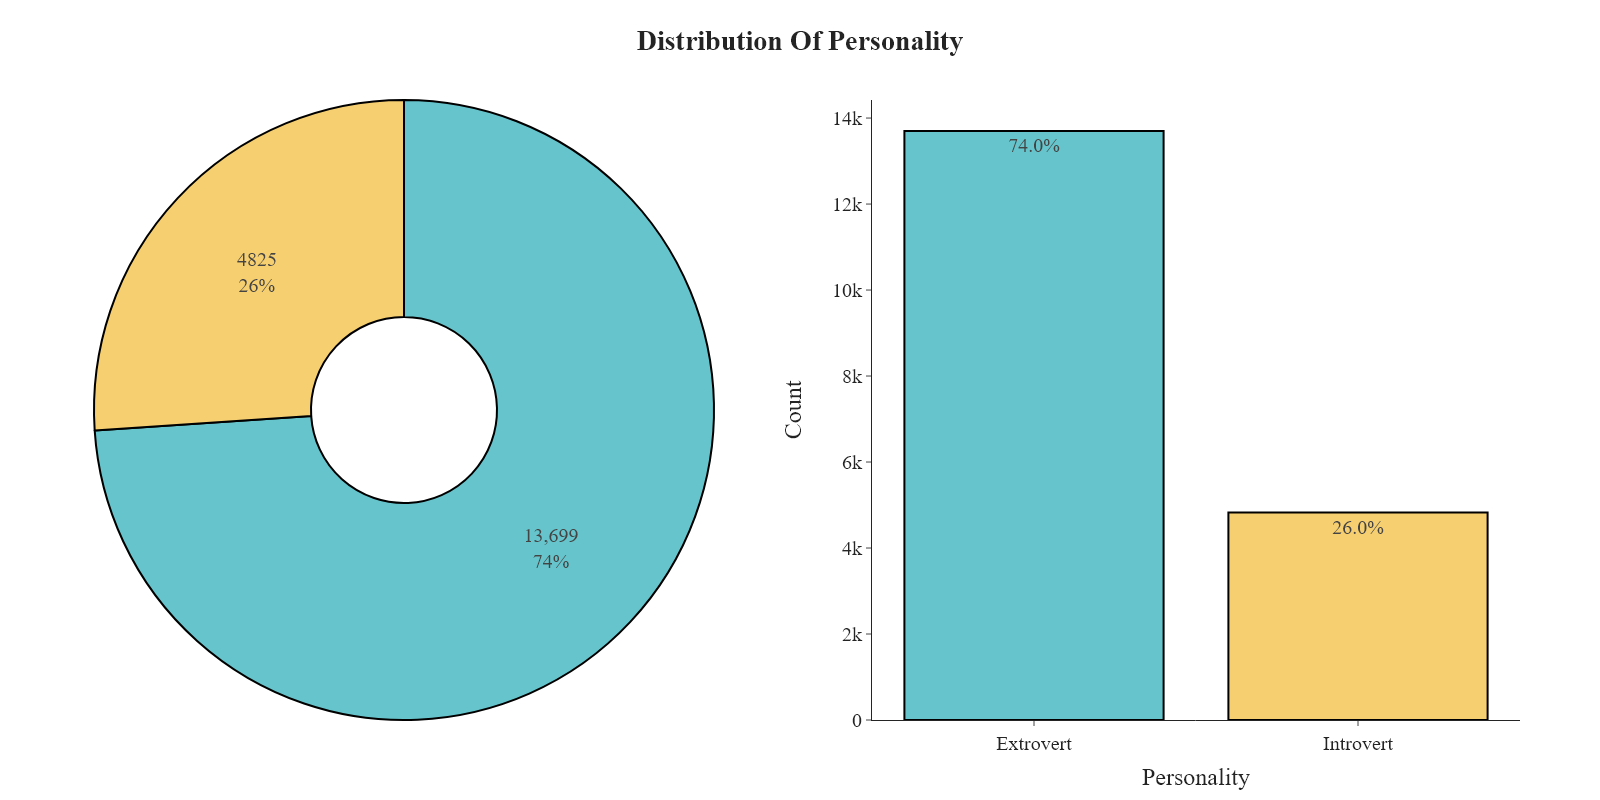

In [25]:
plots.pie_barplot(train_data, target_feature, plot_title=f"Distribution of {target_feature}")
describe_categorical_feature(train_data, target_feature)

**Notes:**

**Conclusion:**
- Class imbalance detected: 74% Extrovert vs 26% Introvert suggests stratified sampling and balanced metrics evaluation.
- Consider using stratified cross-validation and balanced accuracy or F1 scores for model evaluation.
- Apply class balancing techniques (e.g., SMOTE, class weights) to improve minority class prediction.

## `Time_spent_Alone`

`Time_spent_Alone` (float64) - The amount of time an individual prefers to spend in solitude, measured on a numerical scale representing hours per day or preference level.

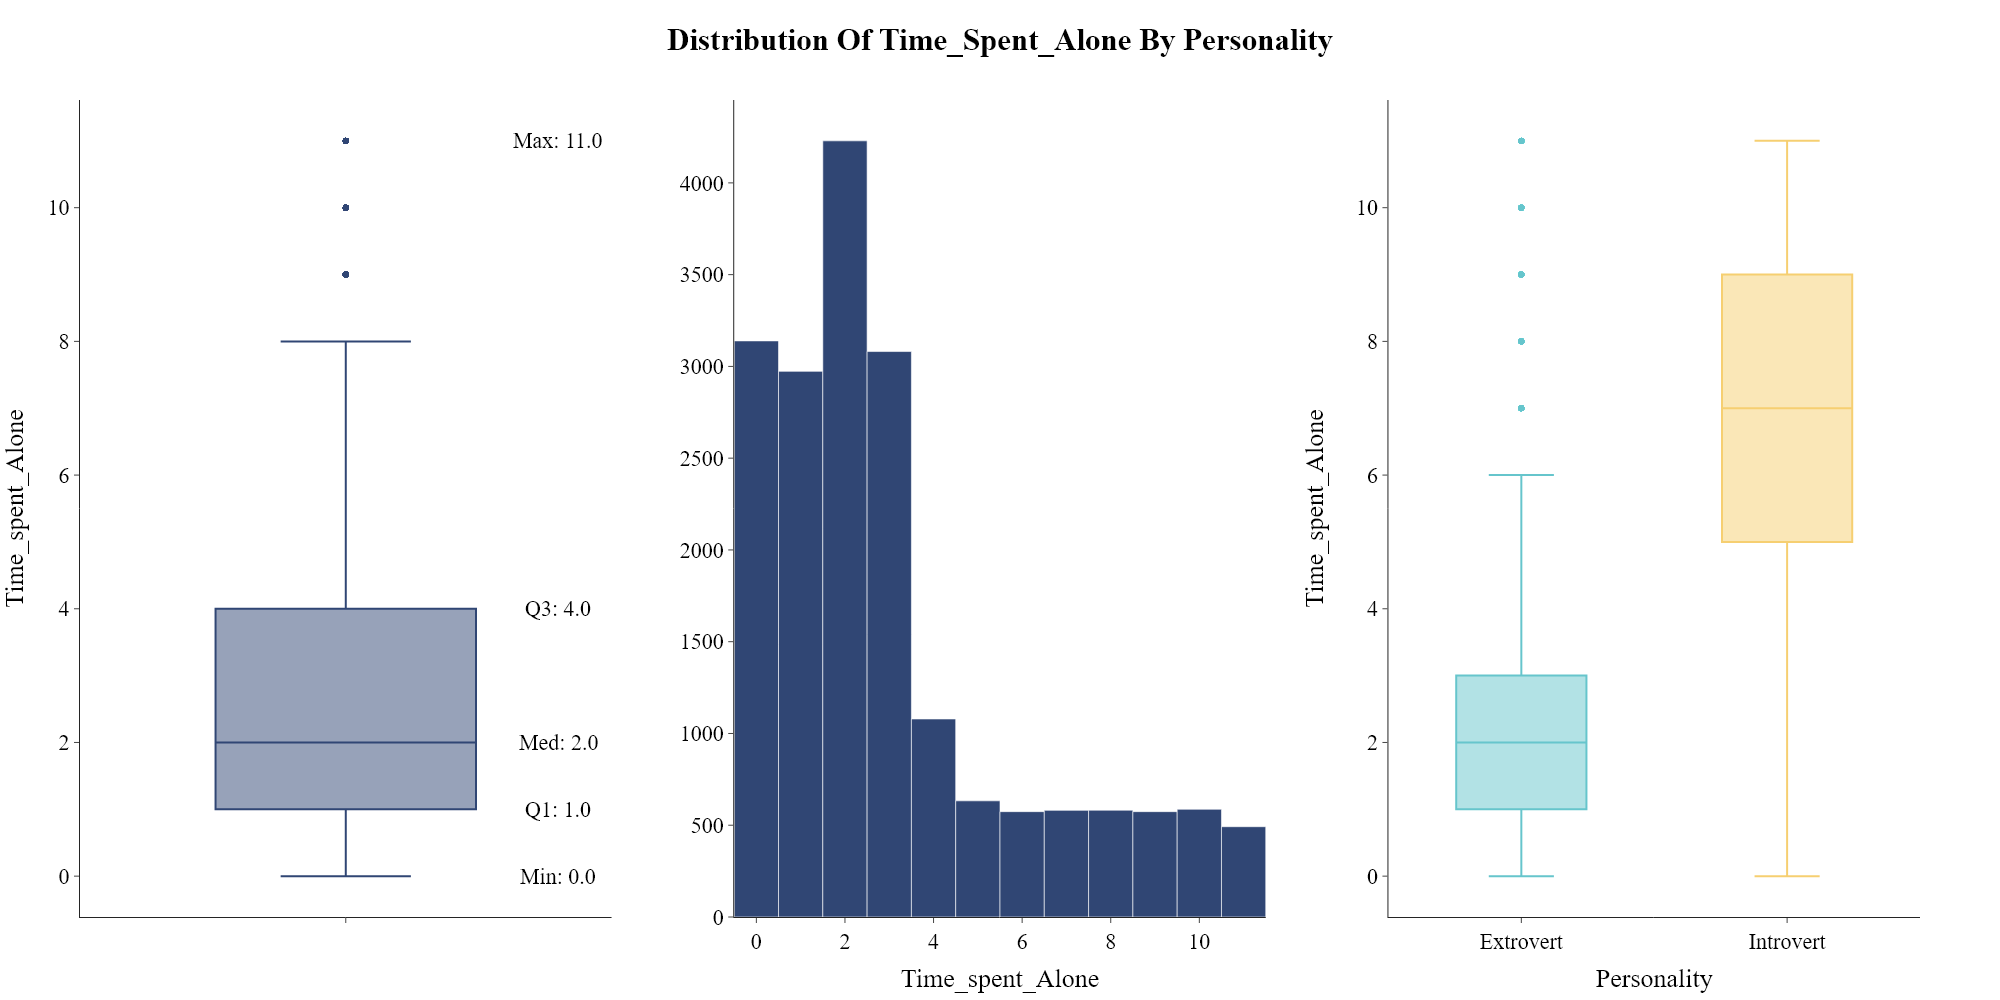

In [26]:
plots.boxplot_histogram_boxplot_by_hue(train_data, 'Time_spent_Alone', target_feature, annotations=["Min", "Q1", "Med", "Q3", "Max"], bin_size=1, plot_title=f"Distribution of Time_spent_Alone by {target_feature}")
describe_numerical_feature(train_data, 'Time_spent_Alone')

**Notes:**

**Conclusion:**
- Clear personality-based pattern: Introverts spend significantly more time alone (median ~7) vs Extroverts (median ~2).
- Strong predictive feature for personality classification with minimal overlap between groups.
- Consider creating binary features: time_alone_high (>5) and time_alone_low (< 3) for additional modeling insights.

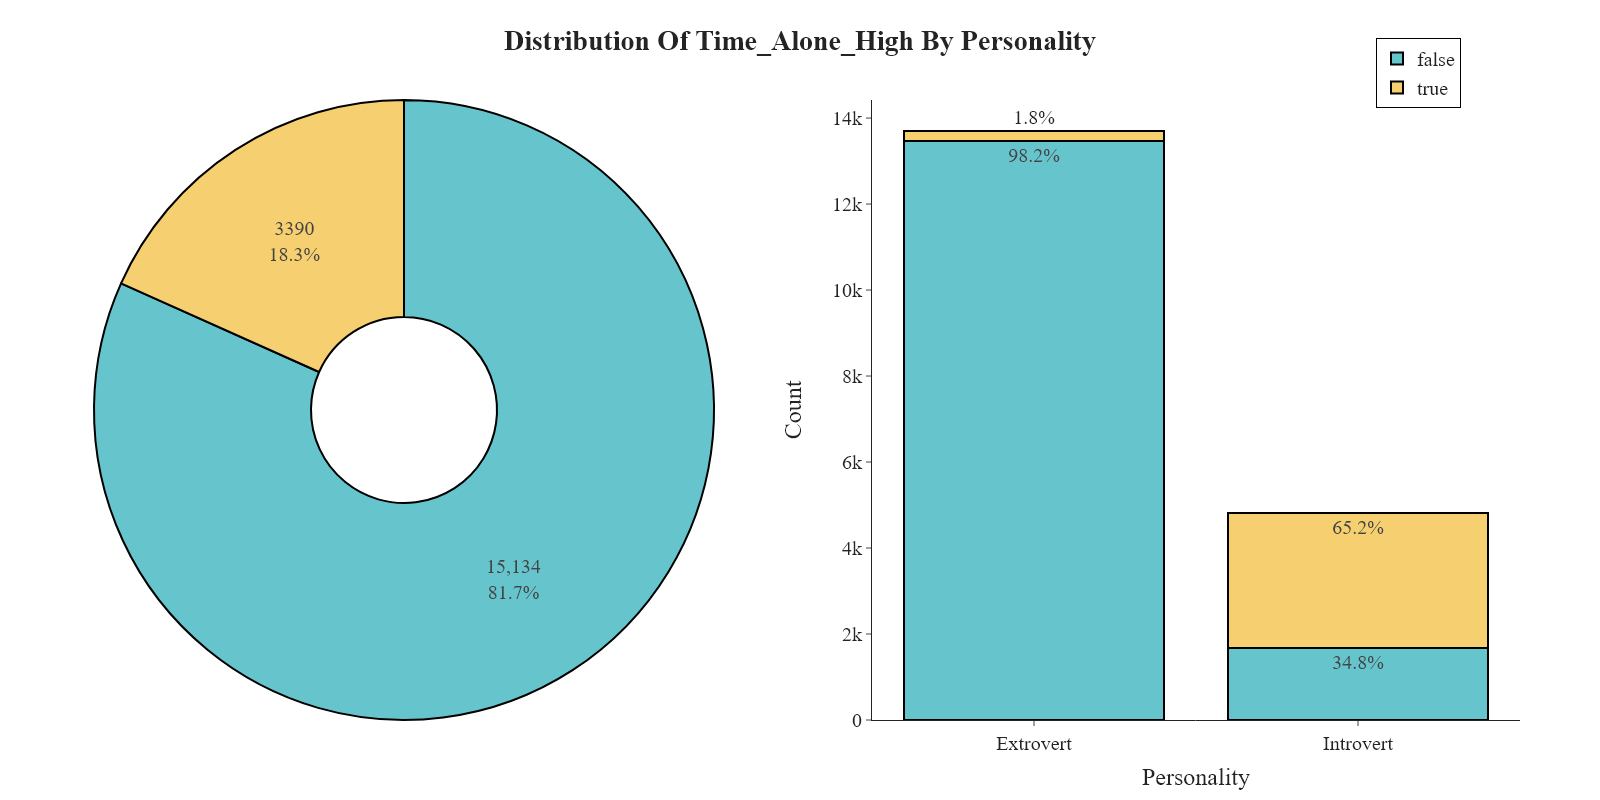

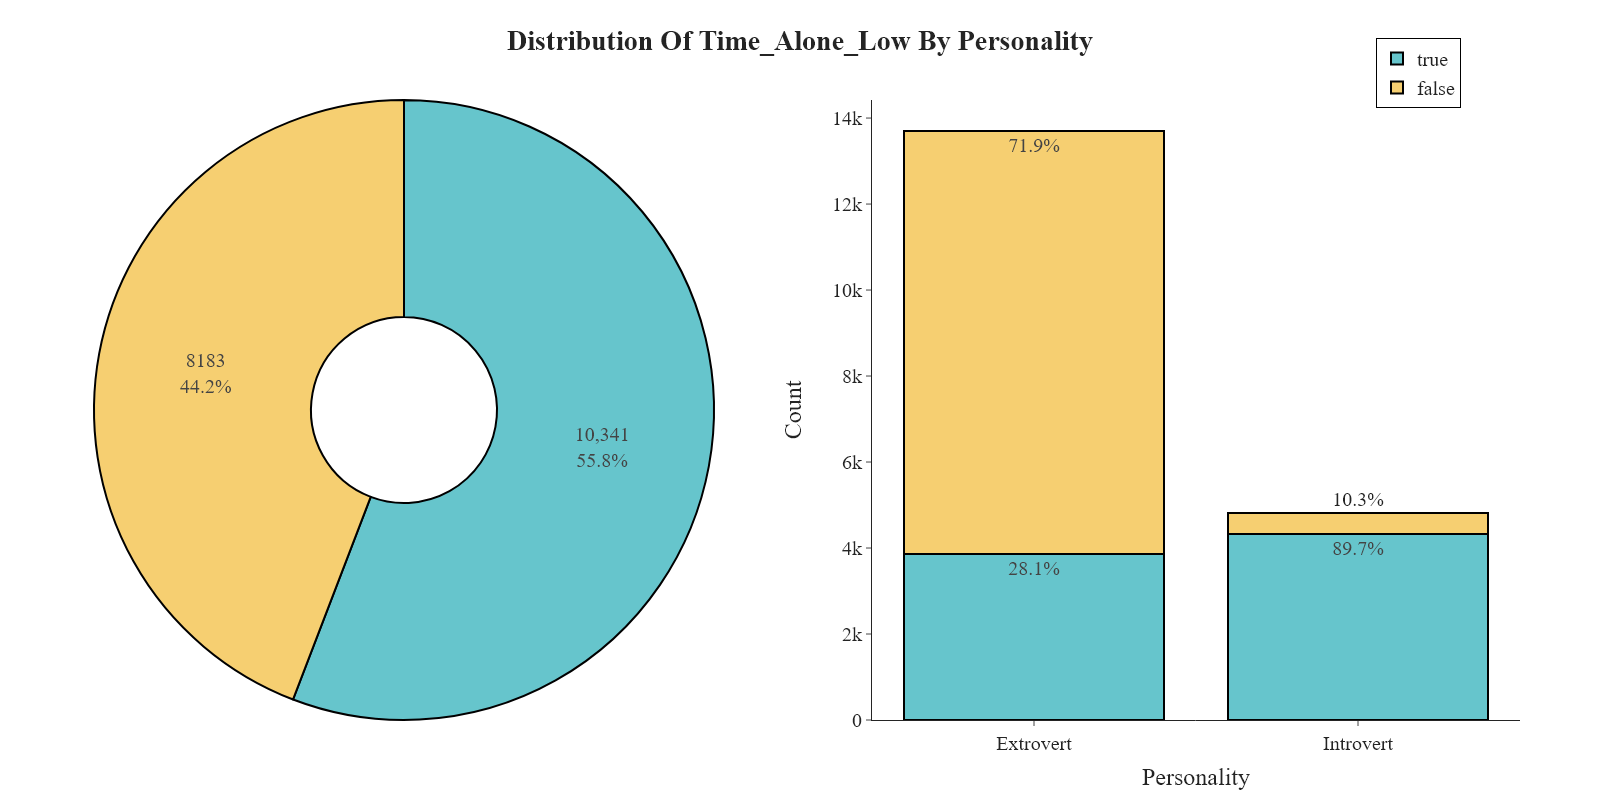

In [27]:
train_data['time_alone_high'] = (train_data['Time_spent_Alone'] > 5).astype("category")
train_data['time_alone_low'] = (train_data['Time_spent_Alone'] < 3).astype("category")
test_data['time_alone_high'] = (test_data['Time_spent_Alone'] > 5)
test_data['time_alone_high'] = pd.Categorical(test_data['time_alone_high'], categories=train_data['time_alone_high'].cat.categories)
test_data['time_alone_low'] = (test_data['Time_spent_Alone'] < 3)
test_data['time_alone_low'] = pd.Categorical(test_data['time_alone_low'], categories=train_data['time_alone_low'].cat.categories)
plots.pie_stacked_barplot_by_hue(train_data, 'time_alone_high', target_feature, plot_title=f"Distribution of time_alone_high by {target_feature}")
display(describe_categorical_feature(train_data, 'time_alone_high'))
plots.pie_stacked_barplot_by_hue(train_data, 'time_alone_low', target_feature, plot_title=f"Distribution of time_alone_low by {target_feature}")
display(describe_categorical_feature(train_data, 'time_alone_low'))

**Notes:**

## `Stage_fear`

`Stage_fear` (category) - Whether the person experiences anxiety or fear when performing or speaking in front of an audience (Yes/No/Unknown).

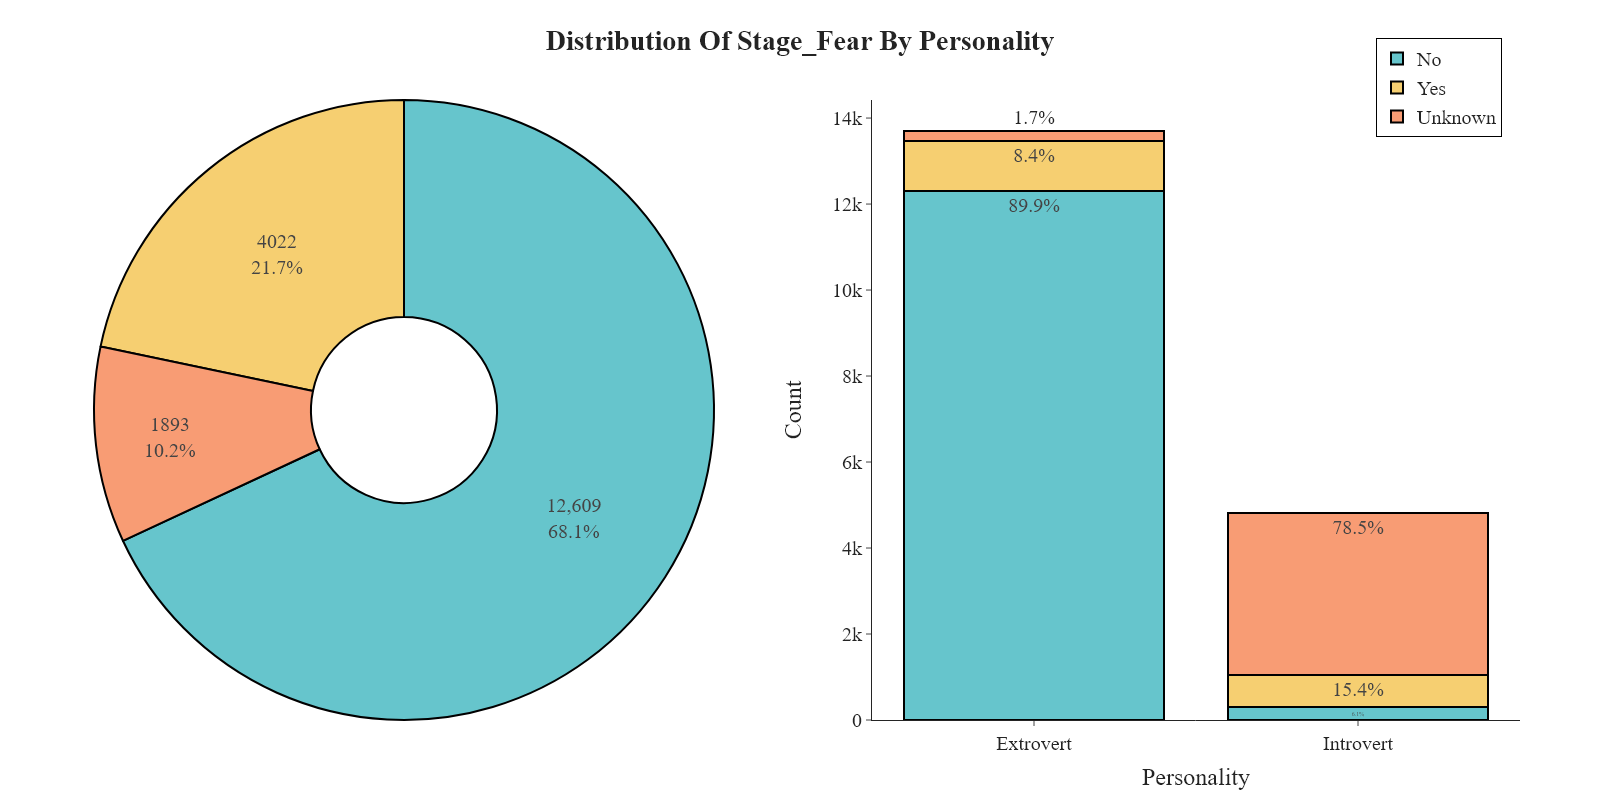

In [28]:
plots.pie_stacked_barplot_by_hue(train_data, 'Stage_fear', target_feature, plot_title=f"Distribution of Stage_fear by {target_feature}")
describe_categorical_feature(train_data, 'Stage_fear')

**Notes:**


## `Social_event_attendance`

`Social_event_attendance` (float64) - The frequency or preference level for attending social gatherings, parties, or group events, measured on a numerical scale.

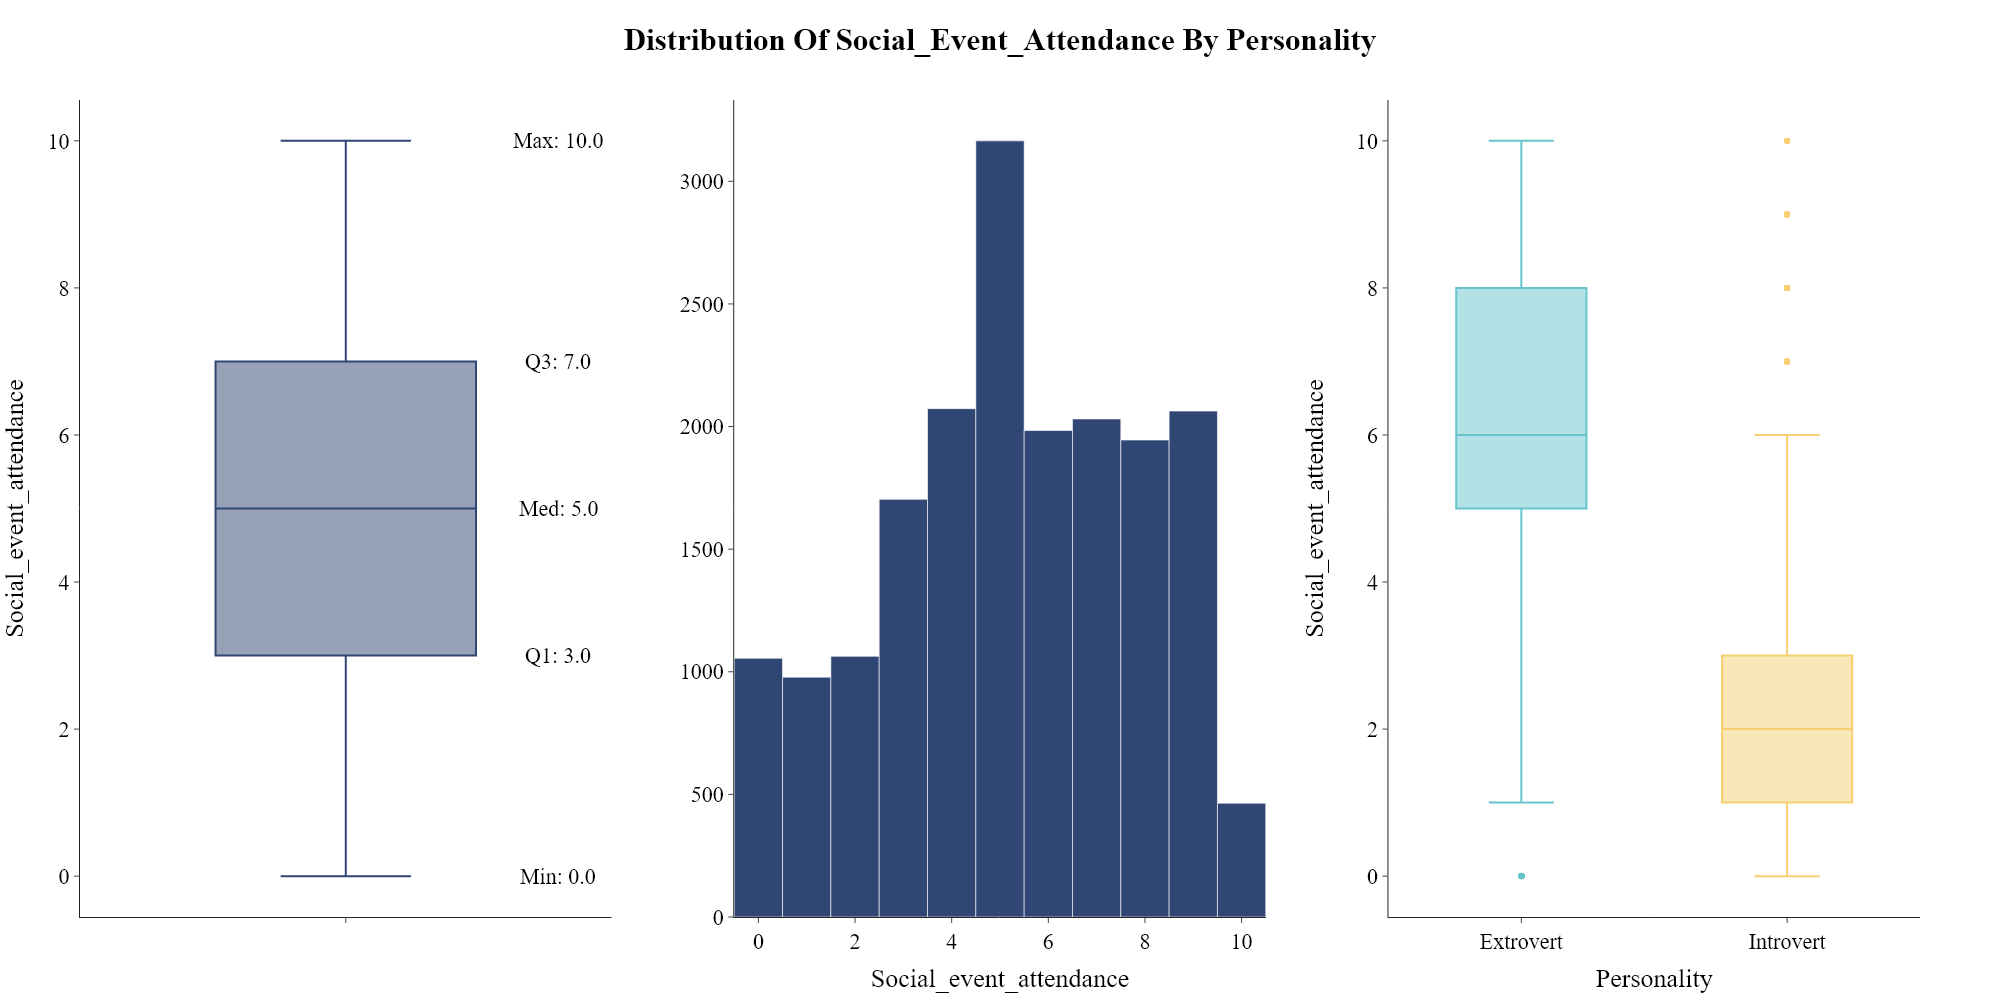

In [29]:
plots.boxplot_histogram_boxplot_by_hue(train_data, 'Social_event_attendance', target_feature, annotations=["Min", "Q1", "Med", "Q3", "Max"], bin_size=1, plot_title=f"Distribution of Social_event_attendance by {target_feature}")
describe_numerical_feature(train_data, 'Social_event_attendance')

**Notes:**

**Conclusion:**
- Clear separation: Extroverts show higher social event attendance (median ~6) vs Introverts (median ~2).
- Strong predictive feature with minimal overlap between personality groups.
- Create binary indicator: high_social_attendance (>5) to capture extroversion tendency.

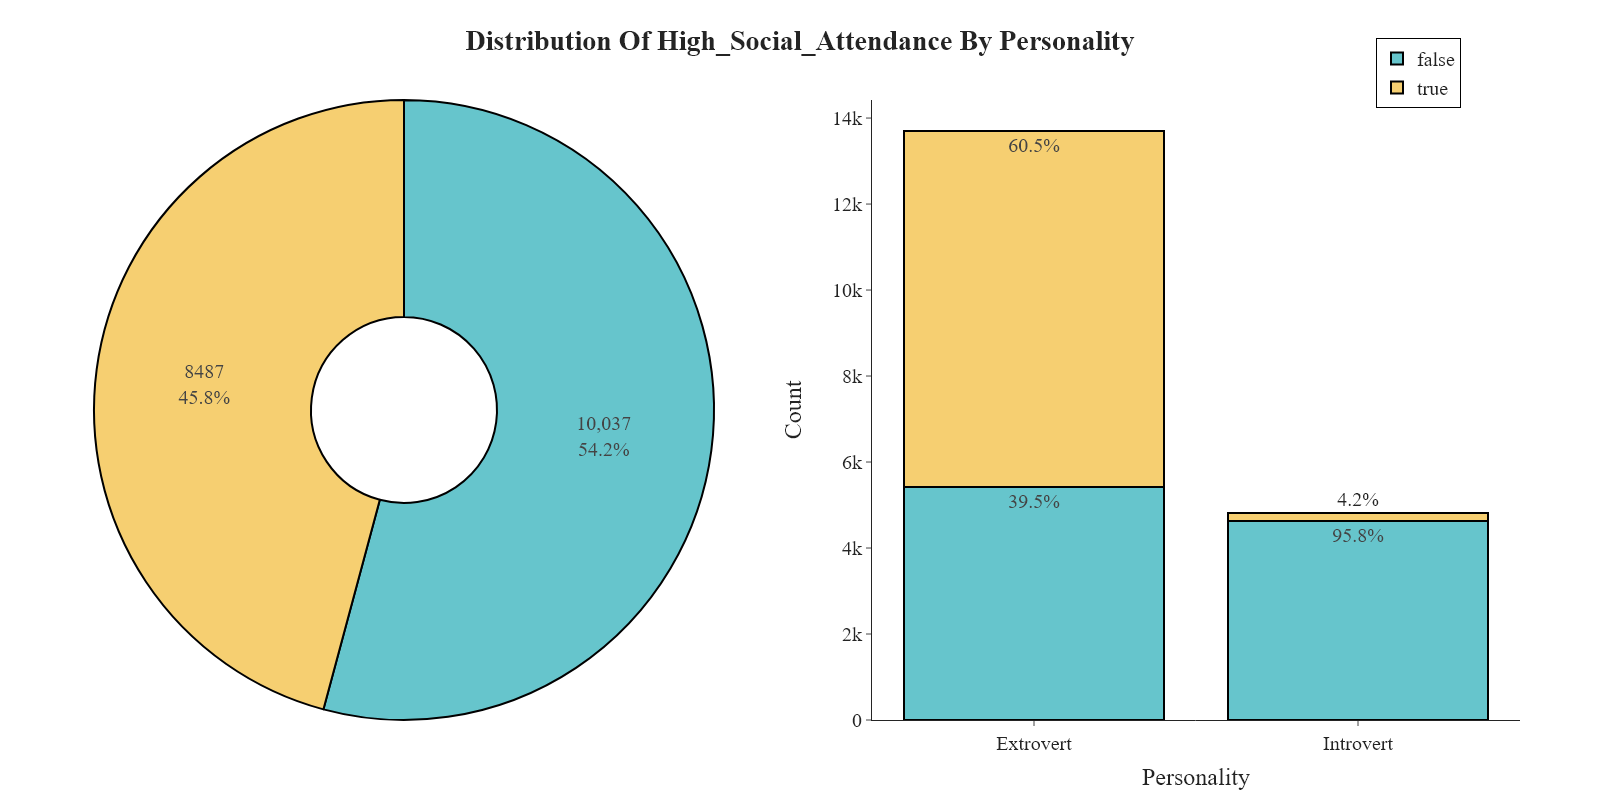

In [30]:
train_data['high_social_attendance'] = (train_data['Social_event_attendance'] > 5).astype("category")
test_data['high_social_attendance'] = (test_data['Social_event_attendance'] > 5)
test_data['high_social_attendance'] = pd.Categorical(test_data['high_social_attendance'], categories=train_data['high_social_attendance'].cat.categories)
plots.pie_stacked_barplot_by_hue(train_data, 'high_social_attendance', target_feature, plot_title=f"Distribution of high_social_attendance by {target_feature}")
describe_categorical_feature(train_data, 'high_social_attendance')

**Notes:**


## `Going_outside`

`Going_outside` (float64) - The frequency or preference for outdoor activities and leaving one's home environment, measured on a numerical scale.

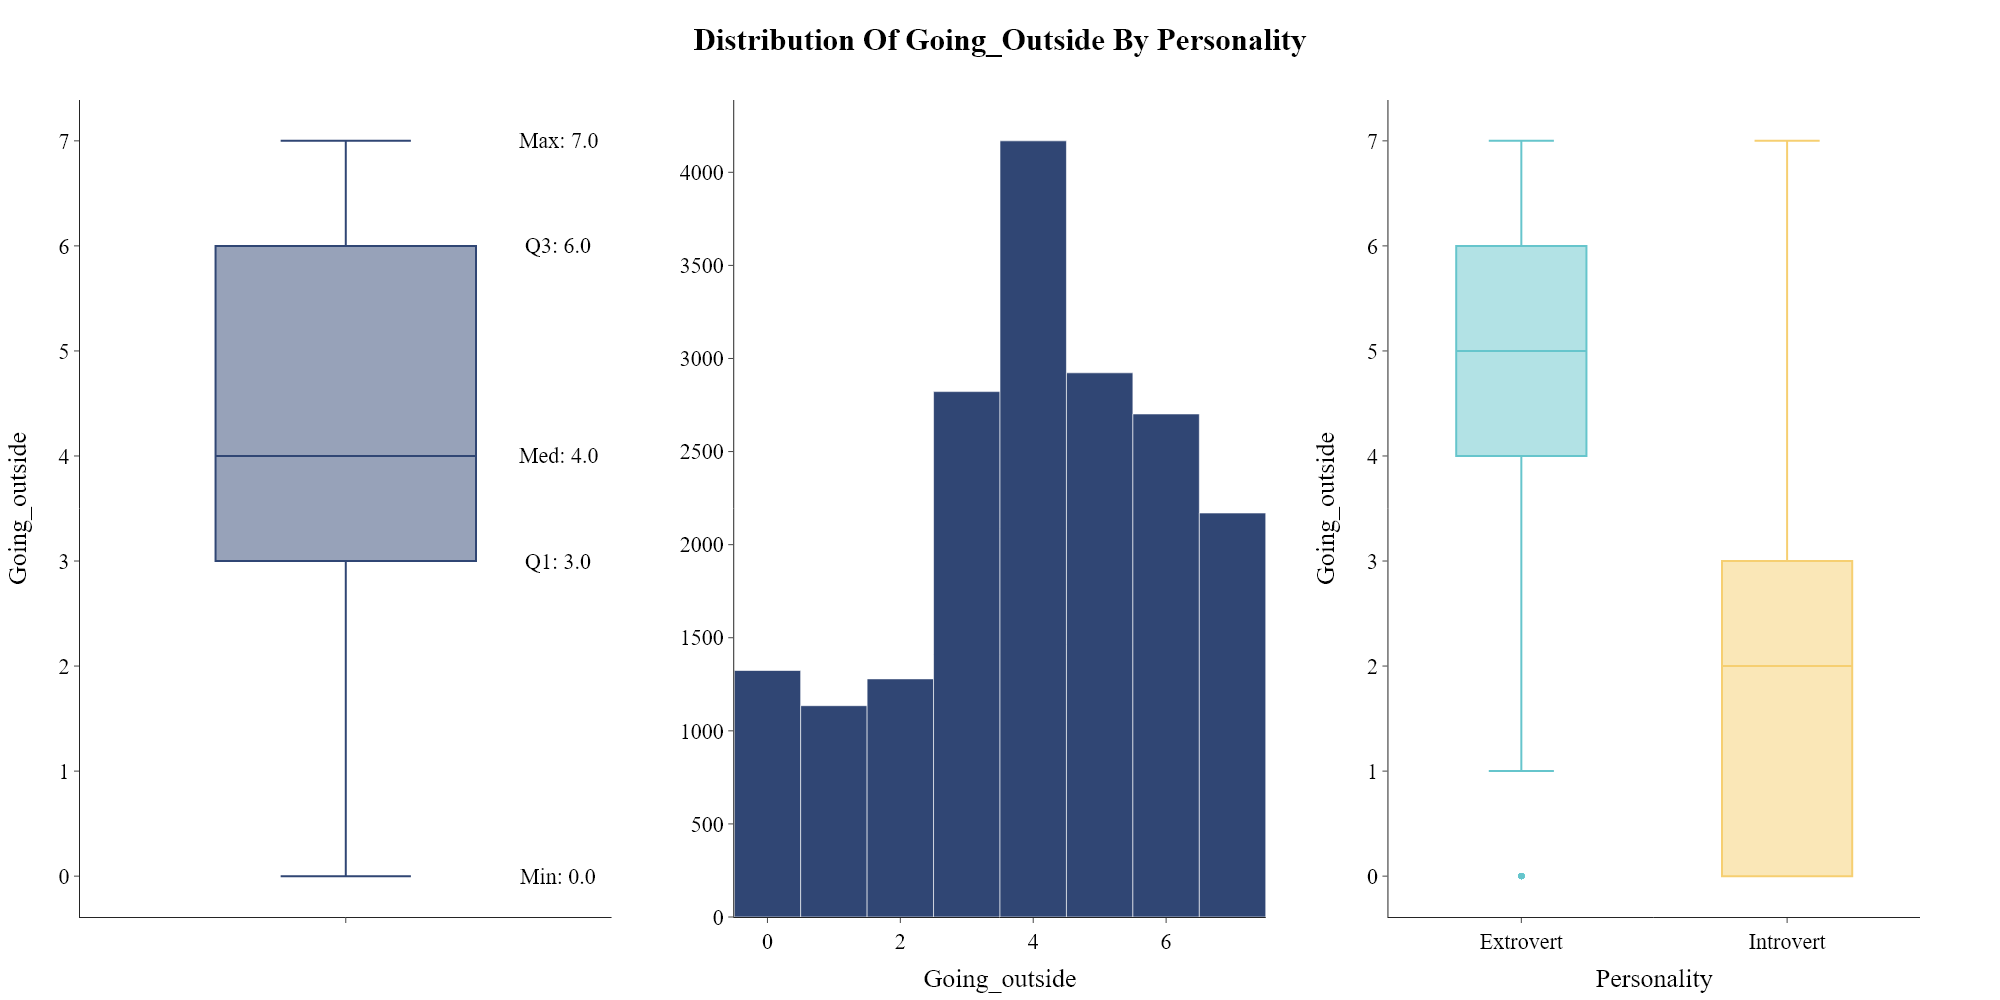

In [31]:
plots.boxplot_histogram_boxplot_by_hue(train_data, 'Going_outside', target_feature, annotations=["Min", "Q1", "Med", "Q3", "Max"], bin_size=1, plot_title=f"Distribution of Going_outside by {target_feature}")
describe_numerical_feature(train_data, 'Going_outside')

**Notes:**

**Conclusion:**
- Moderate personality differentiation: Extroverts show higher outdoor activity (median ~5) vs Introverts (median ~2).
- Feature shows predictive value but with more overlap than other social features.
- Create binary feature: frequent_outdoor (>4) to capture extroversion tendency.

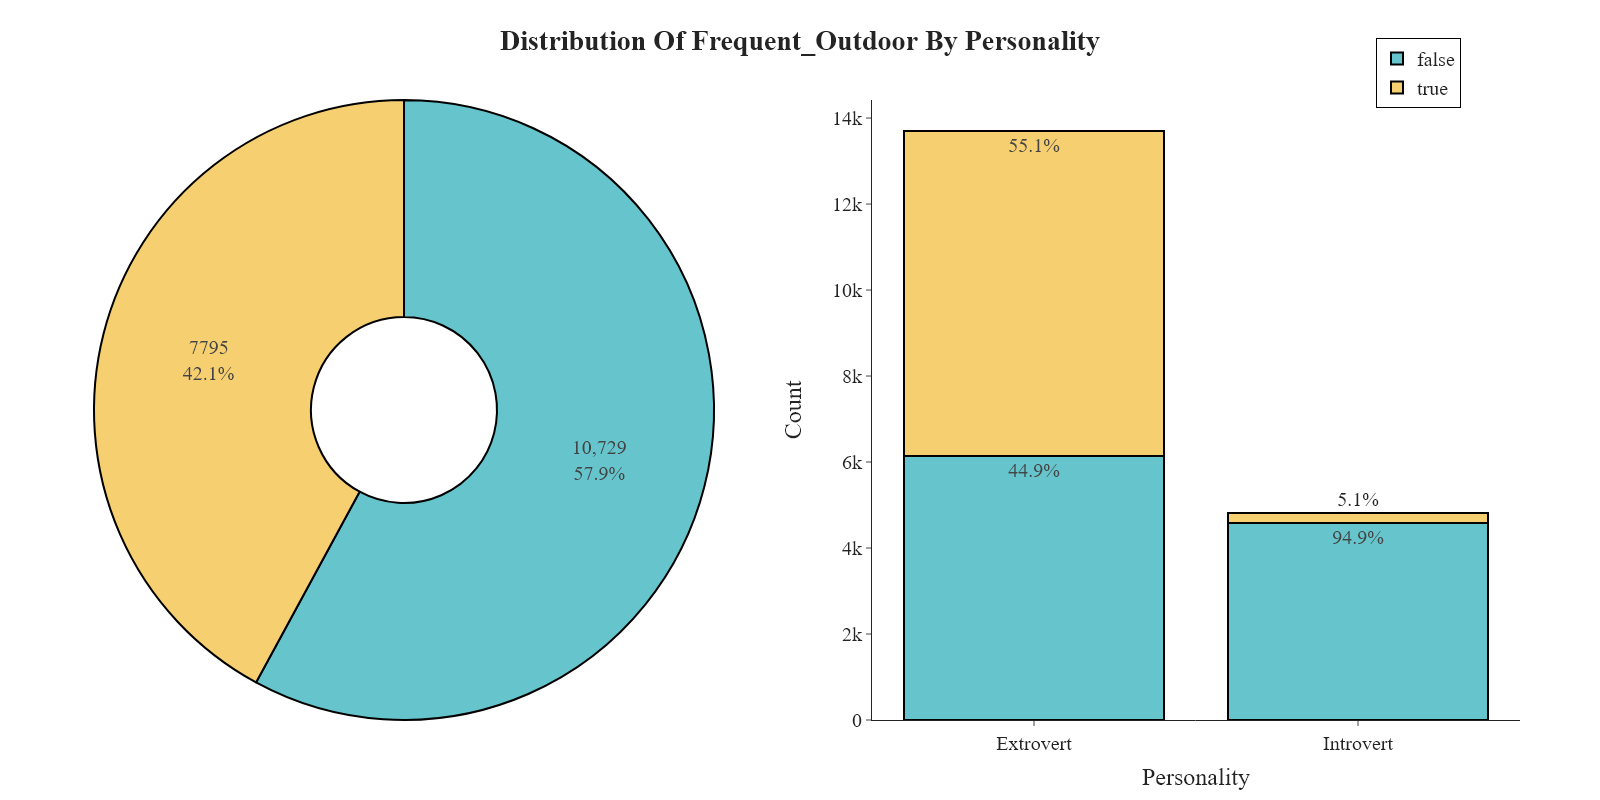

In [32]:
train_data['frequent_outdoor'] = (train_data['Going_outside'] > 4).astype("category")
test_data['frequent_outdoor'] = (test_data['Going_outside'] > 4)
test_data['frequent_outdoor'] = pd.Categorical(test_data['frequent_outdoor'], categories=train_data['frequent_outdoor'].cat.categories)
plots.pie_stacked_barplot_by_hue(train_data, 'frequent_outdoor', target_feature, plot_title=f"Distribution of frequent_outdoor by {target_feature}")
describe_categorical_feature(train_data, 'frequent_outdoor')

**Notes:**


## `Drained_after_socializing`

`Drained_after_socializing` (category) - Whether the person feels emotionally or physically drained after social interactions (Yes/No/Unknown).

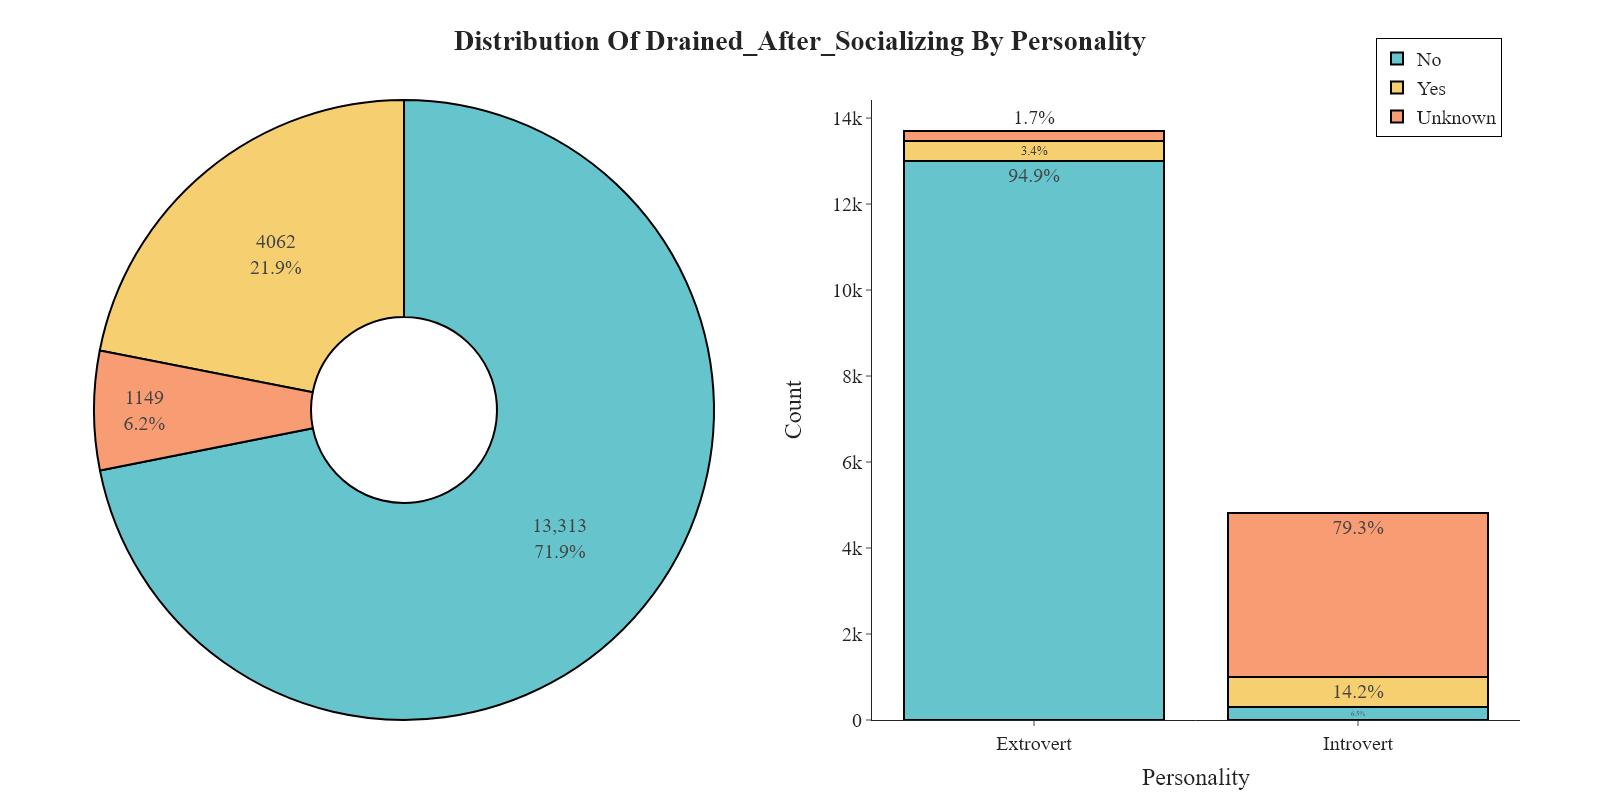

In [33]:
plots.pie_stacked_barplot_by_hue(train_data, 'Drained_after_socializing', target_feature, plot_title=f"Distribution of Drained_after_socializing by {target_feature}")
describe_categorical_feature(train_data, 'Drained_after_socializing')

**Notes:**


## `Friends_circle_size`

`Friends_circle_size` (float64) - The number of close friends or the size of one's social network, measured numerically.

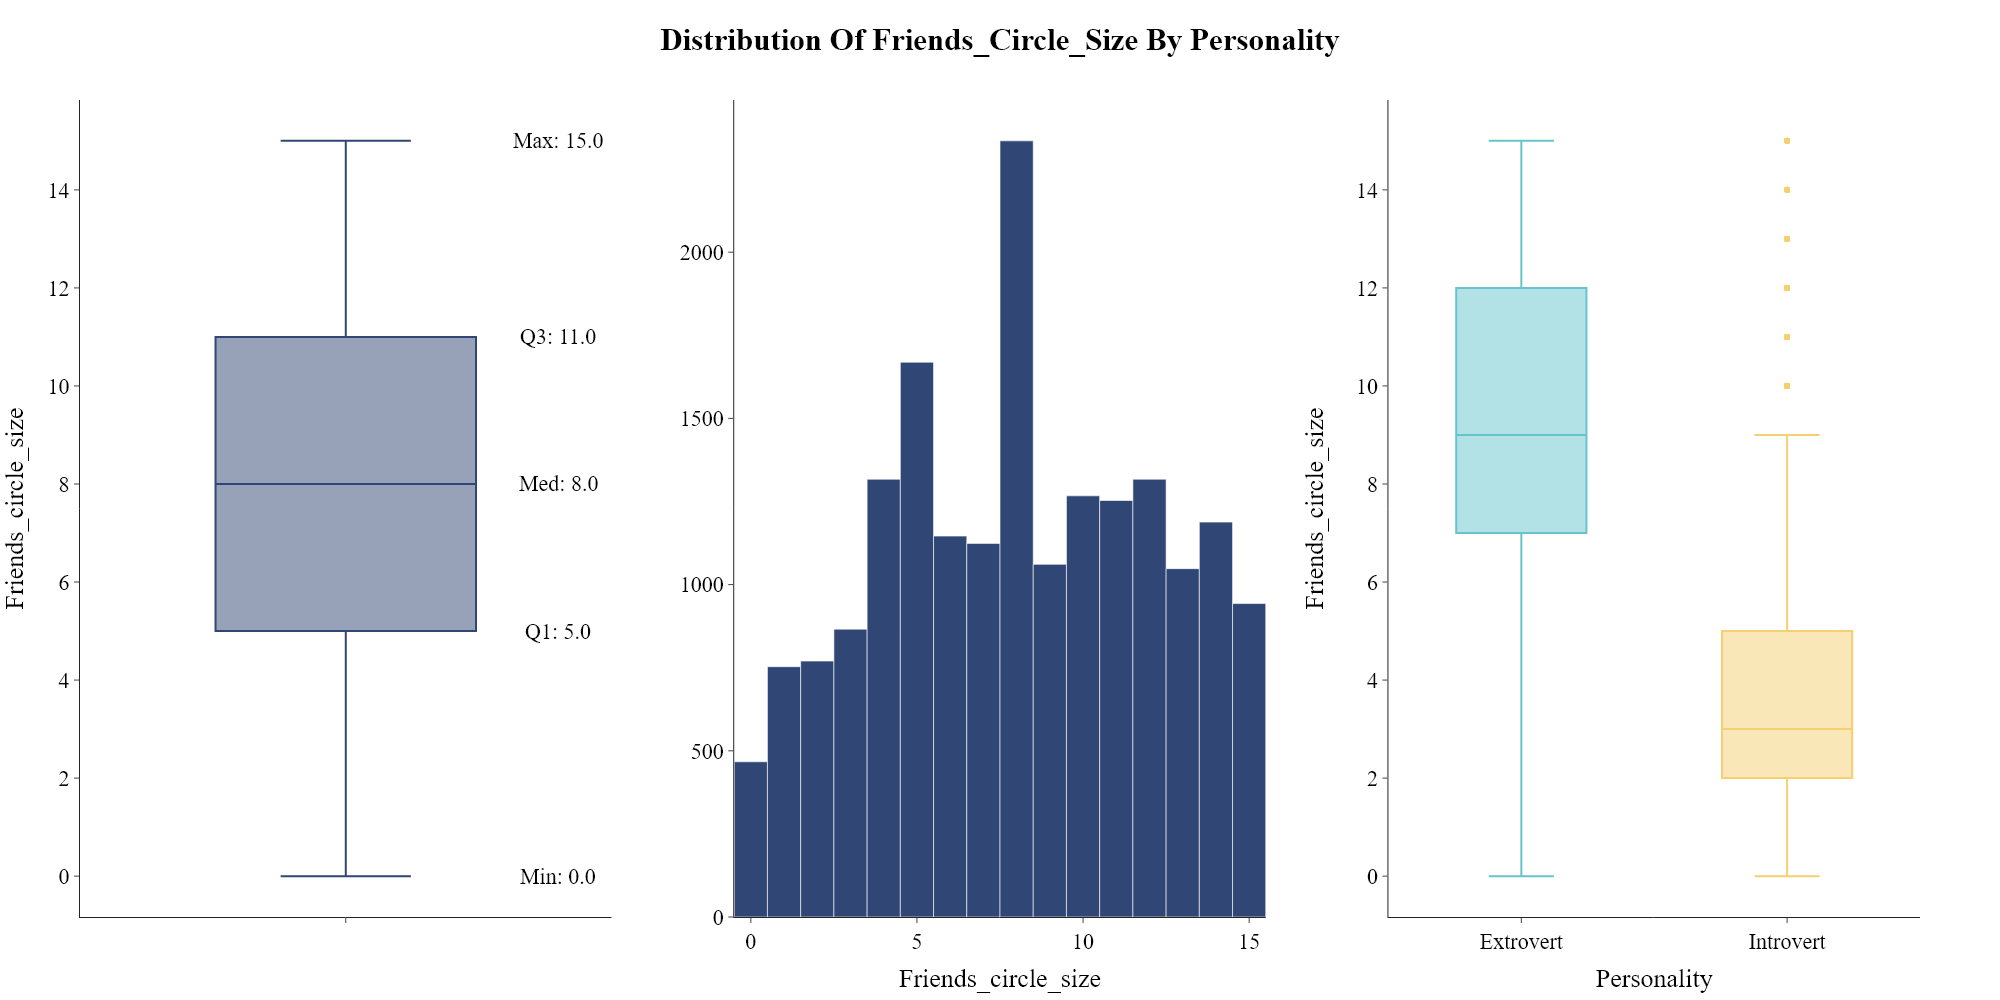

In [34]:
plots.boxplot_histogram_boxplot_by_hue(train_data, 'Friends_circle_size', target_feature, annotations=["Min", "Q1", "Med", "Q3", "Max"], bin_size=1, plot_title=f"Distribution of Friends_circle_size by {target_feature}")
describe_numerical_feature(train_data, 'Friends_circle_size')

**Notes:**

**Conclusion:**
- Clear personality differentiation: Extroverts have larger friend circles (median ~9) vs Introverts (median ~3).
- Strong predictive feature with distinct distributions between personality types.
- Create binary feature: large_friend_circle (>7) to capture extroversion tendency.

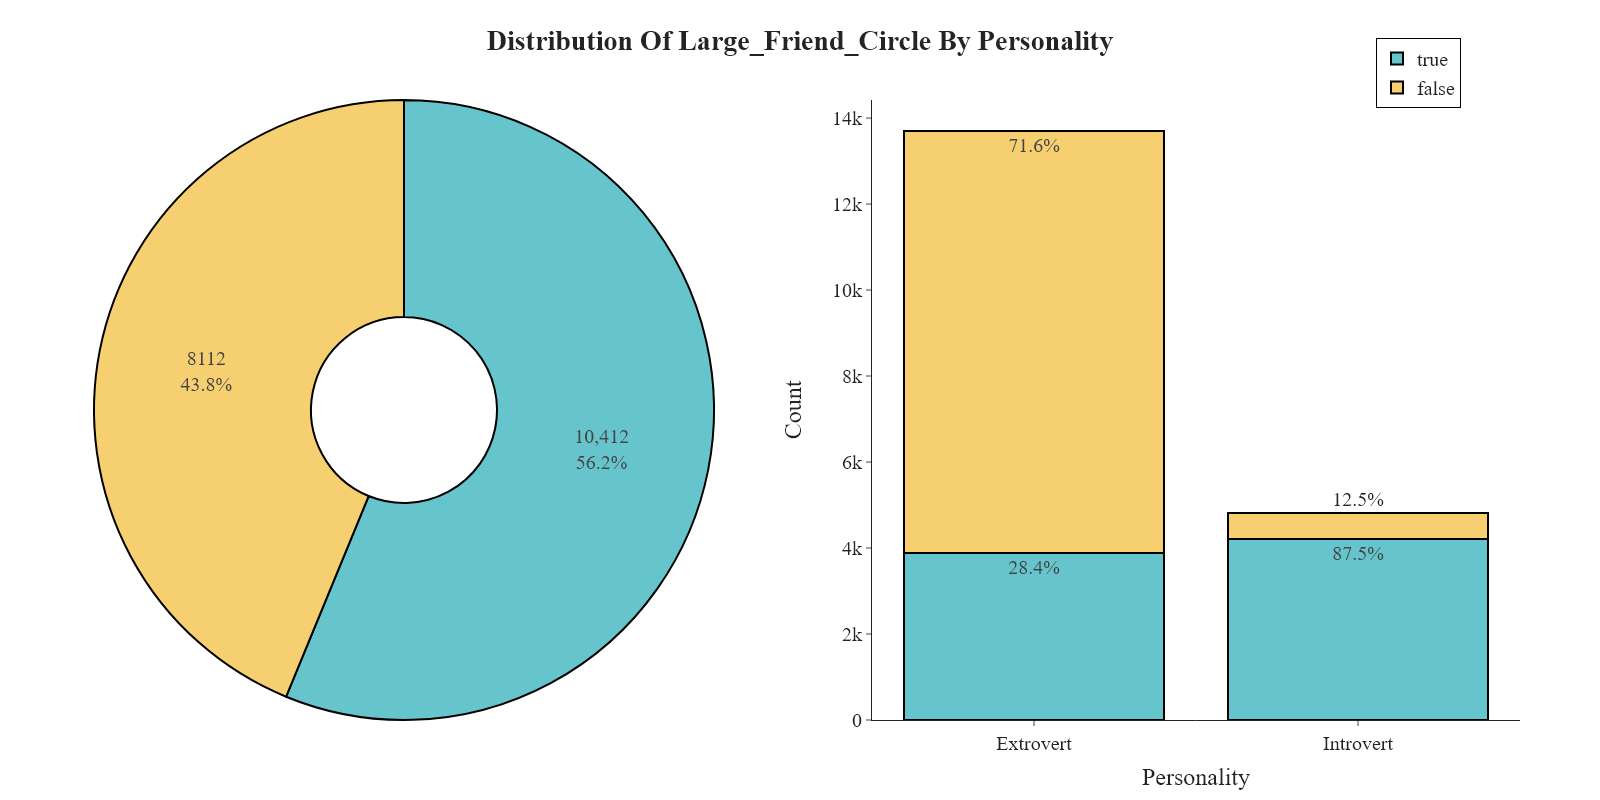

In [35]:
train_data['large_friend_circle'] = (train_data['Friends_circle_size'] > 7).astype("category")
test_data['large_friend_circle'] = (test_data['Friends_circle_size'] > 7)
test_data['large_friend_circle'] = pd.Categorical(test_data['large_friend_circle'], categories=train_data['large_friend_circle'].cat.categories)
plots.pie_stacked_barplot_by_hue(train_data, 'large_friend_circle', target_feature, plot_title=f"Distribution of large_friend_circle by {target_feature}")
describe_categorical_feature(train_data, 'large_friend_circle')

**Notes:**


## `Post_frequency`

`Post_frequency` (float64) - How often the person posts content on social media platforms, measured on a frequency scale.

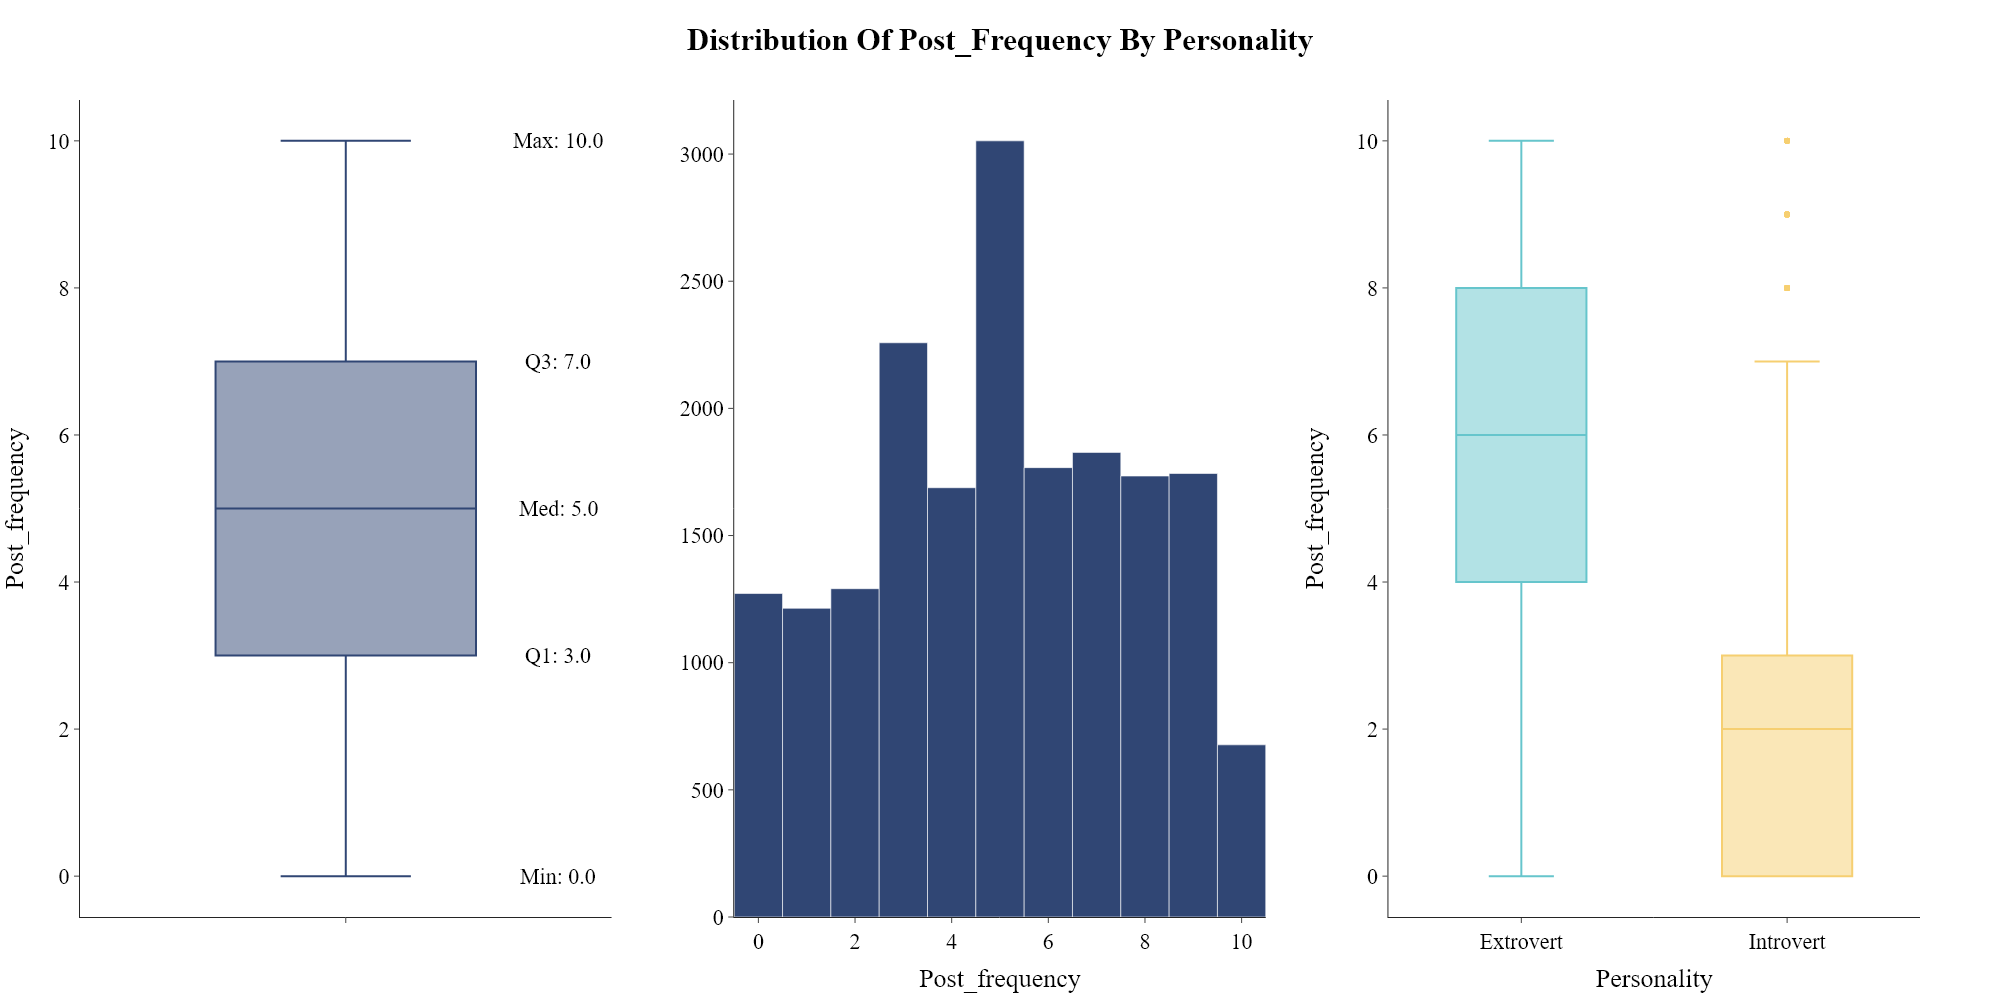

In [36]:
plots.boxplot_histogram_boxplot_by_hue(train_data, 'Post_frequency', target_feature, annotations=["Min", "Q1", "Med", "Q3", "Max"], bin_size=1, plot_title=f"Distribution of Post_frequency by {target_feature}")
describe_numerical_feature(train_data, 'Post_frequency')

**Notes:**

**Conclusion:**
- Moderate personality differentiation: Extroverts post more frequently (median ~6) vs Introverts (median ~2).
- Feature shows predictive value with clear but overlapping distributions.
- Create binary feature: frequent_poster (>5) to capture extroversion tendency in social media behavior.

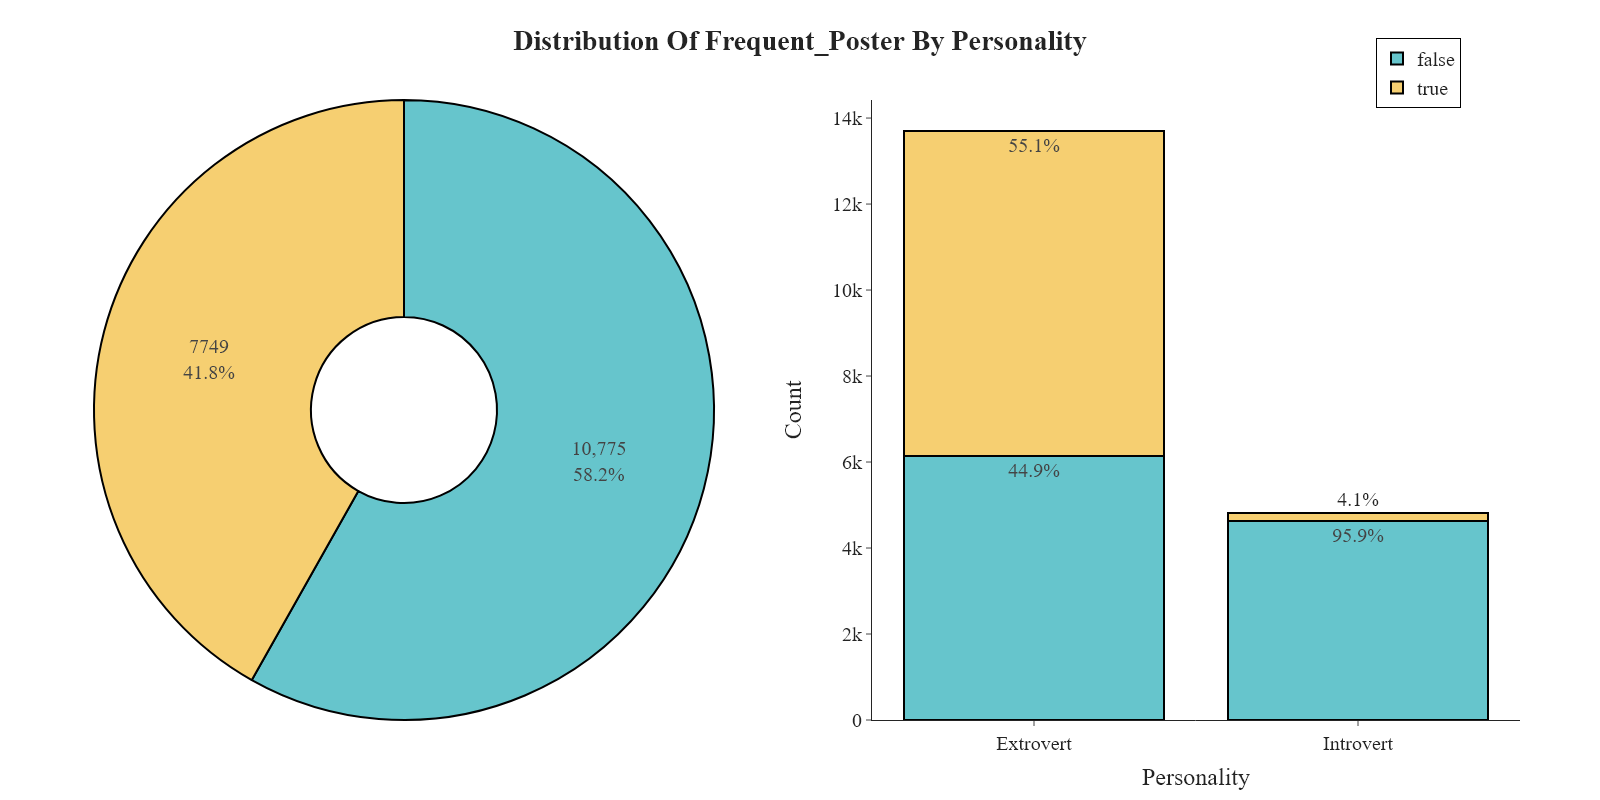

In [37]:
train_data['frequent_poster'] = (train_data['Post_frequency'] > 5).astype("category")
test_data['frequent_poster'] = (test_data['Post_frequency'] > 5)
test_data['frequent_poster'] = pd.Categorical(test_data['frequent_poster'], categories=train_data['frequent_poster'].cat.categories)
plots.pie_stacked_barplot_by_hue(train_data, 'frequent_poster', target_feature, plot_title=f"Distribution of frequent_poster by {target_feature}")
describe_categorical_feature(train_data, 'frequent_poster')

**Notes:**


In [38]:
train_scores, validation_scores = perform_cv(train_data[list(set(train_data.columns) - {target_feature})], train_data[target_feature], model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9701 +- 0.0007
Validation Accuracy: 0.9690 +- 0.0025


# Advanced Feature Engineering

In this section, we'll create sophisticated feature interactions and composite features based on the EDA insights and domain knowledge about introversion-extroversion psychology.

## Social Interaction Composite Score

**Motivation:** From EDA, we observed that social behaviors (social event attendance, friend circle size, and posting frequency) all correlate with extroversion. A composite score can capture the overall social engagement pattern better than individual features.

**Approach:** Create a weighted social interaction score combining normalized values of social behaviors.

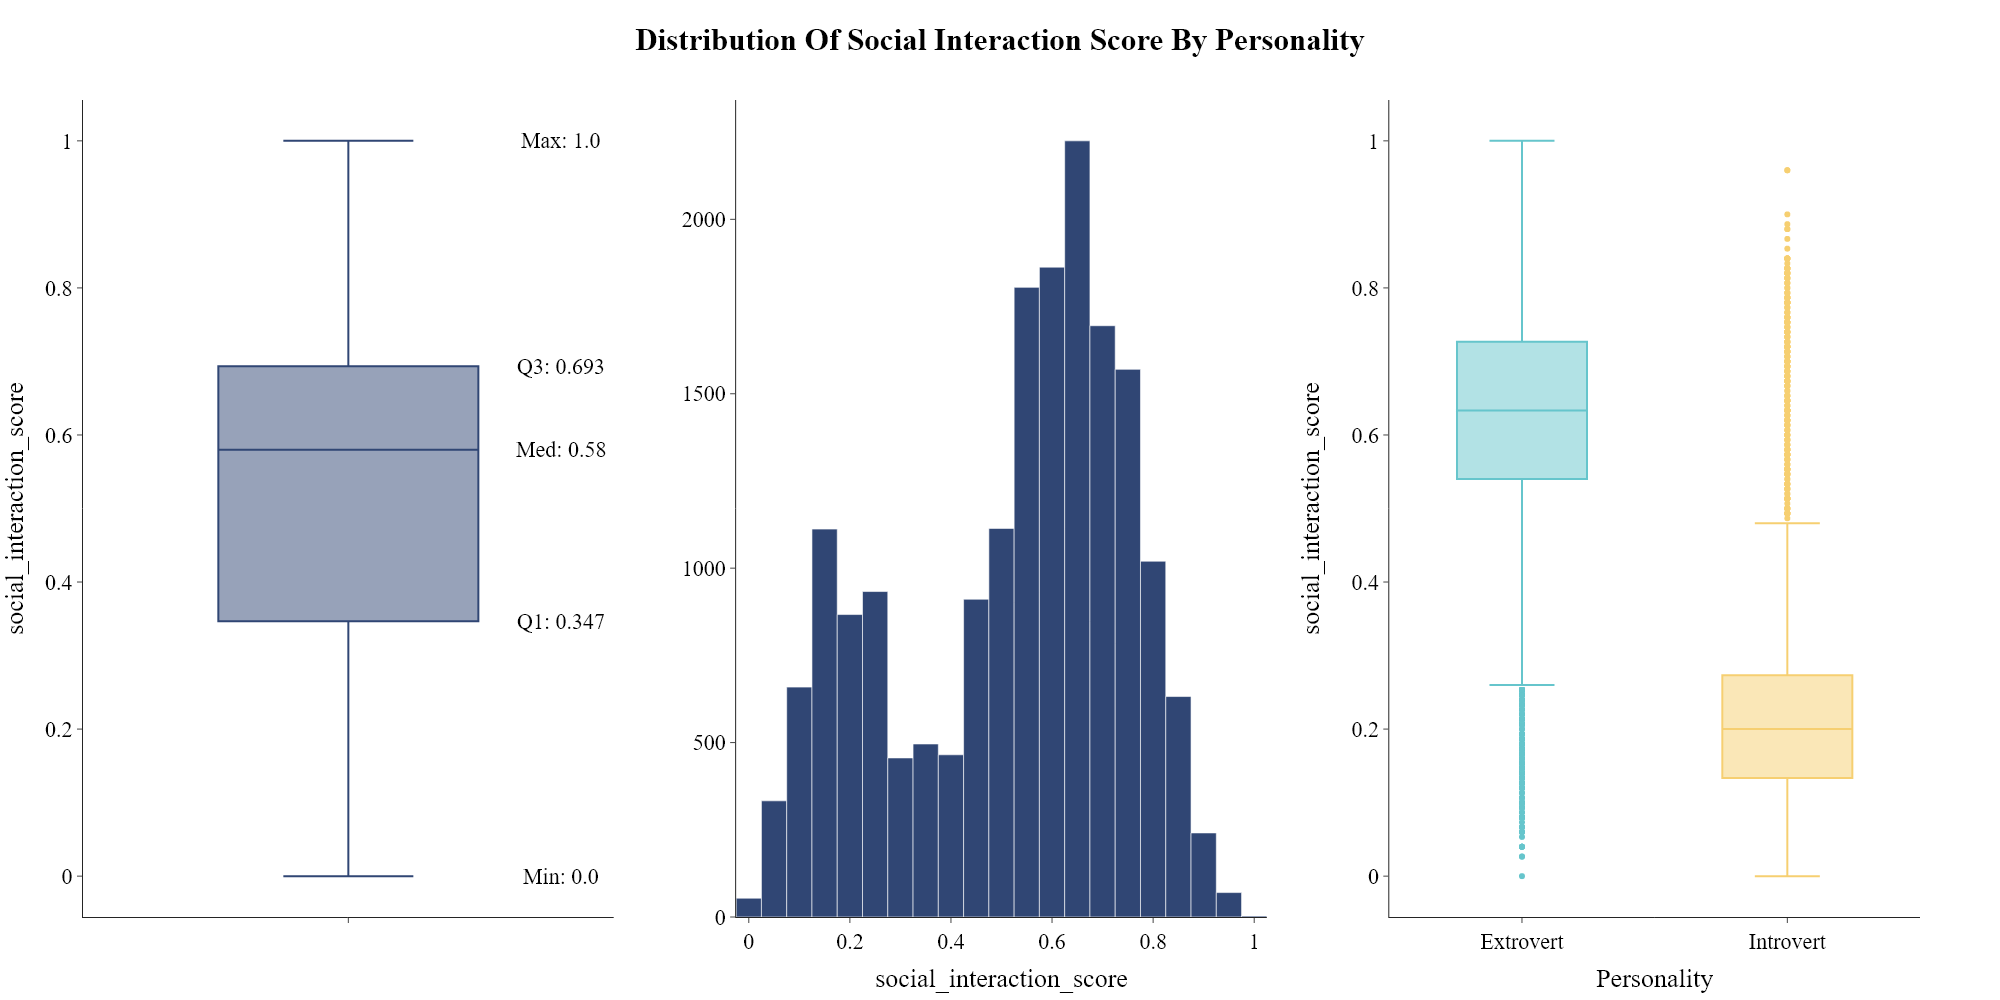

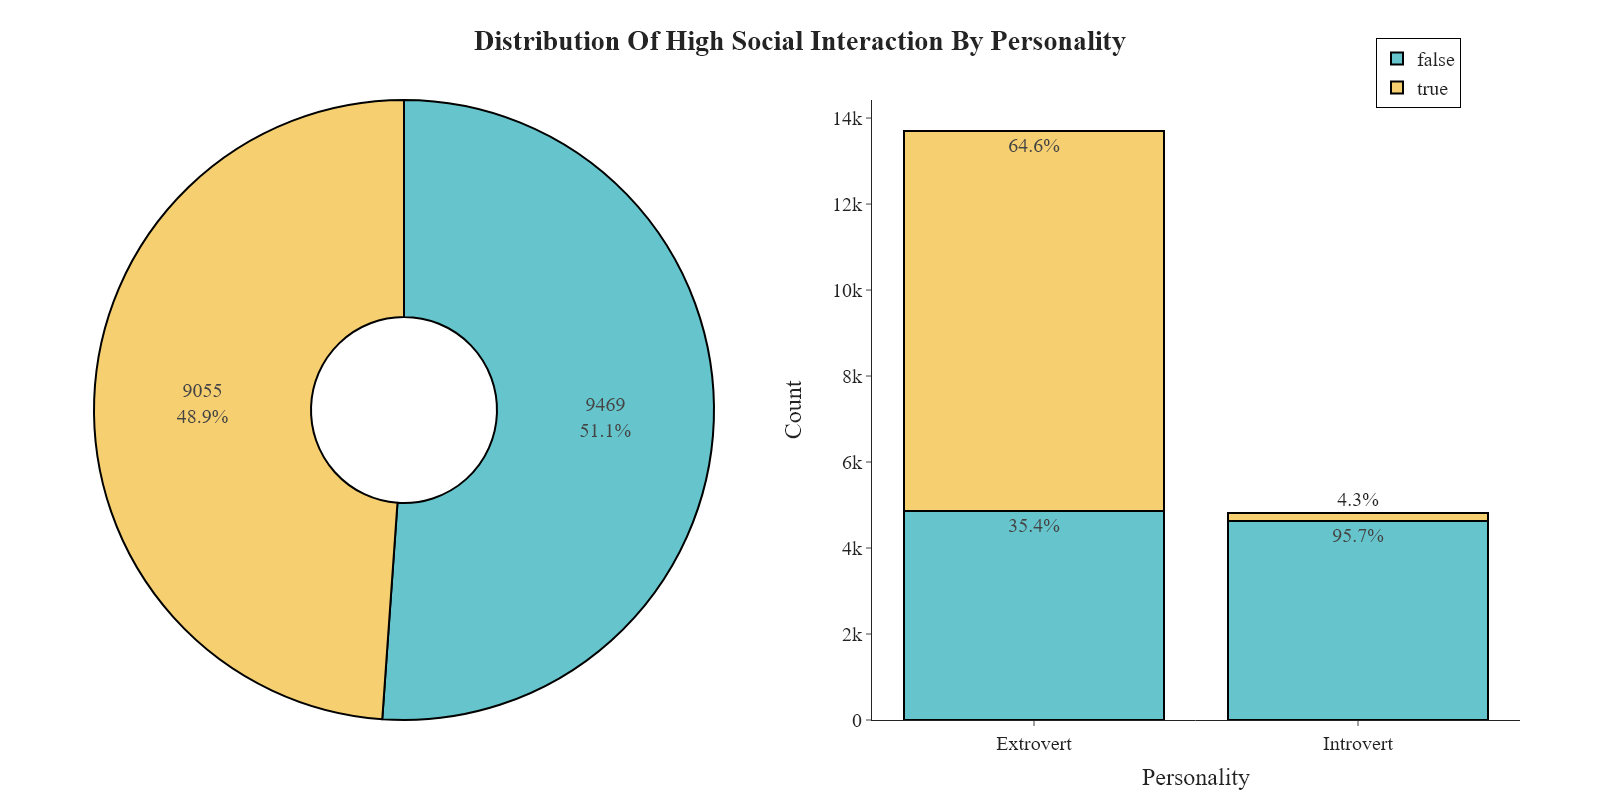

In [39]:
social_features = ['Social_event_attendance', 'Friends_circle_size', 'Post_frequency']
scaler = MinMaxScaler()

train_social_normalized = scaler.fit_transform(train_data[social_features])
test_social_normalized = scaler.transform(test_data[social_features])

train_data['social_interaction_score'] = (
    train_social_normalized[:, 0] * 0.4 +
    train_social_normalized[:, 1] * 0.4 +
    train_social_normalized[:, 2] * 0.2
)

test_data['social_interaction_score'] = (
    test_social_normalized[:, 0] * 0.4 +
    test_social_normalized[:, 1] * 0.4 +
    test_social_normalized[:, 2] * 0.2
)

train_data['high_social_interaction'] = (train_data['social_interaction_score'] > train_data['social_interaction_score'].median()).astype("category")
test_data['high_social_interaction'] = (test_data['social_interaction_score'] > train_data['social_interaction_score'].median())
test_data['high_social_interaction'] = pd.Categorical(test_data['high_social_interaction'], categories=train_data['high_social_interaction'].cat.categories)

plots.boxplot_histogram_boxplot_by_hue(train_data, 'social_interaction_score', target_feature, bin_size=0.05, annotations=["Min", "Q1", "Med", "Q3", "Max"], plot_title=f"Distribution of Social Interaction Score by {target_feature}")
display(describe_numerical_feature(train_data, 'social_interaction_score'))
plots.pie_stacked_barplot_by_hue(train_data, 'high_social_interaction', target_feature, plot_title=f"Distribution of High Social Interaction by {target_feature}")
display(describe_categorical_feature(train_data, 'high_social_interaction'))

**Notes:**


## Social Energy Depletion Interaction

**Motivation:** From psychology research, introverts get drained by social activities while extroverts get energized. The interaction between social activity and feeling drained afterward should be highly predictive.

**Approach:** Create interaction features between social behaviors and the "Drained_after_socializing" variable.

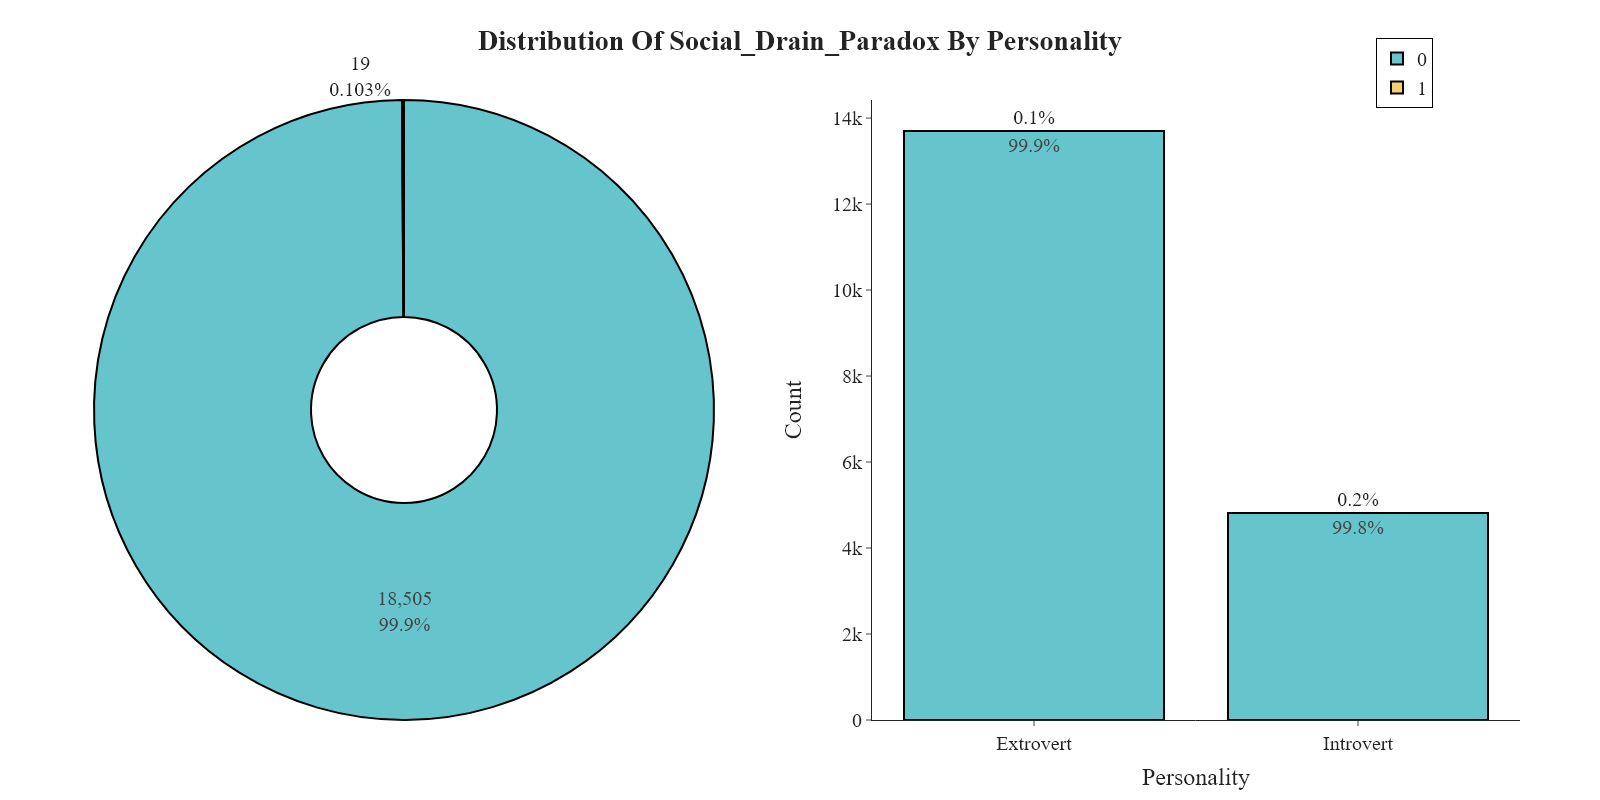

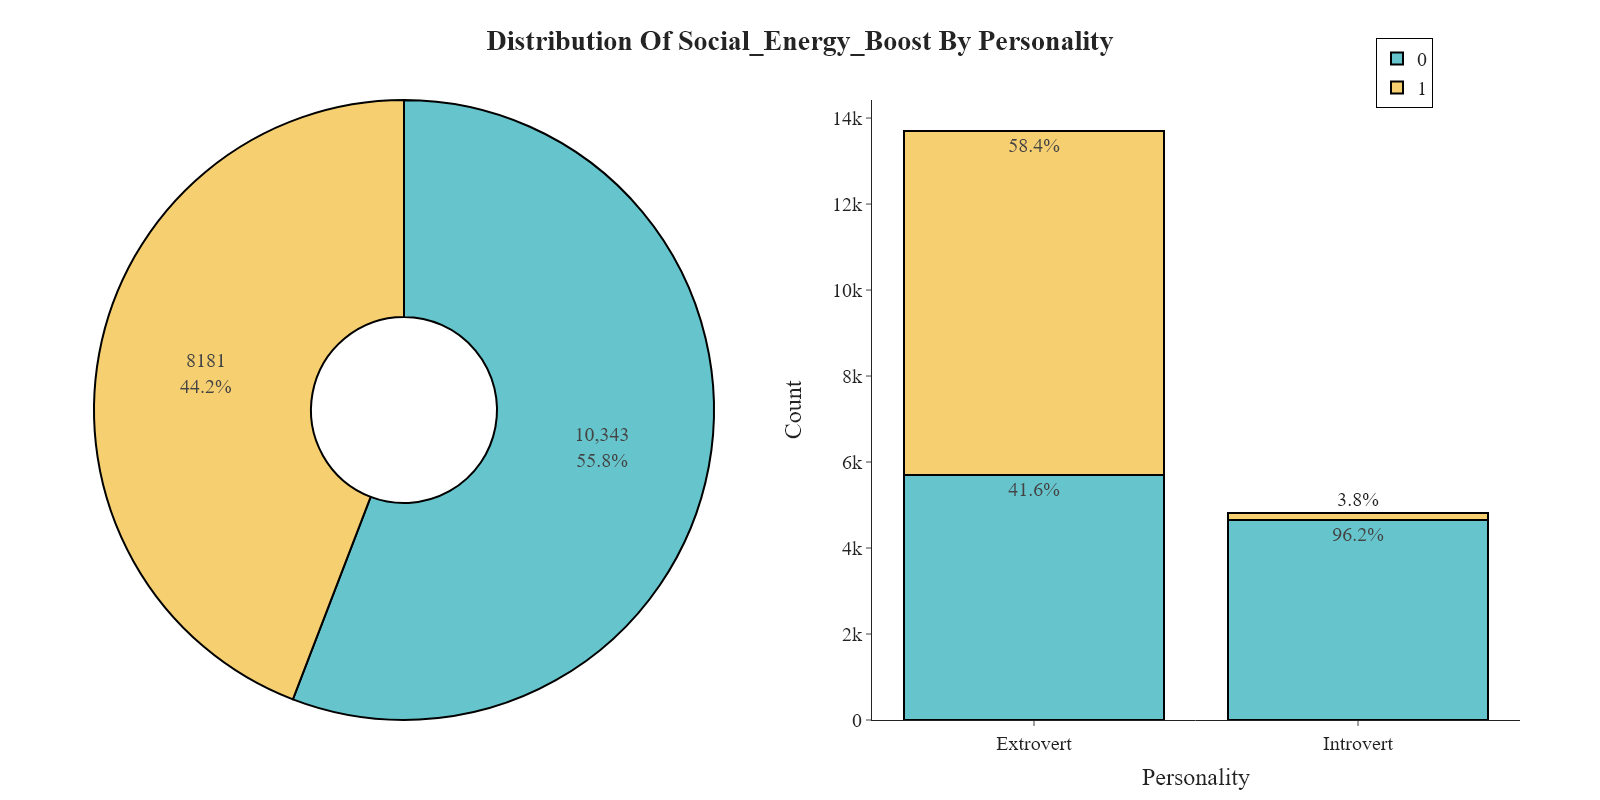

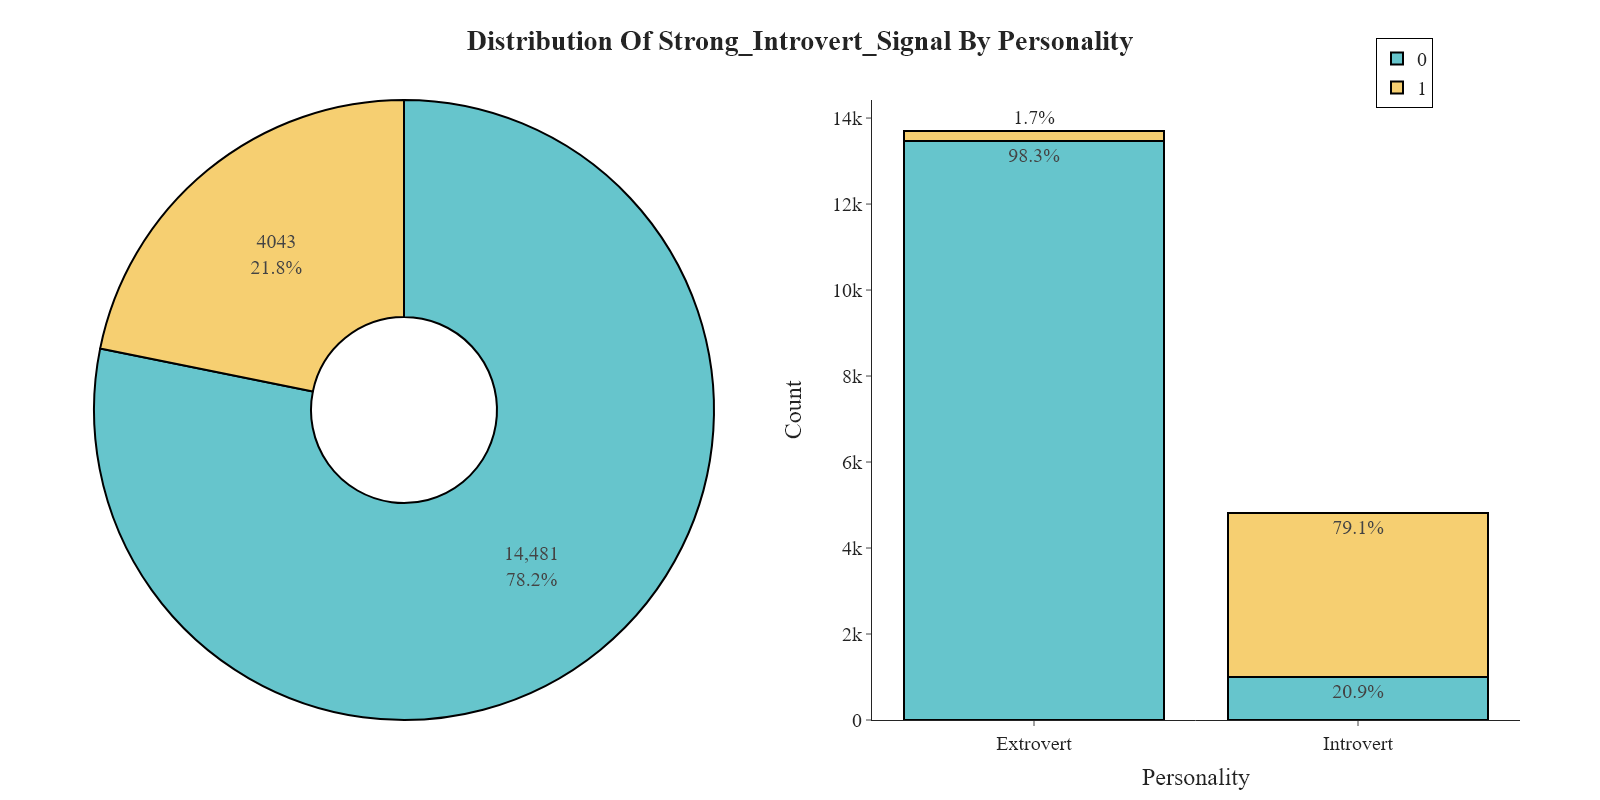

In [40]:
# High social activity + feeling drained = likely introvert
train_data['social_drain_paradox'] = (
    (train_data['high_social_attendance'] == True) & 
    (train_data['Drained_after_socializing'] == 'Yes')
).astype(int)

test_data['social_drain_paradox'] = (
    (test_data['high_social_attendance'] == True) & 
    (test_data['Drained_after_socializing'] == 'Yes')
).astype(int)

# High social activity + NOT feeling drained = likely extrovert
train_data['social_energy_boost'] = (
    (train_data['high_social_attendance'] == True) & 
    (train_data['Drained_after_socializing'] == 'No')
).astype(int)

test_data['social_energy_boost'] = (
    (test_data['high_social_attendance'] == True) & 
    (test_data['Drained_after_socializing'] == 'No')
).astype(int)

# Low social activity + feeling drained when social = strong introvert signal
train_data['strong_introvert_signal'] = (
    (train_data['high_social_attendance'] == False) & 
    (train_data['Drained_after_socializing'] == 'Yes')
).astype(int)

test_data['strong_introvert_signal'] = (
    (test_data['high_social_attendance'] == False) & 
    (test_data['Drained_after_socializing'] == 'Yes')
).astype(int)

# Visualize the interaction features
for feature in ['social_drain_paradox', 'social_energy_boost', 'strong_introvert_signal']:
    plots.pie_stacked_barplot_by_hue(train_data, feature, target_feature, plot_title=f"Distribution of {feature} by {target_feature}")
    display(describe_categorical_feature(train_data, feature))

**Notes:**


## Stage Fear and Social Behavior Interaction

**Motivation:** From EDA, stage fear varies between personality types. The combination of stage fear with social behaviors could reveal contradictory patterns (e.g., high social attendance despite stage fear).

**Approach:** Create interaction features between stage fear levels and social behaviors.

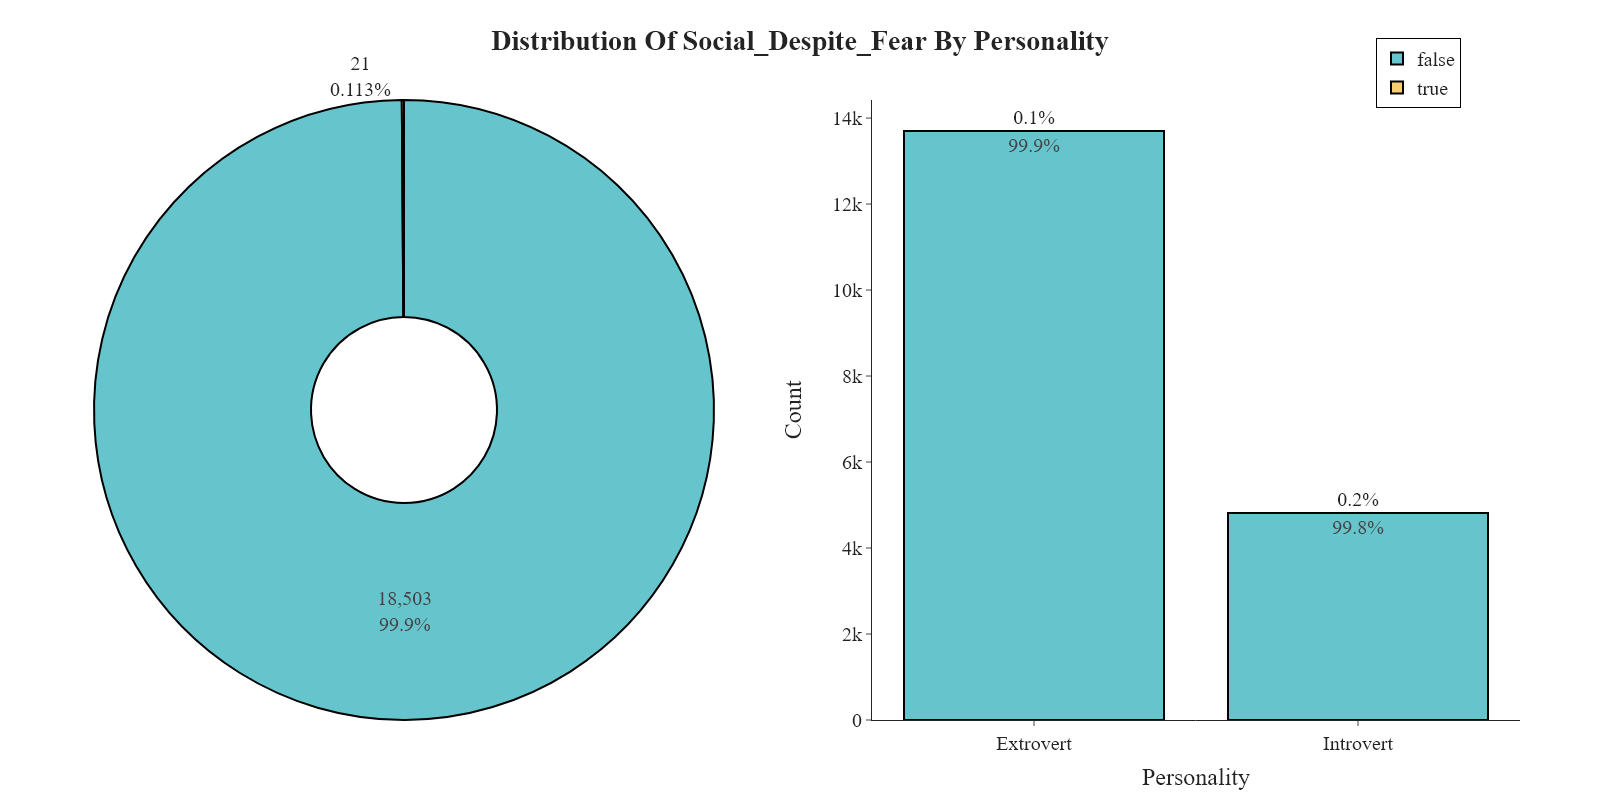

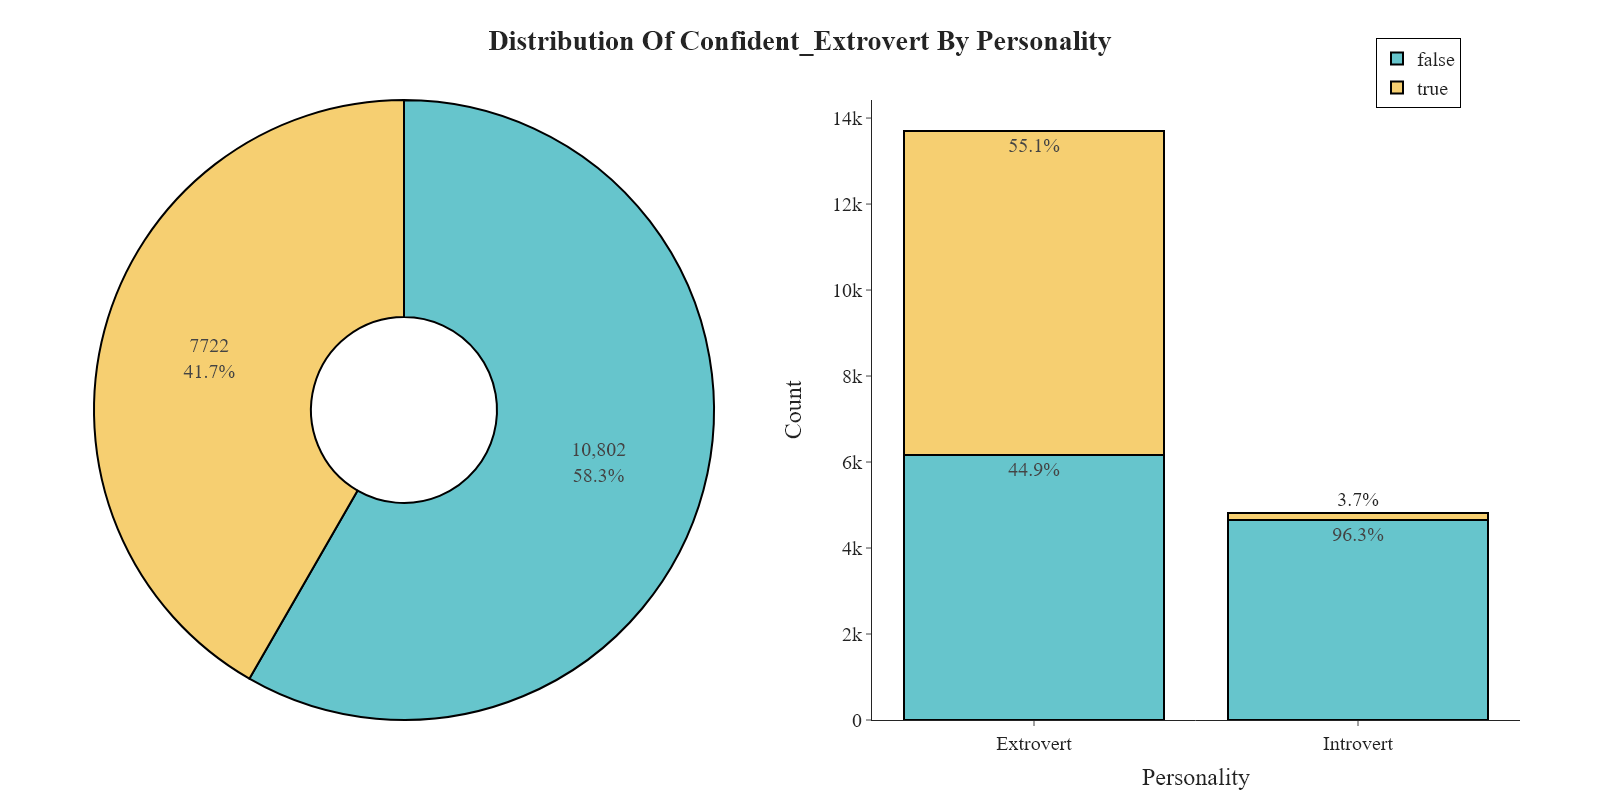

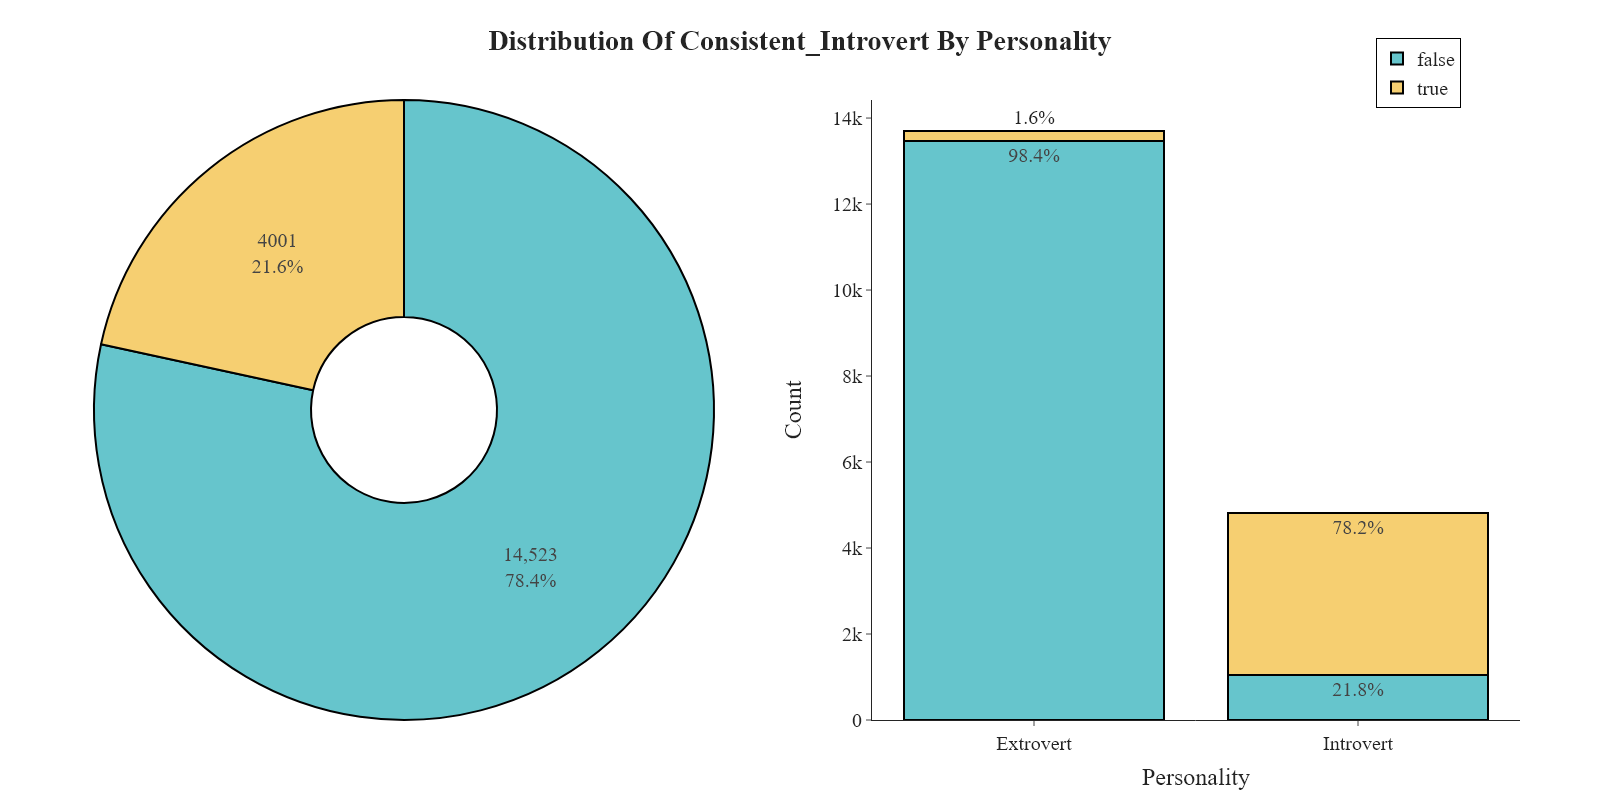

In [41]:
# High stage fear but high social activity = contradictory pattern
train_data['social_despite_fear'] = (
    (train_data['Stage_fear'] == 'Yes') & 
    (train_data['high_social_attendance'] == True)
).astype("category")

test_data['social_despite_fear'] = (
    (test_data['Stage_fear'] == 'Yes') &
    (test_data['high_social_attendance'] == True)
)
test_data['social_despite_fear'] = pd.Categorical(
    test_data['social_despite_fear'],
    categories=train_data['social_despite_fear'].cat.categories
)

# No stage fear + high social activity = confident extrovert
train_data['confident_extrovert'] = (
    (train_data['Stage_fear'] == 'No') & 
    (train_data['high_social_attendance'] == True)
).astype("category")

test_data['confident_extrovert'] = (
    (test_data['Stage_fear'] == 'No') & 
    (test_data['high_social_attendance'] == True)
)
test_data['confident_extrovert'] = pd.Categorical(
    test_data['confident_extrovert'],
    categories=train_data['confident_extrovert'].cat.categories
)

# Stage fear + low social activity = consistent introvert behavior
train_data['consistent_introvert'] = (
    (train_data['Stage_fear'] == 'Yes') & 
    (train_data['high_social_attendance'] == False)
).astype("category")

test_data['consistent_introvert'] = (
    (test_data['Stage_fear'] == 'Yes') & 
    (test_data['high_social_attendance'] == False)
)
test_data['consistent_introvert'] = pd.Categorical(
    test_data['consistent_introvert'],
    categories=train_data['consistent_introvert'].cat.categories
)

# Visualize the interaction features
for feature in ['social_despite_fear', 'confident_extrovert', 'consistent_introvert']:
    plots.pie_stacked_barplot_by_hue(train_data, feature, target_feature, plot_title=f"Distribution of {feature} by {target_feature}")
    display(describe_categorical_feature(train_data, feature))

**Notes:**


## Solitude vs Social Balance Score

**Motivation:** The balance between time spent alone and social activities is a key personality indicator. Some people might be moderate in both (ambivert tendencies) while others show extreme preferences.

**Approach:** Create a ratio-based feature that captures the balance between solitude preference and social engagement.

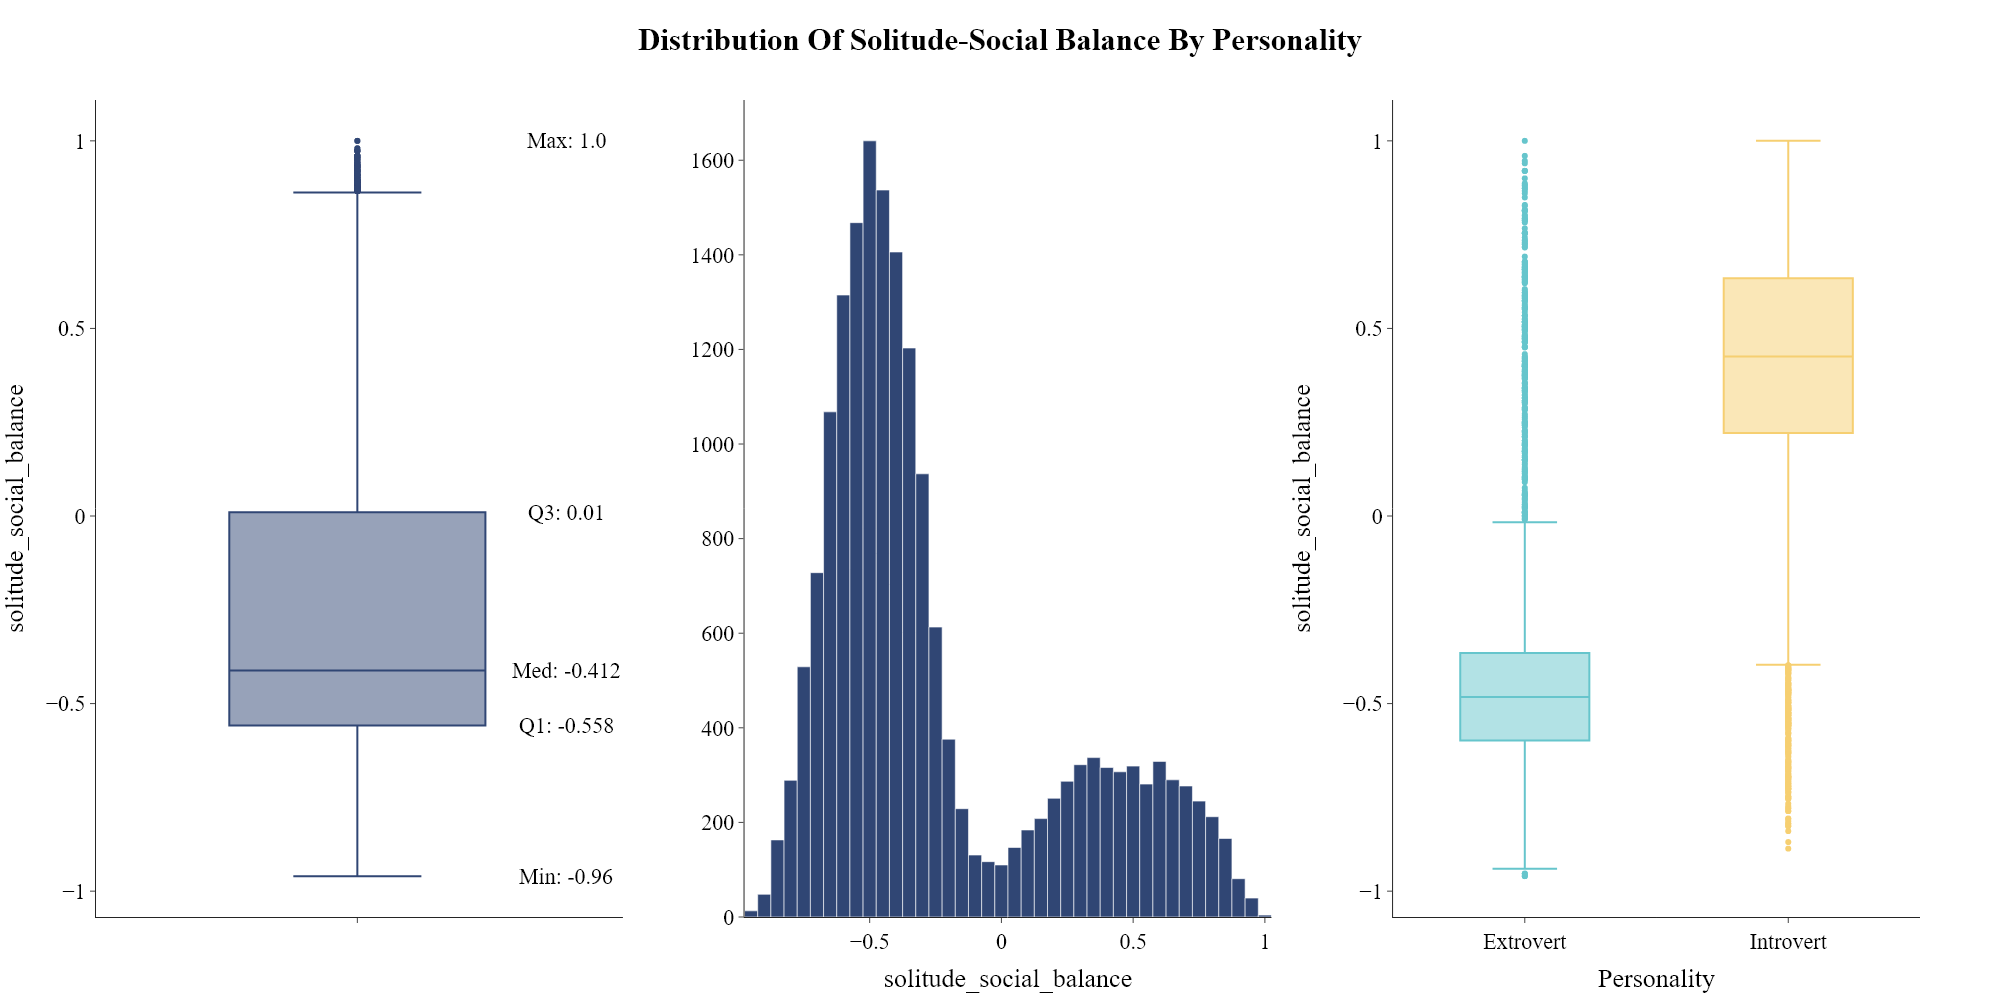

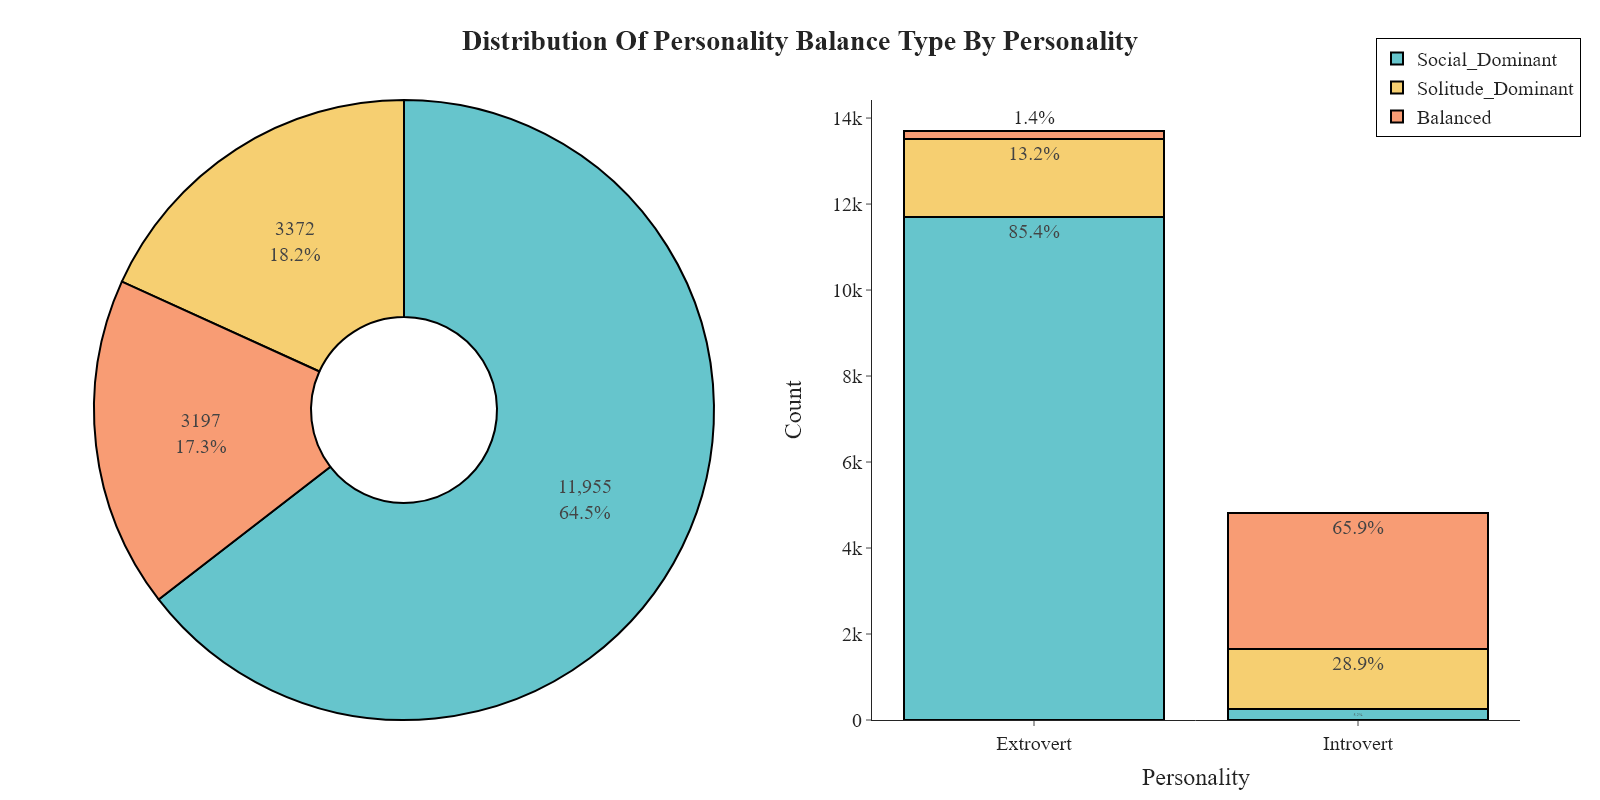

In [42]:
# Normalize features to ensure fair comparison
time_alone_norm = MinMaxScaler().fit_transform(train_data[['Time_spent_Alone']])
social_norm = train_data[['social_interaction_score']].values

# Calculate solitude-social balance ratio
# Positive values = more solitary, Negative values = more social
train_data['solitude_social_balance'] = time_alone_norm.flatten() - social_norm.flatten()

# Apply same transformation to test data
test_time_alone_norm = MinMaxScaler().fit(train_data[['Time_spent_Alone']]).transform(test_data[['Time_spent_Alone']])
test_social_norm = test_data[['social_interaction_score']].values
test_data['solitude_social_balance'] = test_time_alone_norm.flatten() - test_social_norm.flatten()

# Create categorical version
train_data['personality_balance_type'] = pd.cut(
    train_data['solitude_social_balance'],
    bins=[-np.inf, -0.3, 0.3, np.inf],
    labels=['Social_Dominant', 'Balanced', 'Solitude_Dominant']
)
train_data['personality_balance_type'] = train_data['personality_balance_type'].astype('category')

test_data['personality_balance_type'] = pd.cut(
    test_data['solitude_social_balance'],
    bins=[-np.inf, -0.3, 0.3, np.inf],
    labels=['Social_Dominant', 'Balanced', 'Solitude_Dominant']
)
test_data['personality_balance_type'] = pd.Categorical(
    test_data['personality_balance_type'],
    categories=train_data['personality_balance_type'].cat.categories
)

# Visualize the balance score
plots.boxplot_histogram_boxplot_by_hue(train_data, 'solitude_social_balance', target_feature, bin_size=0.05, annotations=["Min", "Q1", "Med", "Q3", "Max"], plot_title=f"Distribution of Solitude-Social Balance by {target_feature}")
display(describe_numerical_feature(train_data, 'solitude_social_balance'))
plots.pie_stacked_barplot_by_hue(train_data, 'personality_balance_type', target_feature, plot_title=f"Distribution of Personality Balance Type by {target_feature}")
display(describe_categorical_feature(train_data, 'personality_balance_type'))

**Notes:**


## Digital vs Physical Social Engagement

**Motivation:** Modern personality types may differ in their preference for digital (posting) vs physical (outdoor activities, social events) social engagement. Some introverts might be more comfortable with digital interaction.

**Approach:** Create features contrasting digital social behavior (posting) with physical social behaviors (going outside, attending events).

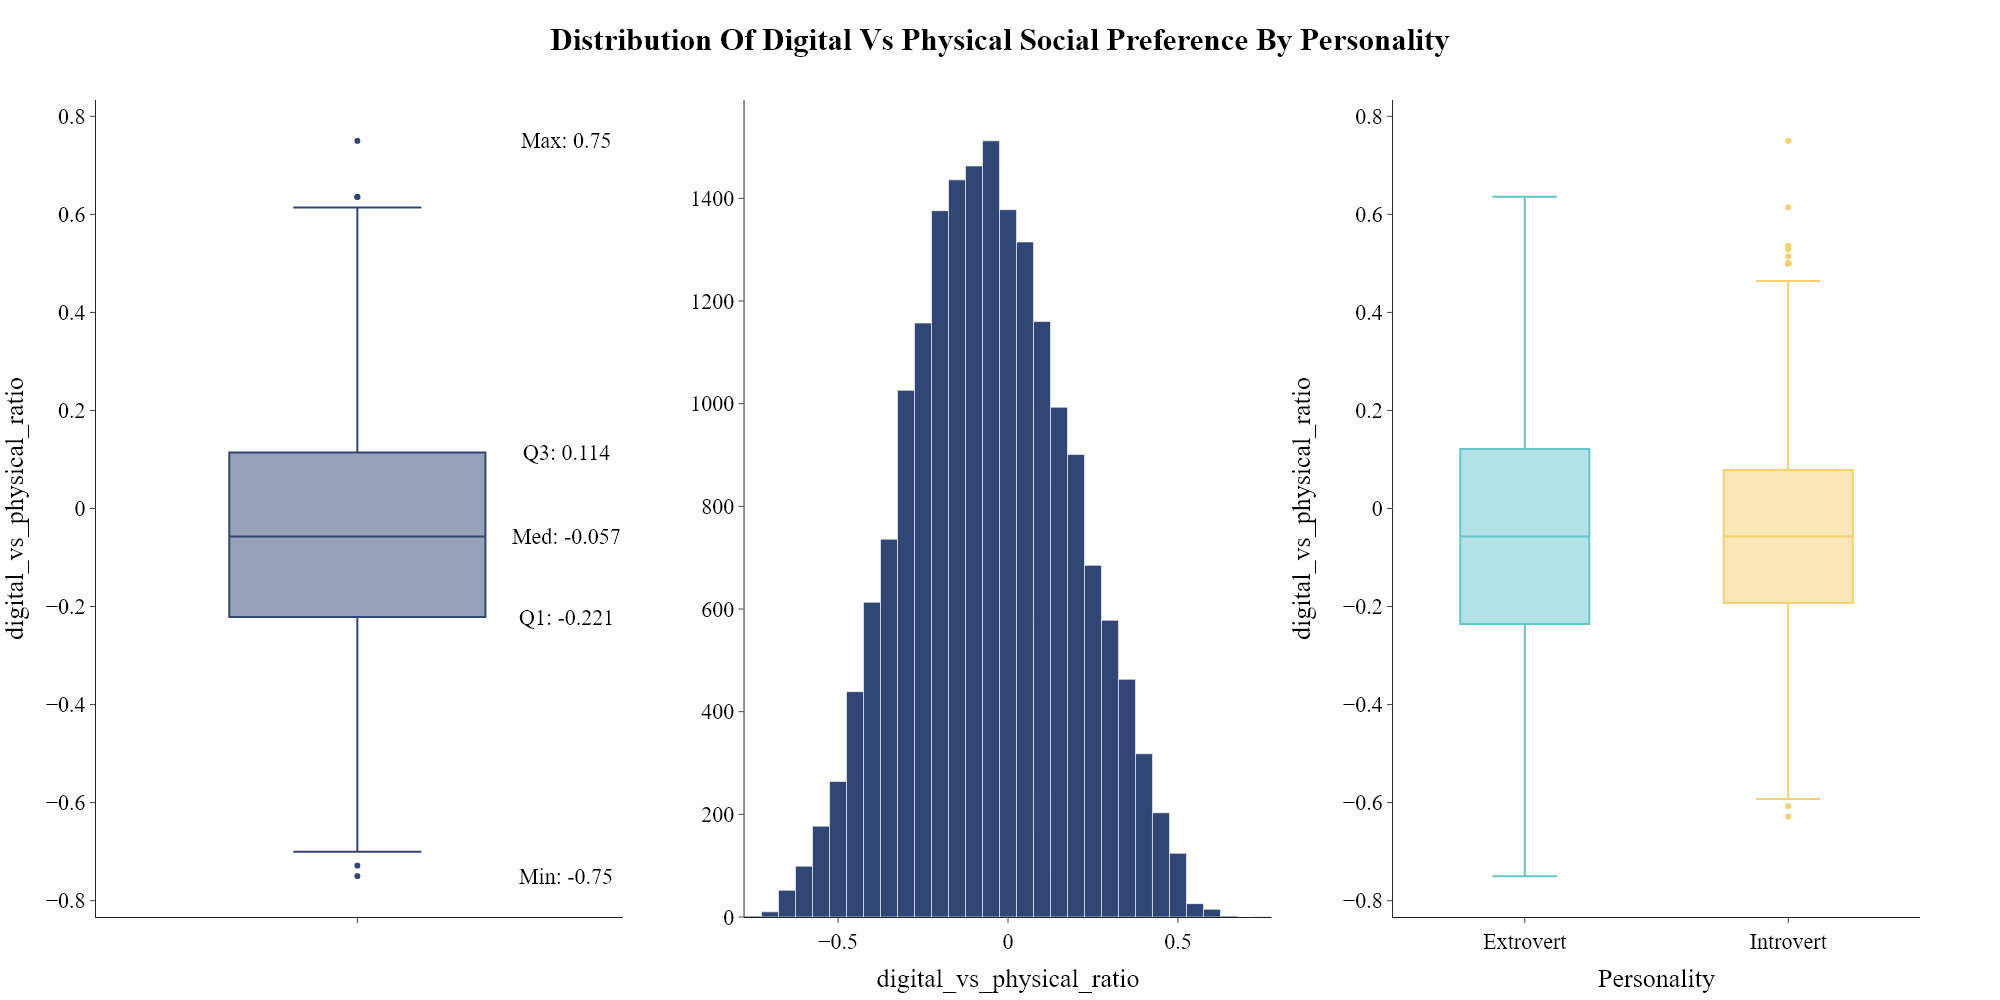

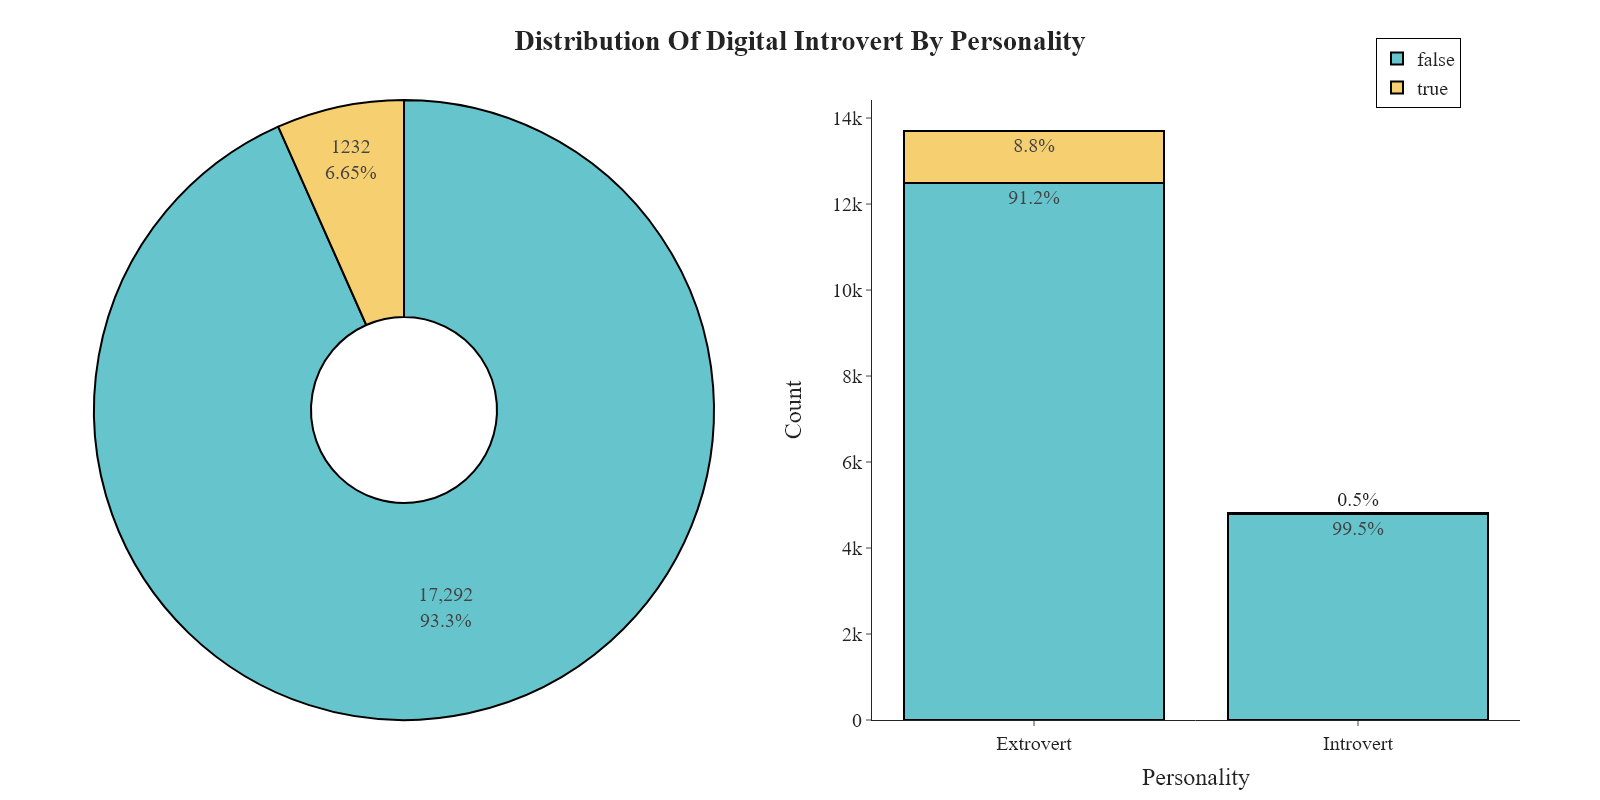

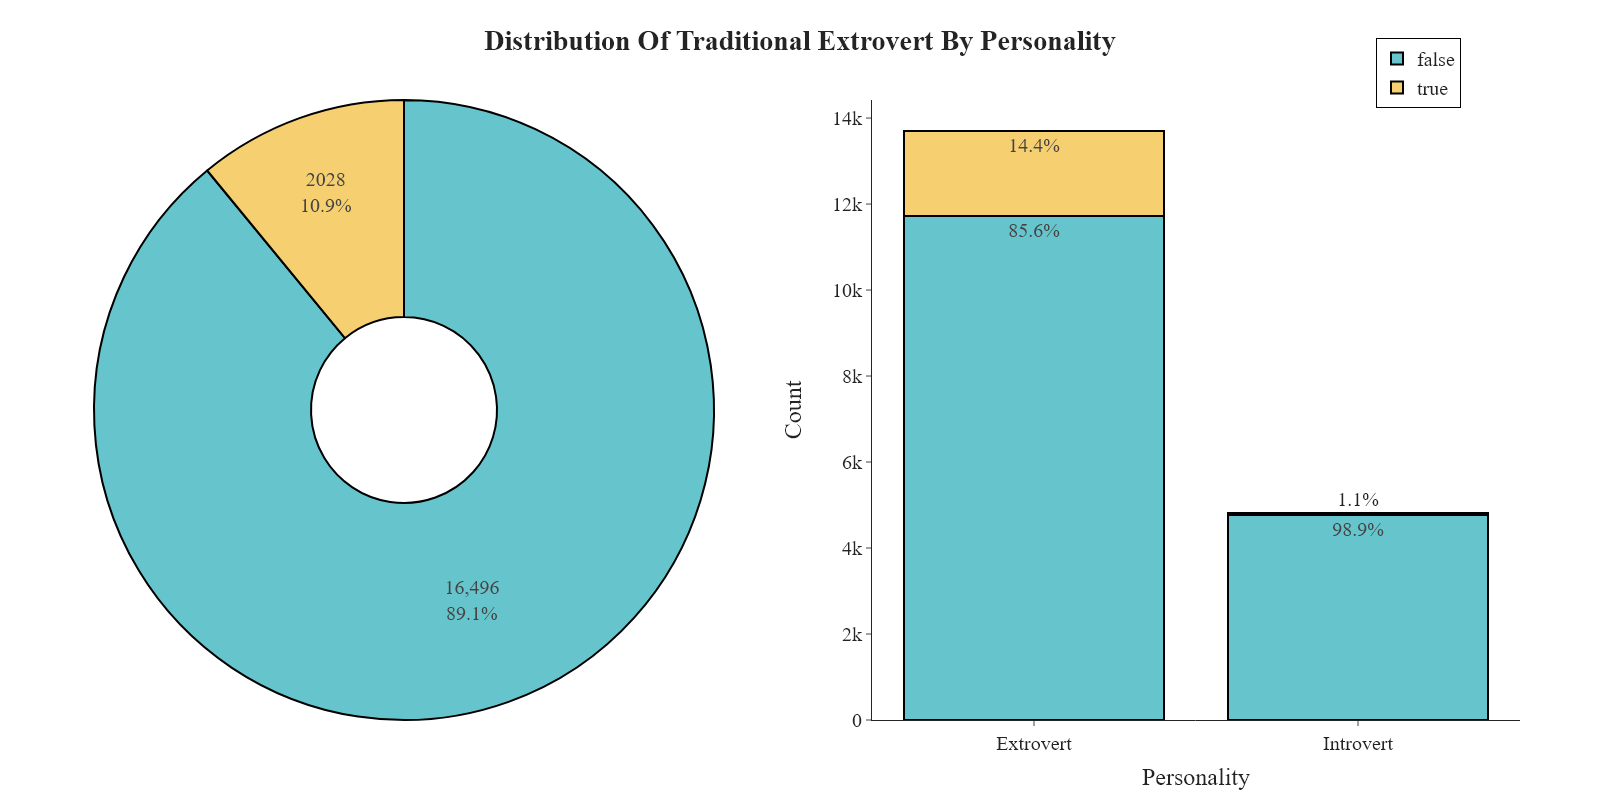

In [43]:
# Normalize posting vs physical activity for comparison
physical_social_features = ['Social_event_attendance', 'Going_outside']
physical_scaler = MinMaxScaler()

train_physical_norm = physical_scaler.fit_transform(train_data[physical_social_features])
test_physical_norm = physical_scaler.transform(test_data[physical_social_features])

# Calculate average physical social engagement
train_data['physical_social_score'] = train_physical_norm.mean(axis=1)
test_data['physical_social_score'] = test_physical_norm.mean(axis=1)

# Normalize digital social (posting) for comparison
digital_scaler = MinMaxScaler()
train_digital_social_score = digital_scaler.fit_transform(train_data[['Post_frequency']]).flatten()
test_digital_social_score = digital_scaler.transform(test_data[['Post_frequency']]).flatten()

# Create digital vs physical preference ratio
train_data['digital_vs_physical_ratio'] = (
    train_digital_social_score - train_data['physical_social_score']
)
test_data['digital_vs_physical_ratio'] = (
    test_digital_social_score - test_data['physical_social_score']
)

# High digital, low physical = digital introvert
train_data['digital_introvert'] = (
    (train_data['frequent_poster'] == True) & 
    (train_data['high_social_attendance'] == False) &
    (train_data['frequent_outdoor'] == False)
).astype("category")

test_data['digital_introvert'] = (
    (test_data['frequent_poster'] == True) & 
    (test_data['high_social_attendance'] == False) &
    (test_data['frequent_outdoor'] == False)
)
test_data['digital_introvert'] = pd.Categorical(
    test_data['digital_introvert'],
    categories=train_data['digital_introvert'].cat.categories
)

# Low digital, high physical = traditional extrovert
train_data['traditional_extrovert'] = (
    (train_data['frequent_poster'] == False) & 
    (train_data['high_social_attendance'] == True) &
    (train_data['frequent_outdoor'] == True)
).astype("category")

test_data['traditional_extrovert'] = (
    (test_data['frequent_poster'] == False) & 
    (test_data['high_social_attendance'] == True) &
    (test_data['frequent_outdoor'] == True)
)
test_data['traditional_extrovert'] = pd.Categorical(
    test_data['traditional_extrovert'],
    categories=train_data['traditional_extrovert'].cat.categories
)

# Visualize digital vs physical preference
plots.boxplot_histogram_boxplot_by_hue(train_data, 'digital_vs_physical_ratio', target_feature, bin_size=0.05, annotations=["Min", "Q1", "Med", "Q3", "Max"], plot_title=f"Distribution of Digital vs Physical Social Preference by {target_feature}")
display(describe_numerical_feature(train_data, 'digital_vs_physical_ratio'))
plots.pie_stacked_barplot_by_hue(train_data, 'digital_introvert', target_feature, plot_title=f"Distribution of Digital Introvert by {target_feature}")
display(describe_categorical_feature(train_data, 'digital_introvert'))
plots.pie_stacked_barplot_by_hue(train_data, 'traditional_extrovert', target_feature, plot_title=f"Distribution of Traditional Extrovert by {target_feature}")
display(describe_categorical_feature(train_data, 'traditional_extrovert'))

**Notes:**


In [44]:
train_scores, validation_scores = perform_cv(train_data[list(set(train_data.columns) - {target_feature})], train_data[target_feature], model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9707 +- 0.0006
Validation Accuracy: 0.9688 +- 0.0025


# Multivariate Feature Analysis

In [45]:
categorical_features = get_categorical_columns(train_data)
if target_feature in categorical_features:
    categorical_features.remove(target_feature)
    label2id = {label: idx for idx, label in enumerate(train_data[target_feature].cat.categories)}
    id2label = {idx: label for label, idx in label2id.items()}
    print(id2label)
    train_data[target_feature] = train_data[target_feature].cat.codes
numerical_features = train_data.columns.difference(categorical_features).tolist()
if target_feature in numerical_features:
    numerical_features.remove(target_feature)
independent_features = train_data.columns.difference([target_feature]).tolist()

{0: 'Extrovert', 1: 'Introvert'}


# Numerical data analysis

## Correlation matrix

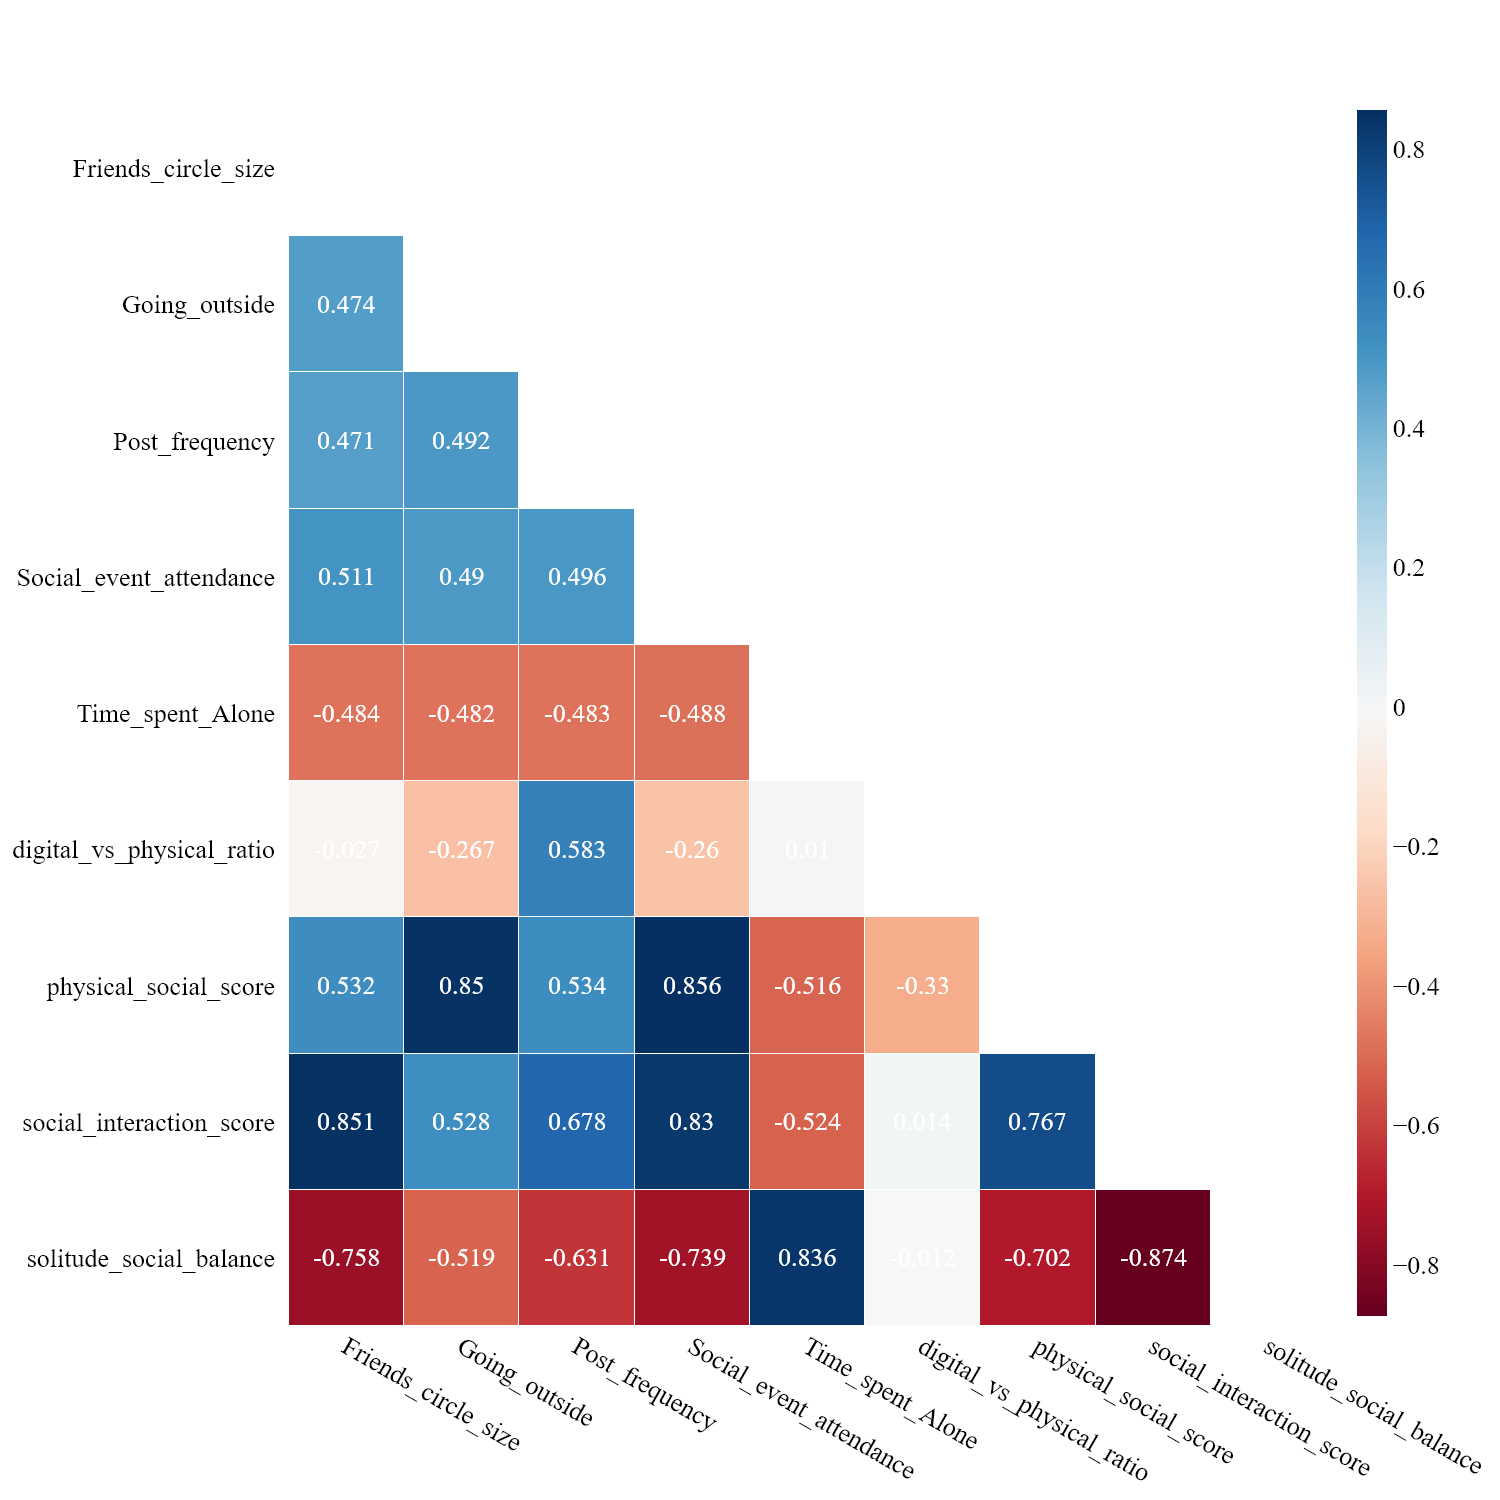

In [46]:
plots.correlation_plot(train_data[numerical_features], features_names=numerical_features, method="spearman")

**Notes:**

# Categorical data analysis

## Chi square test

Chi square test is used to determine whether there is a significant association between two categorical variables.

We will analyze the relationship between the target variable `Personality` and other categorical features using the Chi-square test of independence.

In [47]:
class Chi_Square_Test:
    def check_X(
        self, X: pd.DataFrame | pd.Series | np.ndarray
    ) -> np.ndarray:
        """
        Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (pd.DataFrame | pd.Series | np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: pd.DataFrame | pd.Series | np.ndarray
    ) -> np.ndarray:
        """
        Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (pd.DataFrame | pd.Series | np.ndarray): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """
        Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def fit(
        self,
        X: pd.DataFrame | pd.Series | np.ndarray,
        y: pd.DataFrame | pd.Series | np.ndarray,
        alpha: float = 0.05,
    ):
        """
        Perform Chi Square test.

        Args:
            X: (pd.DataFrame | pd.Series | np.ndarray): input data.
            y: (pd.DataFrame | pd.Series | np.ndarray): target data.
            alpha: (float): significance level.
        """
        # X = self.check_X(X)
        # X = self.check_for_object_columns(X)
        # y = self.check_y(y)
        self.crosstab_ = self.crosstab_creation(X=X, y=y)
        self.check_assumptions(crosstab=self.crosstab_)
        self.test_statistic_ = self.calculate_chi_square_statistic(
            crosstab=self.crosstab_
        )
        self.df_ = self.calculate_degrees_of_freedom(crosstab=self.crosstab_)
        self.p_value_ = self.calculate_p_value(
            test_statistic=self.test_statistic_, df=self.df_
        )
        self.critical_value_ = self.calculate_critical_value(df=self.df_, alpha=alpha)
        self.keep_H0 = self.statistical_inference(p_value=self.p_value_, alpha=alpha)
        self.V_Cramera_ = self.calculate_V_Cramera(
            test_statistic=self.test_statistic_, crosstab=self.crosstab_
        )

    def crosstab_creation(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Create crosstab from input data.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            crosstab: (np.ndarray): crosstab.
        """
        return np.array(pd.crosstab(X, y, margins=True))

    def check_assumptions(self, crosstab: np.ndarray) -> bool:
        """
        Check if assumptions for Chi Square test are met.

        Args:
            crosstab: (np.ndarray): crosstab.

        Raises:
            Warning: if assumptions are not met.
        """
        if not all(i <= 5 for i in crosstab.flatten()):
            self.assumption_ = False
            #warnings.warn("Assumptions for Chi Square test are not met.")
        else:
            self.assumption_ = True

    def calculate_chi_square_statistic(self, crosstab: np.ndarray) -> float:
        """
        Calculate Chi Square statistic.

        Args:
            crosstab: (np.ndarray): crosstab.

        Returns:
            chi_square: (float): Chi Square statistic.
        """
        chi_square = 0
        for row in range(0, crosstab.shape[0] - 1):
            for column in range(0, crosstab.shape[1] - 1):
                observed = crosstab[row][column]
                expected = crosstab[row][-1] * crosstab[-1][column] / crosstab[-1][-1]
                chi_square += (observed - expected) ** 2 / expected
        return chi_square

    def calculate_degrees_of_freedom(self, crosstab: np.ndarray) -> int:
        """
        Calculate degrees of freedom.

        Args:
            crosstab: (np.ndarray): crosstab.

        Returns:
            df: (int): degrees of freedom.
        """
        return (crosstab.shape[0] - 2) * (crosstab.shape[1] - 2)

    def calculate_p_value(self, test_statistic: float, df: int) -> float:
        """
        Calculate p value.

        Args:
            test_statistic: (float): test statistic.
            df: (int): degrees of freedom.

        Returns:
            p_value: (float): p value.
        """
        return 1 - chi2.cdf(x=test_statistic, df=df)

    def calculate_critical_value(self, df: int, alpha: float) -> float:
        """
        Calculate critical value.

        Args:
            df: (int): degrees of freedom.
            alpha: (float): significance level.

        Returns:
            critical_value: (float): critical value.
        """
        return chi2.isf(q=alpha, df=df)

    def statistical_inference(self, p_value: float, alpha: float) -> bool:
        """
        Perform statistical inference.

        Args:
            p_value: (float): p value.
            alpha: (float): significance level.

        Returns:
            bool: (bool): True if H0 is not rejected, False otherwise.
        """
        if p_value >= alpha:
            return True
        else:
            return False

    def calculate_V_Cramera(self, test_statistic: float, crosstab: np.ndarray) -> float:
        """
        Calculate V Cramer test statistic.

        Args:
            test_statistic: (float): test statistic.
            crosstab: (np.ndarray): crosstab.

        Returns:
            V_Cramer: (float): V Cramer test statistic.
        """
        return (
            test_statistic
            / (
                crosstab[-1][-1]
                * np.min([crosstab.shape[0] - 2, crosstab.shape[1] - 2])
            )
        ) ** 0.5

chi_square = Chi_Square_Test()

In [48]:
chi_square_results = pd.DataFrame(columns=["Feature", "p_value", "Test statistic", "Critical value", "H0 rejected", "V Cramera"])
for feature in categorical_features:
    chi_square.fit(X=train_data[feature], y=train_data[target_feature])
    chi_square_results = pd.concat([chi_square_results if not chi_square_results.empty else None, pd.DataFrame({"Feature": [feature], "p_value": [chi_square.p_value_], "Test statistic": [chi_square.test_statistic_], "Critical value": [chi_square.critical_value_], "H0 rejected": [not chi_square.keep_H0], "V Cramera": [chi_square.V_Cramera_]})])
chi_square_results.sort_values(by="Test statistic", ascending=False, inplace=True)
chi_square_results.reset_index(drop=True, inplace=True)
print(f"Percantage of features where H0 is not rejected (features are NOT associated with {target_feature}): {chi_square_results[chi_square_results['H0 rejected'] == False].shape[0]/len(chi_square_results)*100:.2f}%")
print(f"Percantage of features where H0 is rejected (features are associated with {target_feature}): {chi_square_results[chi_square_results['H0 rejected'] == True].shape[0]/len(chi_square_results)*100:.2f}%")
chi_square_results

Percantage of features where H0 is not rejected (features are NOT associated with Personality): 0.00%
Percantage of features where H0 is rejected (features are associated with Personality): 100.00%


Feature   p_value  Test statistic  Critical value  \
0   Drained_after_socializing  0.000000    14354.218350        5.991465   
1                  Stage_fear  0.000000    13530.725645        5.991465   
2     strong_introvert_signal  0.000000    12538.590158        3.841459   
3        consistent_introvert  0.000000    12360.162367        3.841459   
4    personality_balance_type  0.000000    12217.449571        5.991465   
5             time_alone_high  0.000000     9616.120963        3.841459   
6              time_alone_low  0.000000     5483.089487        3.841459   
7     high_social_interaction  0.000000     5187.255260        3.841459   
8         large_friend_circle  0.000000     5054.790653        3.841459   
9      high_social_attendance  0.000000     4545.651378        3.841459   
10        social_energy_boost  0.000000     4307.897417        3.841459   
11        confident_extrovert  0.000000     3866.670607        3.841459   
12            frequent_poster  0.000000     3808.344171        3.841459   
13           frequent_outdoor  0.000000     3665.279882        3.841459   
14      traditional_extrovert  0.000000      646.496448        3.841459   
15          digital_introvert  0.000000      392.572108        3.841459   
16        social_despite_fear  0.005939        7.568639        3.841459   
17       social_drain_paradox  0.008252        6.978029        3.841459   

    H0 rejected  V Cramera  
0          True   0.880283  
1          True   0.854660  
2          True   0.822729  
3          True   0.816854  
4          True   0.812125  
5          True   0.720498  
6          True   0.544058  
7          True   0.529178  
8          True   0.522377  
9          True   0.495371  
10         True   0.482242  
11         True   0.456879  
12         True   0.453420  
13         True   0.444822  
14         True   0.186817  
15         True   0.145577  
16         True   0.020213  
17         True   0.019409

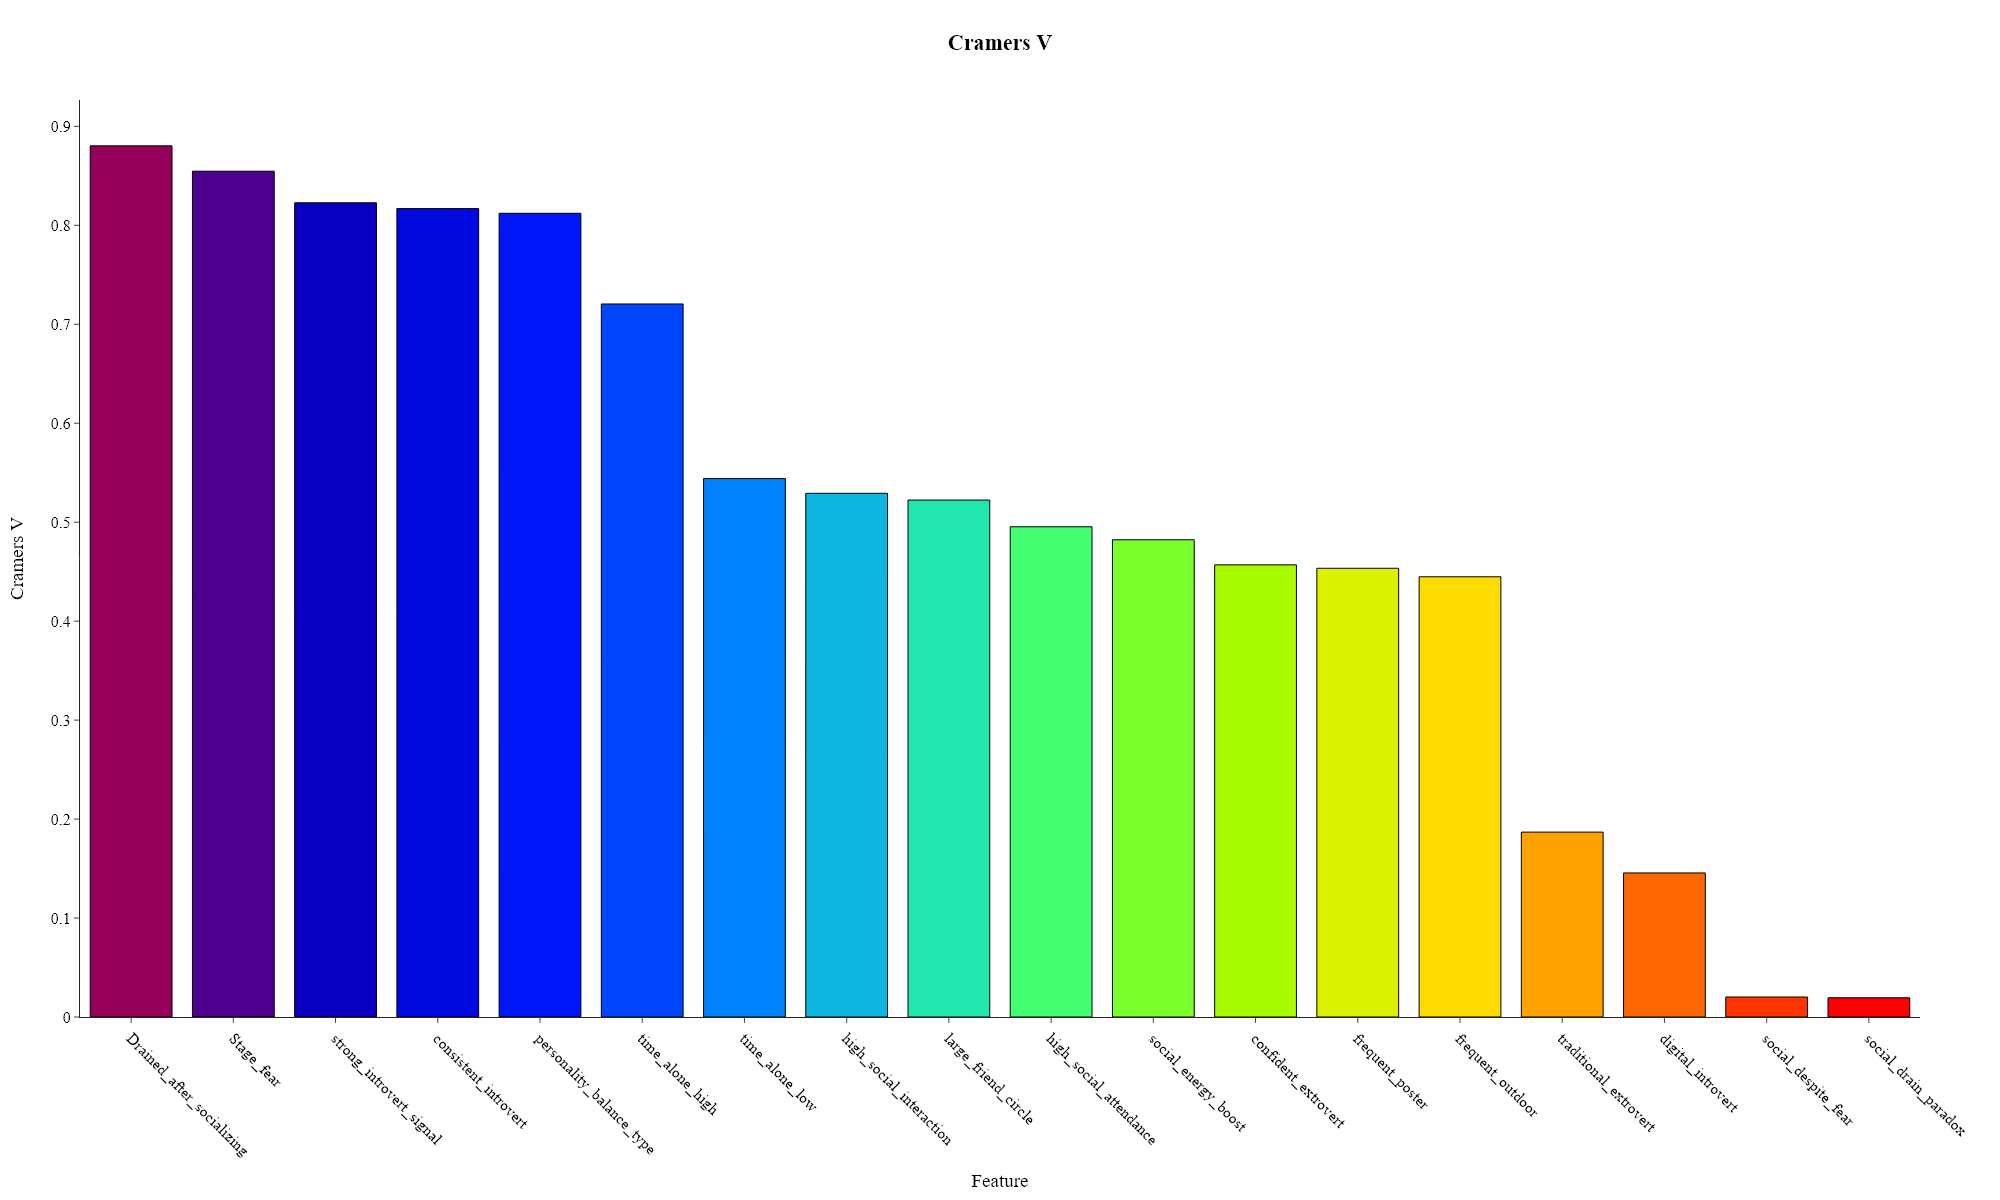

In [49]:
chi_square_results_sorted = chi_square_results.sort_values(by="V Cramera", ascending=False)
fig = go.Figure()
n_colors = len(chi_square_results_sorted)
colors = px.colors.sample_colorscale("rainbow", [n/(n_colors - 1) for n in range(n_colors)])
fig.add_trace(go.Bar(x=chi_square_results_sorted["Feature"], y=chi_square_results_sorted["V Cramera"], marker=dict(color=colors, line=dict(color='black', width=1), line_color='black')))
fig.update_layout(template="simple_white", width=2000, height=1200, title="<b>Cramers V<b>", title_x=0.5, xaxis_title="Feature", yaxis_title="Cramers V", font=dict(family="Times New Roman", size=16, color="Black"), showlegend=False,xaxis=dict(tickangle=45))
fig.show("png")

**Notes:**


# All features

## Mutual information

Mutual information is a measure of the amount of information that one variable contains about another variable.

It can be used to determine the importance of a feature.

The advantage of mutual information is that it can capture any kind of dependency between variables, including non-linear relationships.

That's why we will use it to check the importance of both groups of features: continous and categorical.

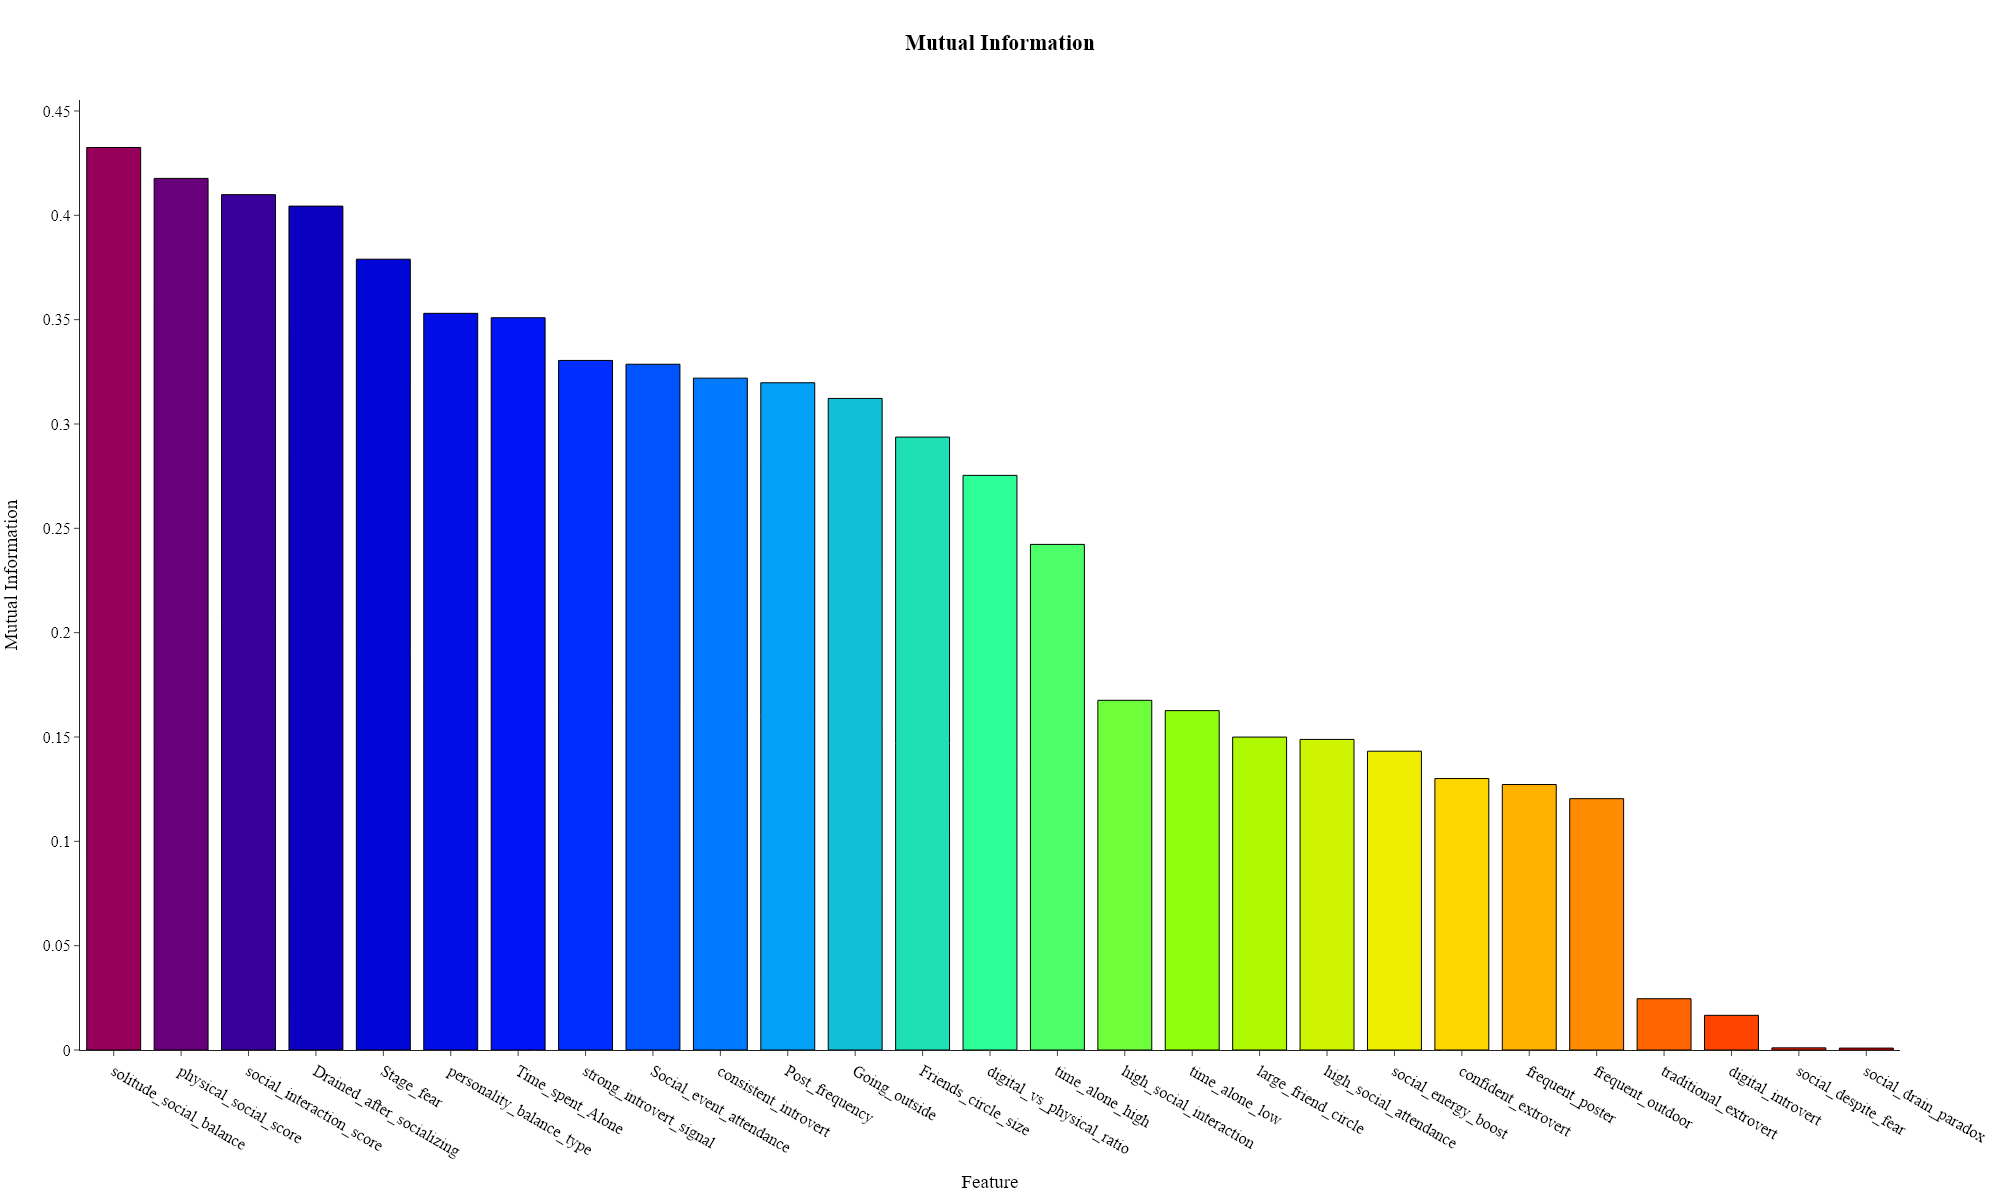

In [50]:
data_temp = train_data.copy()
ordinal_encoder = OrdinalEncoder()
data_temp[categorical_features] = ordinal_encoder.fit_transform(data_temp[categorical_features])
mi_scores = {feature: mutual_info_classif(data_temp[[feature]], data_temp[target_feature], random_state=SEED)[0] for feature in independent_features}
mi_scores = {k: v for k, v in sorted(mi_scores.items(), key=lambda item: item[1], reverse=True)}
fig = go.Figure()
n_colors = len(mi_scores)
colors = px.colors.sample_colorscale("rainbow", [n/(n_colors -1) for n in range(n_colors)])
fig.add_trace(go.Bar(x=list(mi_scores.keys()), y=list(mi_scores.values()), marker=dict(color=colors, line=dict(color='black', width=1), line_color='black')))
fig.update_layout(template="simple_white", width=2000, height=1200, title="<b>Mutual Information<b>", title_x=0.5, xaxis_title="Feature", yaxis_title=f"Mutual Information", font=dict(family="Times New Roman",size=16,color="Black"), showlegend=False)
fig.show("png")

**Notes:**


## Dimensionality reduction

After analyzing continous and categorical features, we can see that some of them are not associated with target variable.

We can use various techniques to reduce dimensionality of dataset, which will help us to avoid curse of dimensionality and improve model performance.

Before applying any of these techniques, it is good practice to check whether we should reduce dimensionality of dataset.

We will use two techniques to check that:

- Kaiser-Meyer-Olkin (KMO) test

- Bartlett's test of sphericity

### KMO test

In [51]:
def Kaiser_Mayer_Olkin(data):
    dataframe = pd.DataFrame(data)
    corr = dataframe.corr(method="spearman")
    corr = np.asarray(corr)
    corr_inv = np.linalg.inv(corr)
    kmo_numerator = np.sum(np.square(corr)) - np.sum(np.square(np.diag(corr)))
    partial_corr = np.zeros((corr.shape[0], corr.shape[0]))
    for i in range(corr.shape[0]):
        for j in range(corr.shape[0]):
            partial_corr[i, j] = -corr_inv[i, j]/np.sqrt(corr_inv[i, i]*corr_inv[j, j])
            partial_corr[j, i] = partial_corr[i, j]
    kmo_denominator = kmo_numerator + np.sum(np.square(partial_corr)) - np.sum(np.square(np.diag(partial_corr)))
    return kmo_numerator/kmo_denominator

print("KMO: ", Kaiser_Mayer_Olkin(train_data[numerical_features]))

KMO:  0.6127421748898878


**Notes:**

Bartlett's test of sphericity is a statistical test that tests the null hypothesis that the correlation matrix is an identity matrix.

In other words, it tests whether the observed variables intercorrelate at all using the observed correlation matrix against the identity matr

In [52]:
def bartlett_sphercity(data: np.ndarray) -> tuple[float, float]:
    """
    Perform Bartlett's Sphercity test.

    Args:
        data (np.ndarray): data to be tested.

    Returns:
        chi_square (float): chi square test statistic.
        p_value (float): p value.
    """
    corr_matrix = np.corrcoef(data, rowvar=False)
    N = data.shape[0]
    M = data.shape[1]
    chi_square = -(N - 1 - (2 * M - 5) / 6) * np.log(np.linalg.det(corr_matrix))
    degrees_of_freedom = (M**2 - M) / 2
    p_value = 1 - chi2.cdf(x=chi_square, df=degrees_of_freedom)
    return chi_square, p_value

test_statistic, pvalue = bartlett_sphercity(train_data[numerical_features])
print("Test Statistic: {}".format(np.round(test_statistic, 4)))
print("p_value: {}".format(np.round(pvalue, 4)))

Test Statistic: 2631670.0647
p_value: 0.0


**Notes:**

### PCA

Principal Component Analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

We will use PCA to reduce dimensionality of dataset.

However, before applying PCA we have to scale the data, so that all features have the same scale.

Because in our dataset we have some features that are binary and some that are continous, we will use MinMaxScaler to scale the data to the range [0, 1].

In [53]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_transformed = train_data.copy()
data_transformed.drop(target_feature, axis=1, inplace=True)
data_transformed[numerical_features] = scaler.fit_transform(data_transformed[numerical_features])

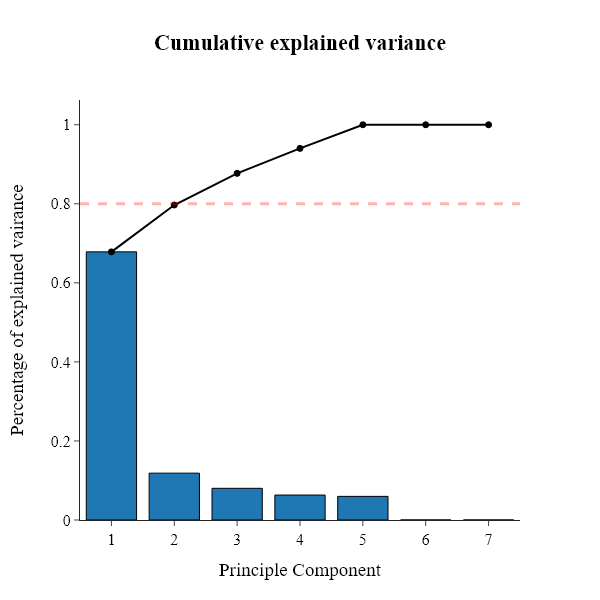

In [54]:
def cumulative_explained_variance(fitted_pca):
    labels = [i+1 for i in range(0, fitted_pca.components_.shape[1])]
    fig = go.Figure()
    fig.add_trace(go.Bar(x=labels, y=fitted_pca.explained_variance_ratio_, marker=dict(line=dict(color='black', width=1))))
    fig.add_trace(go.Scatter(x=labels, y=np.cumsum(fitted_pca.explained_variance_ratio_), marker=dict(line=dict(color='black', width=1)), line=dict(color="black")))
    fig.update_layout(template="simple_white", width=max(30*len(labels), 600), height=max(20*len(labels), 600), title=f"<b>Cumulative explained variance<b>", title_x=0.5, yaxis_title="Percentage of explained vairance", xaxis=dict(title='Principle Component', showticklabels=True, type="category"), font=dict(family="Times New Roman",size=16,color="Black"), showlegend=False)
    fig.add_hline(y=0.8, line_dash="dash", line_color="red", line_width=3)
    fig.show("png")

pca_transformer = PCA(n_components=7, random_state=SEED)
pca_transformer.fit(data_transformed[numerical_features])
cumulative_explained_variance(pca_transformer)

**Notes:**

### Clustering

Clustering is an unsupervised machine learning technique that groups similar observations together based on their features, allowing us to discover inherent structures or patterns in the data.

We will use the KMeans algorithm to perform clustering on our dataset.

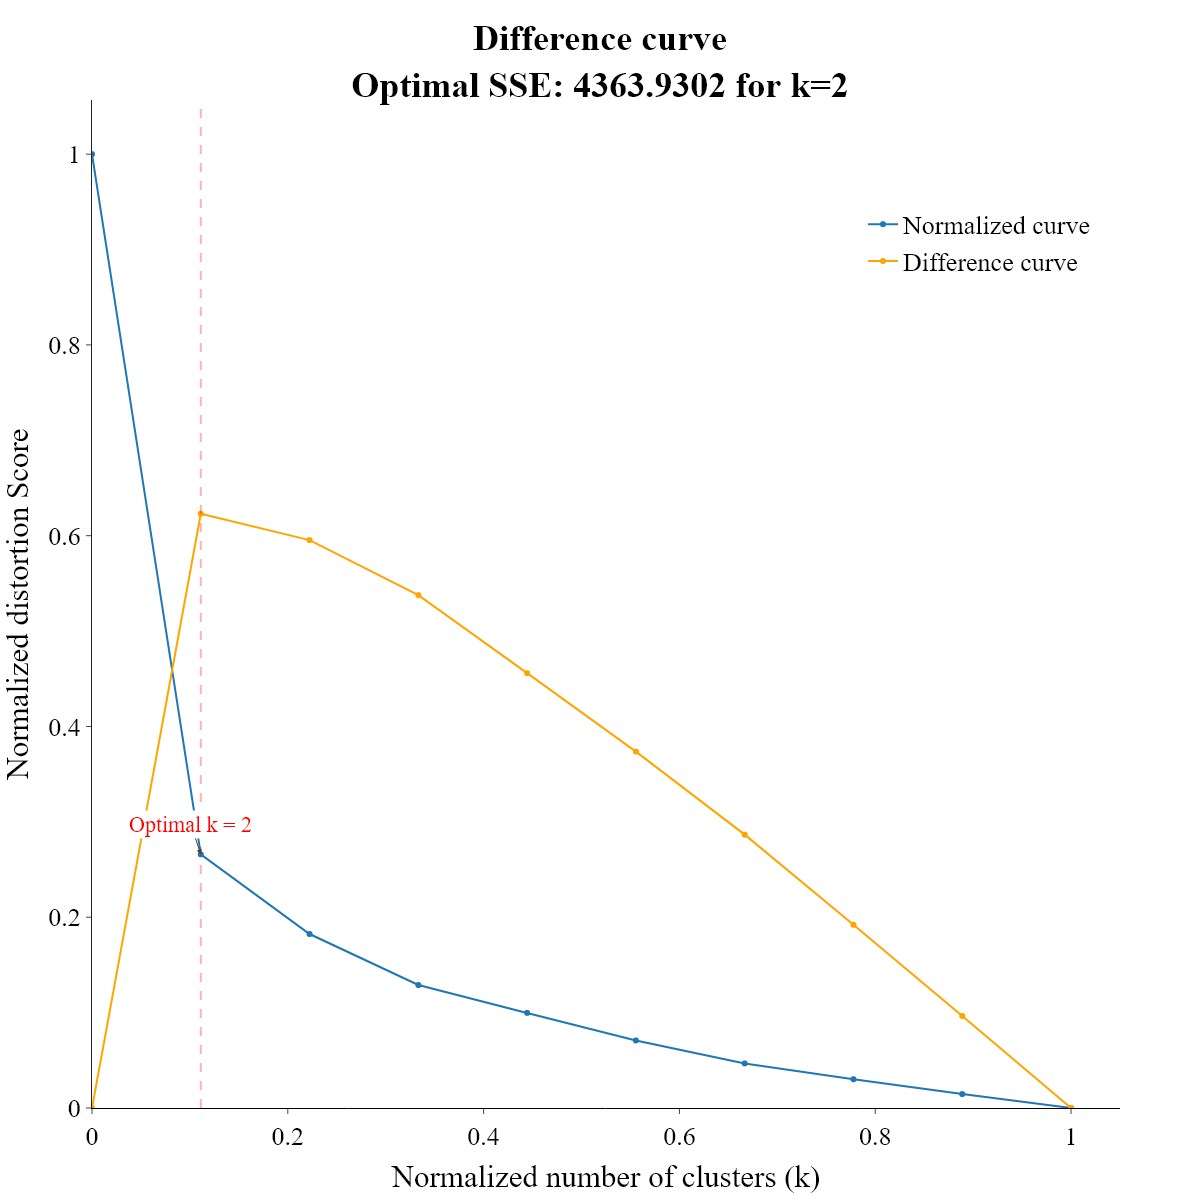

In [55]:
plots.difference_curve(data=data_transformed[numerical_features], algorithm_instance=KMeans(n_init=10, max_iter=300, tol=1e-4, random_state=17), max_clusters=10)

**Notes:**

## Outliers

Before applying Isolation Forest we will convert categorical features with the usage of pandas `get_dummies` function.

In [56]:
data_temp = train_data.copy()
data_temp = pd.get_dummies(data_temp, columns=categorical_features, drop_first=True)
data_temp.drop(target_feature, axis=1, inplace=True)

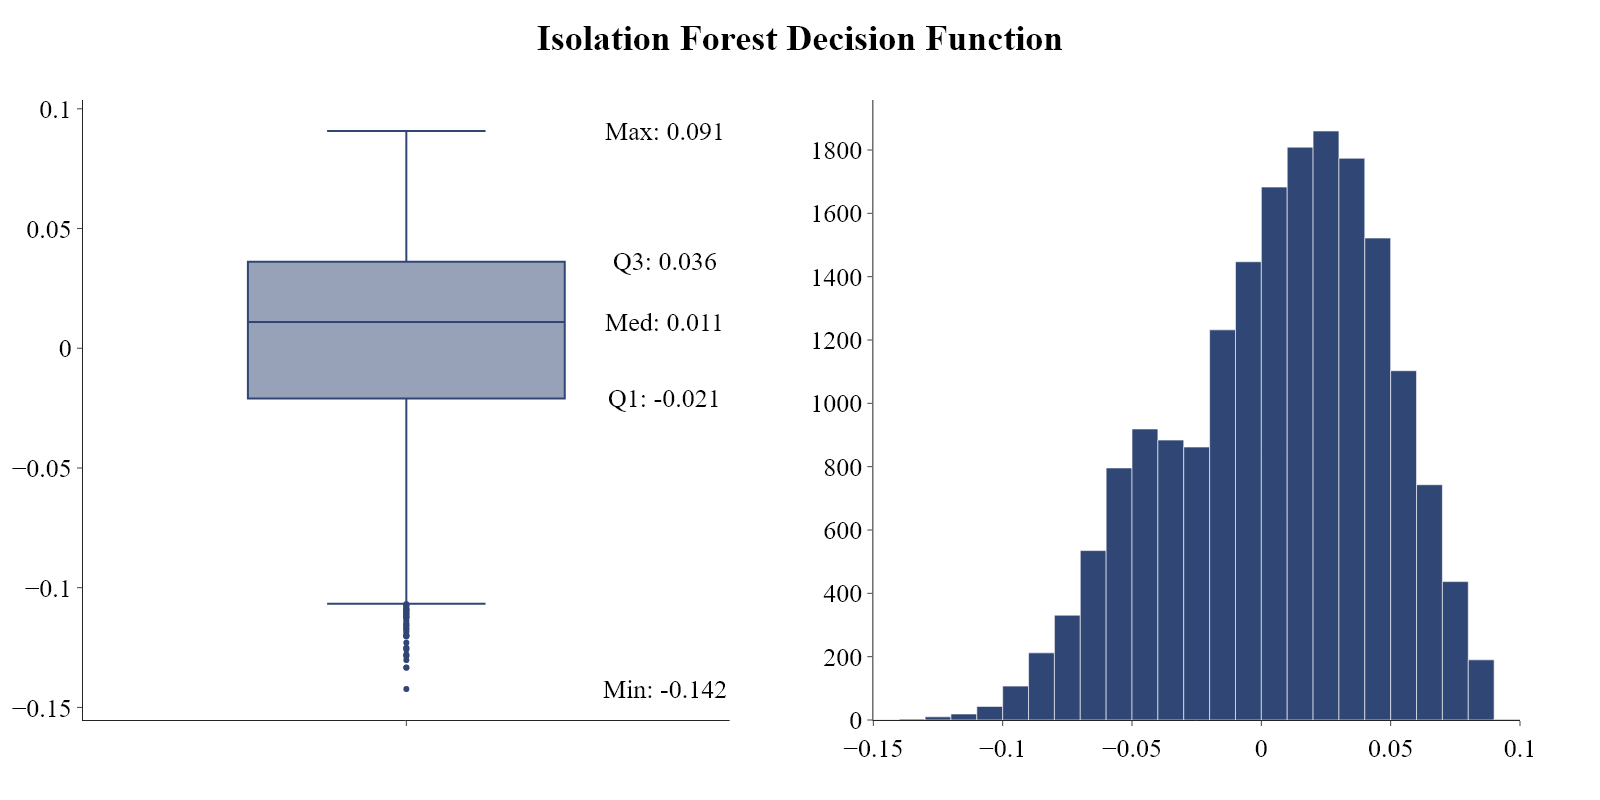

Number of outliers: 7401.
Proportion of outliers: 39.95%.


In [57]:
isolation_forest = IsolationForest(random_state=SEED, n_jobs=-1)
isolation_forest.fit(data_temp)
plots.histogram_and_box_plot(data=isolation_forest.decision_function(data_temp), annotations=True, bin_size=0.01, plot_title="Isolation Forest Decision Function")
outliers = isolation_forest.predict(data_temp)
outliers = pd.Series(outliers)
print("Number of outliers: {}.".format(outliers[outliers == -1].shape[0]))
print("Proportion of outliers: {}%.".format(np.round(outliers[outliers == -1].shape[0] / data_temp.shape[0] * 100, 2)))

**Notes:**

We will use UMAP for that which similar to PCA is a dimensionality reduction technique, but it is more suitable for non-linear data.

However similarly to PCA, UMAP requires scaling of the data, so we will use dataset which was created in previous cells.

In [58]:
data_temp = data_temp.sample(min(data_temp.shape[0], 10000))
outliers = isolation_forest.predict(data_temp)
outliers = pd.Series(outliers)

C:\Users\Kuba\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Kuba\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



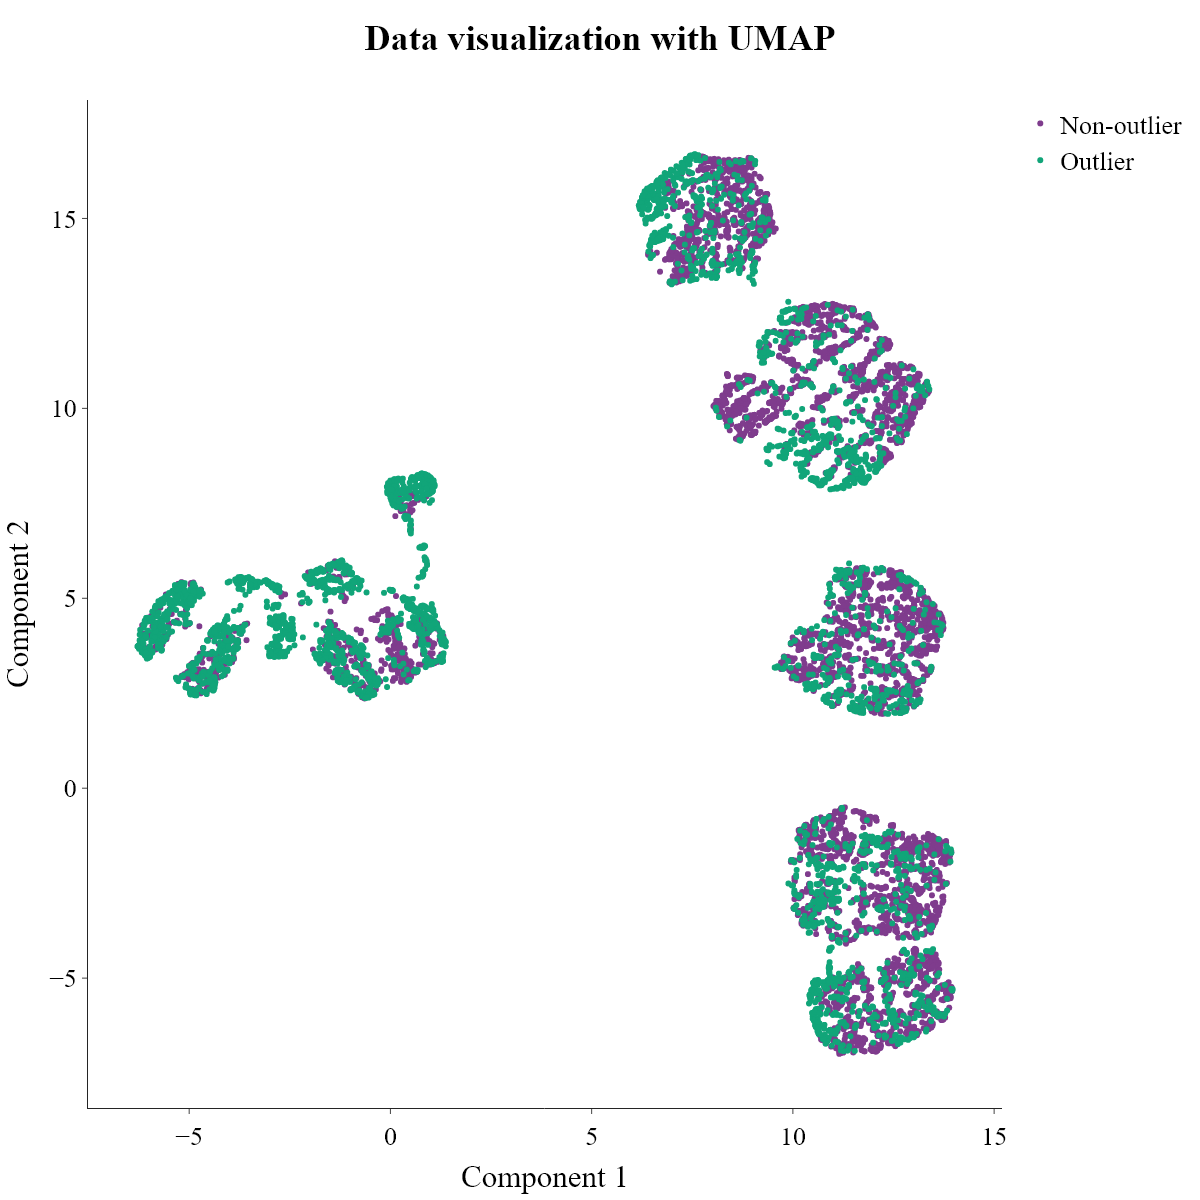

In [59]:
umap_model = UMAP(n_components=2, random_state=SEED, n_jobs=-1)
data_temp_scaled = data_temp.copy()
data_temp_scaled[numerical_features] = scaler.fit_transform(data_temp[numerical_features])
X_umap = umap_model.fit_transform(data_temp_scaled[numerical_features])
plots.scatter_plot(data=X_umap, hue=outliers, plot_title="Data visualization with UMAP")

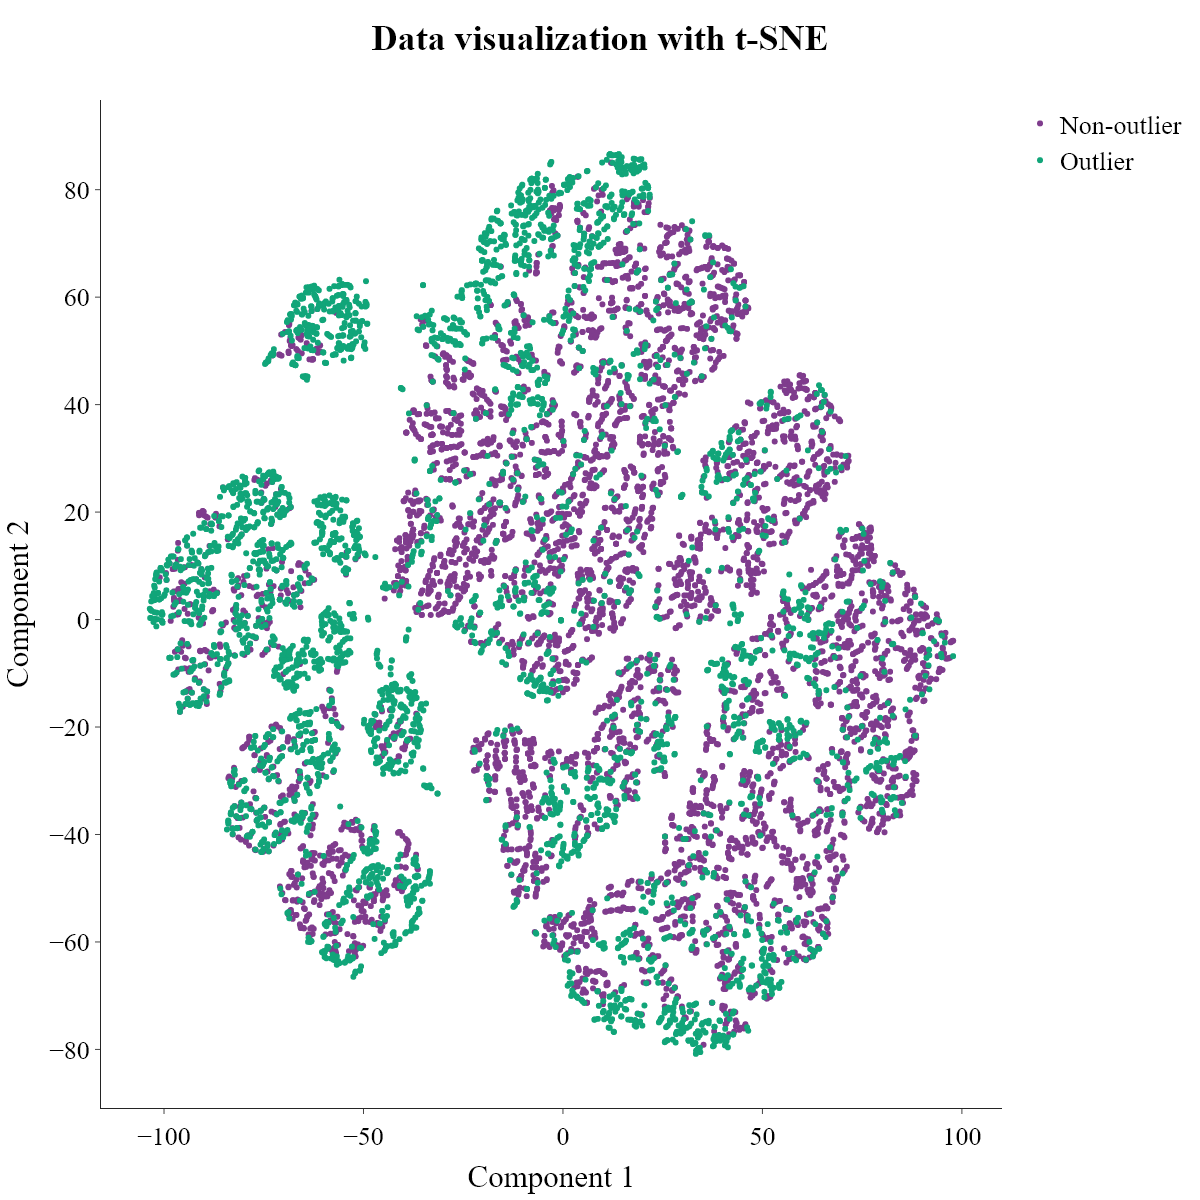

In [60]:
tsne_model = TSNE(n_components=2, random_state=SEED, n_jobs=-1, perplexity=30)
X_tsne = tsne_model.fit_transform(data_temp_scaled[numerical_features])
plots.scatter_plot(data=X_tsne, hue=outliers, plot_title="Data visualization with t-SNE")

**Notes:**

# Baseline modeling

### LightGBM

In [61]:
model = LGBMClassifier(boosting_type='gbdt', random_state=SEED, n_jobs=-1, objective='binary', metric='binary_logloss', verbose=-1, early_stopping=100)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9707 +- 0.0006
Validation Accuracy: 0.9688 +- 0.0025


### LightGBM (goss)

In [62]:
model = LGBMClassifier(boosting_type='goss', random_state=SEED, n_jobs=-1, objective='binary', metric='binary_logloss', verbose=-1, early_stopping=100)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9704 +- 0.0006
Validation Accuracy: 0.9690 +- 0.0026


### XGBoost

In [63]:
model = XGBClassifier(booster="gbtree", random_state=SEED, n_jobs=-1, objective='binary:logistic', eval_metric='logloss', enable_categorical=True, tree_method='hist', verbosity=0, early_stopping_rounds=100)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9714 +- 0.0006
Validation Accuracy: 0.9687 +- 0.0028


### XGBoost (dart)

In [64]:
model = XGBClassifier(booster="dart", random_state=SEED, n_jobs=-1, objective='binary:logistic', eval_metric='logloss', enable_categorical=True, tree_method='hist', verbosity=0, early_stopping_rounds=100)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9714 +- 0.0006
Validation Accuracy: 0.9687 +- 0.0028


### CatBoost

In [65]:
model = CatBoostClassifier(random_state=SEED, verbose=0, cat_features=categorical_features, task_type='GPU', loss_function='Logloss', eval_metric='Logloss', early_stopping_rounds=100)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9701 +- 0.0007
Validation Accuracy: 0.9687 +- 0.0025


## Ensemble model

In [66]:
class EnsembleModel(BaseEstimator, ClassifierMixin):
    """
    Ensemble model that combines multiple estimators with specified weights.
    """
    def __init__(self, estimators: list, problem_type: str, weights: np.ndarray = None) -> None:
        """
        Initialize the EnsembleModel with a list of estimators and optional weights.
        
        Args:
            estimators (list): List of base estimators to include in the ensemble.
            problem_type (str): Type of problem, either "classification" or "regression".
            weights (np.ndarray, optional): Weights for each estimator. If None, equal weights are assigned. Defaults to None.
        """
        self.estimators = estimators
        self.problem_type = problem_type
        self.weights = weights if weights is not None else np.ones(len(estimators)) / len(estimators)
        if len(self.estimators) != len(self.weights):
            raise ValueError("The number of estimators must match the number of weights.")

    def fit(
        self,
        X_train: pd.DataFrame,
        y_train: pd.Series,
        eval_set: tuple[pd.DataFrame, pd.Series],
        sample_weight: pd.Series = None,
    ):
        for estimator in self.estimators:
            if estimator.__class__.__name__.startswith("CatBoost"):
                idx = self.estimators.index(estimator)
                estimator = clone(estimator)
                categorical_features = X_train.select_dtypes(
                    include="category"
                ).columns.tolist()
                estimator.set_params(cat_features=categorical_features)
                self.estimators[idx] = estimator
            sig = signature(estimator.fit)
            fit_params = {}
            if "eval_set" in sig.parameters:
                fit_params["eval_set"] = eval_set
            if "verbose" in sig.parameters:
                fit_params["verbose"] = False
            if "X_val" and "y_val" in sig.parameters:
                fit_params["X_val"] = eval_set[0][0]
                fit_params["y_val"] = eval_set[0][1]
            estimator.fit(X_train, y_train, **fit_params)
        return self

    def predict(self, X):
        predictions = []
        for estimator in self.estimators:
            if hasattr(estimator, "feature_names_in_"):
                X_ordered = X[estimator.feature_names_in_]
            elif hasattr(estimator, "feature_names_"):
                feature_names = estimator.feature_names_
                X_ordered = X[feature_names]
            else:
                X_ordered = X
            if self.problem_type == "classification":
                estimator_predictions = estimator.predict_proba(X_ordered)
            else:
                estimator_predictions = estimator.predict(X_ordered)
            predictions.append(estimator_predictions)
        predictions = np.array(predictions)
        predictions = np.average(predictions, axis=0, weights=self.weights)
        if self.problem_type == "classification":
            return np.argmax(predictions, axis=1)
        else:
            return predictions
        
    def predict_proba(self, X):
        predictions = []
        for estimator in self.estimators:
            if hasattr(estimator, "feature_names_in_"):
                X_ordered = X[estimator.feature_names_in_]
            elif hasattr(estimator, "feature_names_"):
                feature_names = estimator.feature_names_
                X_ordered = X[feature_names]
            else:
                X_ordered = X
            estimator_predictions = estimator.predict_proba(X_ordered)
            predictions.append(estimator_predictions)
        predictions = np.array(predictions)
        return np.average(predictions, axis=0, weights=self.weights)

estimators = [
    LGBMClassifier(boosting_type='gbdt', random_state=SEED, n_jobs=-1, objective='binary', metric='binary_logloss', verbose=-1, early_stopping=100),
    LGBMClassifier(boosting_type='goss', random_state=SEED, n_jobs=-1, objective='binary', metric='binary_logloss', verbose=-1, early_stopping=100),
    XGBClassifier(booster="gbtree", random_state=SEED, n_jobs=-1, objective='binary:logistic', eval_metric='logloss', enable_categorical=True, tree_method='hist', verbosity=0, early_stopping_rounds=100),
    XGBClassifier(booster="dart", random_state=SEED, n_jobs=-1, objective='binary:logistic', eval_metric='logloss', enable_categorical=True, tree_method='hist', verbosity=0, early_stopping_rounds=100),
    CatBoostClassifier(random_state=SEED, verbose=0, cat_features=categorical_features, task_type='GPU', loss_function='Logloss', early_stopping_rounds=100)
]

ensemble_model = EnsembleModel(estimators=estimators, problem_type=PROBLEM_TYPE)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], ensemble_model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9709 +- 0.0006
Validation Accuracy: 0.9689 +- 0.0026


# Sampling

In [67]:
class FoldwiseSampler:
    """
    A wrapper class for applying various sampling strategies consistently across CV folds.
    """
    def __init__(
        self,
        strategy="none",
        sampler_params=None
    ):
        self.strategy = strategy
        self.sampler_params = sampler_params or {}
        self.sampler = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        Initialize the sampler based on the chosen strategy.
        """
        if self.strategy == "none":
            self.sampler = None
        elif self.strategy == "smote":
            self.sampler = SMOTENC(**self.sampler_params)
        elif self.strategy == "random_over":
            self.sampler = RandomOverSampler(**self.sampler_params)
        elif self.strategy == "random_under":
            self.sampler = RandomUnderSampler(**self.sampler_params)
        else:
            raise ValueError(f"Unknown sampling strategy: {self.strategy}")

    def fit_resample(self, X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.Series]:
        """
        Apply the sampling strategy to the data.
        """
        if self.sampler is None:
            return X, y
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
        y_resampled = pd.Series(y_resampled, name=y.name)
        return X_resampled, y_resampled

    def fit_transform(self, X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.Series]:
        """
        Fit and apply the sampling strategy to the data.
        """
        self.fit(X, y)
        return self.fit_resample(X, y)

def perform_cv_with_sampling(
    X: pd.DataFrame,
    y: pd.Series,
    algorithm: object,
    cv=KFold(n_splits=5, shuffle=True, random_state=17),
    metric_name: str = "Accuracy",
    sampler: FoldwiseSampler = None,
) -> tuple[list[float], list[float]]:
    """
    Perform cross-validation with optional sampling and imputation.
    """
    if metric_name not in METRICS.keys():
        raise ValueError(f"Metric {metric_name} not found in METRICS dictionary")
    eval_metric = METRICS[metric_name][0]
    metric_type = METRICS[metric_name][1]
    train_scores, validation_scores = [], []
    for train_idx, valid_idx in cv.split(X, y):
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]
        if sampler is not None:
            sampler_fold = deepcopy(sampler)
            X_train_fold, y_train_fold = sampler_fold.fit_transform(X_train_fold, y_train_fold)
        y_train_pred, y_valid_pred = fit_and_predict(algorithm, X_train_fold, y_train_fold, X_valid_fold, y_valid_fold, metric_type)
        train_scores.append(eval_metric(y_train_fold, y_train_pred))
        validation_scores.append(eval_metric(y_valid_fold, y_valid_pred))
    return train_scores, validation_scores

In [68]:
sampling_results = []
# 1. No sampling (baseline)
print("🔄 Testing baseline (no sampling)...")
train_scores, validation_scores = perform_cv_with_sampling(
    train_data[independent_features], train_data[target_feature], algorithm=ensemble_model, cv=CV, metric_name=compare_metric_name, sampler=None
)
sampling_results.append({
    "Sampling Strategy": "None (Baseline)",
    "Train Mean": np.mean(train_scores),
    "Train Std": np.std(train_scores),
    "Valid Mean": np.mean(validation_scores),
    "Valid Std": np.std(validation_scores)
})

# 2. SMOTE (Synthetic Minority Oversampling Technique)
print("🔄 Testing SMOTE...")
smote_sampler = FoldwiseSampler(strategy="smote", sampler_params={"categorical_features": categorical_features, "random_state": SEED, "k_neighbors": 5})
train_scores, validation_scores = perform_cv_with_sampling(
    train_data[independent_features], train_data[target_feature], algorithm=ensemble_model, cv=CV, metric_name=compare_metric_name, sampler=smote_sampler
)
sampling_results.append({
    "Sampling Strategy": "SMOTE",
    "Train Mean": np.mean(train_scores),
    "Train Std": np.std(train_scores),
    "Valid Mean": np.mean(validation_scores),
    "Valid Std": np.std(validation_scores)
})

# 3. Random Oversampling
print("🔄 Testing Random Oversampling...")
random_over_sampler = FoldwiseSampler(strategy="random_over", sampler_params={"random_state": SEED})
train_scores, validation_scores = perform_cv_with_sampling(
    train_data[independent_features], train_data[target_feature], algorithm=ensemble_model, cv=CV, metric_name=compare_metric_name, sampler=random_over_sampler
)
sampling_results.append({
    "Sampling Strategy": "Random Oversampling",
    "Train Mean": np.mean(train_scores),
    "Train Std": np.std(train_scores),
    "Valid Mean": np.mean(validation_scores),
    "Valid Std": np.std(validation_scores)
})

# 4. Random Undersampling
print("🔄 Testing Random Undersampling...")
random_under_sampler = FoldwiseSampler(strategy="random_under", sampler_params={"random_state": SEED})
train_scores, validation_scores = perform_cv_with_sampling(
    train_data[independent_features], train_data[target_feature], algorithm=ensemble_model, cv=CV, metric_name=compare_metric_name, sampler=random_under_sampler
)
sampling_results.append({
    "Sampling Strategy": "Random Undersampling",
    "Train Mean": np.mean(train_scores),
    "Train Std": np.std(train_scores),
    "Valid Mean": np.mean(validation_scores),
    "Valid Std": np.std(validation_scores)
})
sampling_results_df = pd.DataFrame(sampling_results)
sampling_results_df = sampling_results_df[["Sampling Strategy", "Train Mean", "Train Std", "Valid Mean", "Valid Std"]]
sampling_results_df.style.set_caption("📊 Sampling Strategy Comparison") \
    .format({
        "Train Mean": "{:.4f}",
        "Train Std": "{:.4f}",
        "Valid Mean": "{:.4f}",
        "Valid Std": "{:.4f}"
    }) \
    .bar(subset=["Valid Mean"], color="#4a90e2", vmin=0, vmax=1) \
    .set_properties(**{
        'text-align': 'left',
        'font-family': 'Times New Roman',
        'font-size': '1.25em',
        'background-color': '#f9f9f9',
        'border': '1px solid #ddd',
        'color': '#333'
    }) \
    .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold'), ('border', '1px solid #ddd')]}])

🔄 Testing baseline (no sampling)...
🔄 Testing SMOTE...
🔄 Testing Random Oversampling...
🔄 Testing Random Undersampling...


**Notes:**

**Conclusion:**

In [69]:
# best_sampler = FoldwiseSampler(strategy="smote", sampler_params={"categorical_features": categorical_features, "random_state": SEED, "k_neighbors": 5})
# train_data_resampled, target_resampled = best_sampler.fit_transform(train_data[independent_features], train_data[target_feature])
# train_data = pd.concat([train_data_resampled, target_resampled], axis=1)
# del train_data_resampled

In [70]:
# train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], ensemble_model, cv=CV, metric_name=compare_metric_name)
# print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
# print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

# Feature selection

🔍 Starting SHAP-RFE with 27 features, target metric: Accuracy (maximize), steps: 10.
📅 The number of features to remove every step: [4, 4, 4, 3, 3, 3, 2, 2, 1, 1]

🔁 Features remaining: 27
📊 Average Accuracy: 0.968900 ± 0.002594

🔁 Features remaining: 23
📊 Average Accuracy: 0.968840 ± 0.002613

🔁 Features remaining: 19
📊 Average Accuracy: 0.968921 ± 0.002586

🔁 Features remaining: 15
📊 Average Accuracy: 0.968943 ± 0.002557

🔁 Features remaining: 12
📊 Average Accuracy: 0.968921 ± 0.002543

🔁 Features remaining: 9
📊 Average Accuracy: 0.969024 ± 0.002553

🔁 Features remaining: 6
📊 Average Accuracy: 0.968959 ± 0.002644

🔁 Features remaining: 4
📊 Average Accuracy: 0.968889 ± 0.002637

🔁 Features remaining: 2
📊 Average Accuracy: 0.968495 ± 0.002571

🔁 Features remaining: 1
📊 Average Accuracy: 0.962719 ± 0.002766

🎯 Selected features: ['consistent_introvert', 'strong_introvert_signal', 'Going_outside', 'solitude_social_balance', 'Drained_after_socializing', 'Stage_fear']
📈 Final Accuracy scor

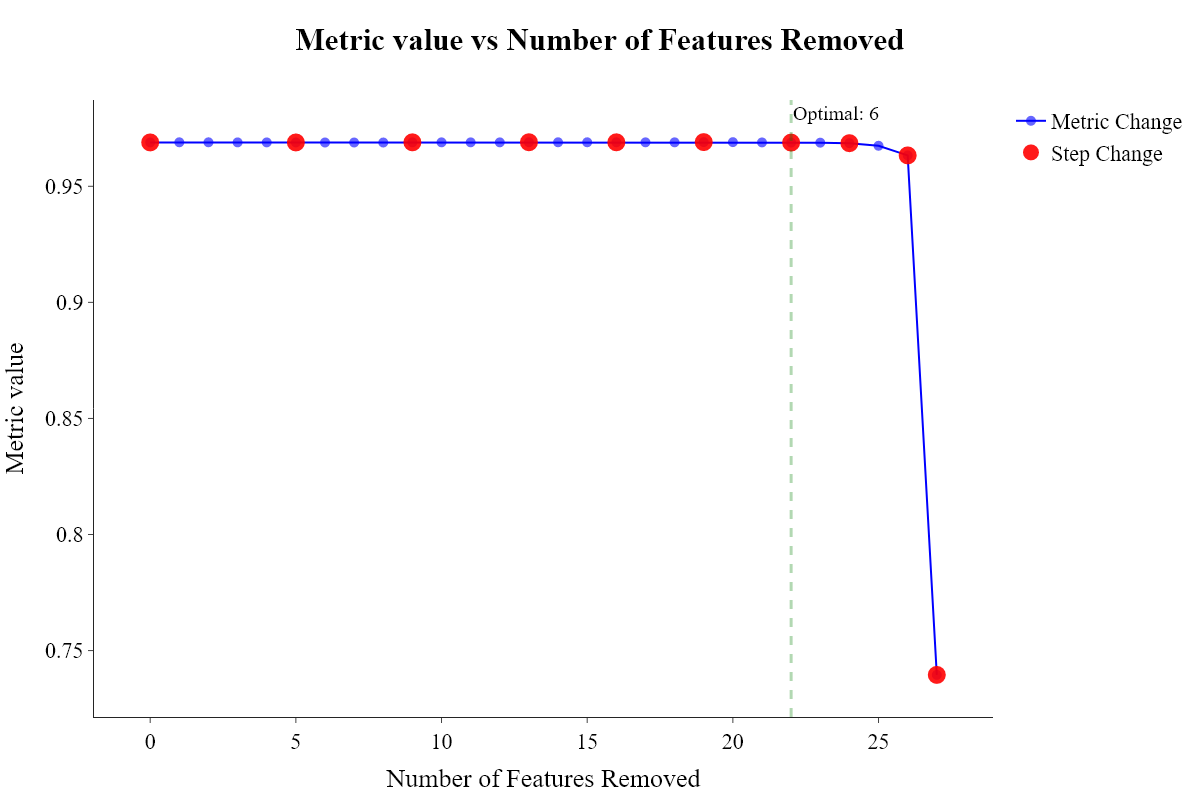

In [71]:
class ShapRecursiveFeatureElimination:
    """
    Recursive Feature Elimination with SHAP values for feature selection.
    This class implements a feature selection strategy that recursively removes features with the following steps:
        1. Cross-validate the model with the current set of features.
        2. Compute SHAP values for the current features.
        3. Evaluate the impact of removing each feature on the model's performance.
        4. Remove the feature that has the least impact on the model's performance.
        5. Repeat until the desired number of features is reached or no more features can be removed.
    """
    def __init__(
        self,
        algorithm,
        problem_type: str,
        metric: str,
        steps: int = 5,
        cv=KFold(n_splits=5, shuffle=True, random_state=17),
        alpha: float = 0.95,
        verbose: bool = True,
    ) -> None:
        """
        Initialize the ShapRecursiveFeatureElimination class.
        
        Args:
            algorithm (BaseEstimator): The machine learning algorithm to use for feature selection.
            problem_type (str): The type of problem, either "classification" or "regression".
            metric (str): The metric to use for evaluating the model's performance.
            steps (int, optional): The number of steps to perform in the feature elimination process. Defaults to 5.
            cv (sklearn.model_selection, optional): Cross-validation strategy. Defaults to KFold(n_splits=5, shuffle=True, random_state=17).
            alpha (float, optional): Weighting factor for the final score. Defaults to 0.95.
            verbose (bool, optional): Whether to print progress messages. Defaults to True.
        """
        self.algorithm = algorithm
        self.problem_type = problem_type
        self.metric = metric
        self.steps = steps
        self.cv = cv
        self.alpha = alpha
        self.verbose = verbose
        self.history_schema = {
            "step": int,
            "n_features_removed": int,
            "n_features_remaining": int,
            "removed_feature_name": object,
            "metric_value": float,
            "metric_change": float
        }
        if metric not in METRICS:
            raise ValueError(f"Unsupported metric: {metric}. Supported metrics are: {', '.join(METRICS.keys())}")
        self.eval_metric = METRICS[metric][0]
        self.metric_type = METRICS[metric][1]
        self.direction = METRICS[metric][2]
    
    def run(self, X: pd.DataFrame, y: pd.Series | np.ndarray) -> dict[str, list | pd.DataFrame]:
        """
        Run the SHAP Recursive Feature Elimination process.

        Args:
            X (pd.DataFrame): Input features.
            y (pd.Series | np.ndarray): Target variable.
        
        Returns:
            dict[str, list | pd.DataFrame]: Summary DataFrame containing selected features and their metrics.
        """
        current_features = list(X.columns)
        summary_df = {
            "selected_features": [],
            "selected_features_names": [],
            "history": pd.DataFrame(columns=self.history_schema.keys()).astype(self.history_schema)
        }
        removal_schedule = self.compute_removal_schedule(len(current_features))
        if self.verbose:
            print(f"🔍 Starting SHAP-RFE with {len(current_features)} features, target metric: {self.metric} ({self.direction}), steps: {self.steps}.\n📅 The number of features to remove every step: {removal_schedule}")

        # Step 0: base metric
        avg_base_metric, std_base_metric = self._cross_val_base_metric(X, y, current_features)
        summary_df["history"] = pd.concat([
            summary_df["history"],
            pd.DataFrame([{
                "step": 0,
                "n_features_removed": 0,
                "n_features_remaining": len(current_features),
                "removed_feature_name": None,
                "metric_value": avg_base_metric,
                "metric_change": 0.0
            }])
        ], ignore_index=True)

        for step_idx, n_features_to_remove in enumerate(removal_schedule):
            if self.verbose:
                print(f"\n🔁 Features remaining: {len(current_features)}")
            avg_metric_feature, fold_base_metric, fold_base_metric_std = self._cross_val_feature_metrics(X, y, current_features)
            feature_metric_diffs_df = pd.DataFrame(list(avg_metric_feature.items()), columns=["feature", "metric_change"])
            ascending = self.direction == "minimize"
            feature_metric_diffs_df = feature_metric_diffs_df.sort_values(by="metric_change", ascending=ascending)
            if self.verbose:
                print(f"📊 Average {self.metric}: {fold_base_metric:.6f} ± {fold_base_metric_std:.6f}")
            features_to_remove = feature_metric_diffs_df.head(n_features_to_remove)["feature"].tolist()
            self._log_step(summary_df, step_idx, X, current_features, avg_metric_feature, fold_base_metric, features_to_remove)

        summary_df["selected_features"], metric_selected = self.select_features_weighted_score(summary_df["history"], self.alpha)
        if self.verbose:
            print(f"\n🎯 Selected features: {summary_df['selected_features']}")
            diff_pct = 100 * (metric_selected - summary_df["history"].iloc[0]["metric_value"]) / summary_df["history"].iloc[0]["metric_value"]
            print(f"📈 Final {self.metric} score: {metric_selected:.6f} | Base: {summary_df['history'].iloc[0]['metric_value']:.6f} | Δ: {metric_selected - summary_df['history'].iloc[0]['metric_value']:.6f} ({diff_pct:+.2f}%)")
            n_features_initial = summary_df["history"].iloc[0]["n_features_remaining"]
            n_features_selected = len(summary_df["selected_features"])
            n_removed = n_features_initial - n_features_selected
            pct_removed = 100 * n_removed / n_features_initial
            print(f"🗑️ Features removed: {n_removed} of {n_features_initial} ({pct_removed:.2f}%)")
        return summary_df

    def compute_removal_schedule(self, total_features: int) -> list[int]:
        """
        Compute the number of features to remove at each step based on a linear decay schedule.
        
        Args:
            total_features (int): Total number of features to start with.
        
        Returns:
            list[int]: List of integers representing the number of features to remove at each step.
        """
        if total_features <= 0 or self.steps <= 0:
            return []
        decay = np.linspace(1, 0.2, self.steps)
        weights = decay / decay.sum()
        removal_counts = np.round(weights * total_features).astype(int)
        diff = total_features - removal_counts.sum()
        for i in range(abs(diff)):
            idx = i % self.steps
            removal_counts[idx] += 1 if diff > 0 else -1
        removal_counts = removal_counts[removal_counts > 0]
        return removal_counts.tolist()
    
    def _cross_val_base_metric(self, X: pd.DataFrame, y: pd.Series, features: list[str]) -> tuple[float, float]:
        """
        Compute the base metric using cross-validation on the provided features.

        Args:
            X (pd.DataFrame): Input features.
            y (pd.Series): Target variable.
            features (list[str]): List of feature names to use for the model.
        
        Returns:
            tuple[float, float]: Mean and standard deviation of the base metric across folds.
        """
        fold_base_metric = []
        for train_index, valid_index in self.cv.split(X[features], y):
            X_train, X_valid = X.iloc[train_index][features], X.iloc[valid_index][features]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            fitted_algorithm = fit_algorithm(self.algorithm, X_train, y_train, X_valid, y_valid)
            y_valid_pred = fitted_algorithm.predict(X_valid)
            base_metric = self.eval_metric(y_valid, y_valid_pred)
            fold_base_metric.append(base_metric)
        return np.mean(fold_base_metric), np.std(fold_base_metric)

    def _cross_val_feature_metrics(self, X: pd.DataFrame, y: pd.Series, current_features: list[str]) -> tuple[dict[str, float], float, float]:
        """
        Compute the average metric for each feature by removing it and evaluating the model's performance.

        Args:
            X (pd.DataFrame): Input features.
            y (pd.Series): Target variable.
            current_features (list[str]): List of feature names to evaluate.
        
        Returns:
            tuple[dict[str, float], float, float]: A dictionary with average metrics for each feature, the base metric, and its standard deviation.
        """
        fold_features_metric_monitor = {feature: [] for feature in current_features}
        fold_base_metric = []
        for train_index, valid_index in self.cv.split(X[current_features], y):
            X_train, X_valid = X.iloc[train_index][current_features], X.iloc[valid_index][current_features]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            fitted_algorithm = fit_algorithm(self.algorithm, X_train, y_train, X_valid, y_valid)
            y_valid_pred = fitted_algorithm.predict(X_valid)
            base_metric = self.eval_metric(y_valid, y_valid_pred)
            fold_base_metric.append(base_metric)
            shap_values = compute_shap_values(fitted_algorithm, X_valid, current_features)
            for idx, feature in enumerate(current_features):
                shap_reduced = shap_values.values.copy()
                shap_reduced[:, idx] = 0
                if self.problem_type == "classification":
                    pred_logit = shap_values.base_values[0] + shap_reduced.sum(axis=1)
                    pred_prob = 1 / (1 + np.exp(-pred_logit))
                    reduced_prediction = (pred_prob >= 0.5).astype(int)
                else:
                    reduced_prediction = shap_values.base_values[0] + shap_reduced.sum(axis=1)
                metric_without_feature = self.eval_metric(y_valid, reduced_prediction)
                fold_features_metric_monitor[feature].append(metric_without_feature)
        avg_metric_feature = {feature: np.mean(fold_features_metric_monitor[feature]) for feature in current_features}
        return avg_metric_feature, np.mean(fold_base_metric), np.std(fold_base_metric)

    def _log_step(self, summary_df: dict, step_idx: int, X: pd.DataFrame, current_features: list[str], avg_metric_feature: dict[str, float], fold_base_metric: float, features_to_remove: list[str]) -> None:
        """
        Log the results of the current step in the summary DataFrame.

        Args:
            summary_df (dict): Summary DataFrame to log the results.
            step_idx (int): Current step index.
            X (pd.DataFrame): Input features.
            current_features (list[str]): List of feature names remaining after previous steps.
            avg_metric_feature (dict[str, float]): Average metric for each feature.
            fold_base_metric (float): Base metric value from the current fold.
            features_to_remove (list[str]): List of feature names to remove in the current step.
        """
        for feature in features_to_remove:
            summary_df["history"] = pd.concat([
                summary_df["history"],
                pd.DataFrame([{
                    "step": step_idx,
                    "n_features_removed": len(X.columns) - len(current_features) + 1,
                    "n_features_remaining": len(current_features) - 1,
                    "removed_feature_name": feature,
                    "metric_value": avg_metric_feature[feature],
                    "metric_change": avg_metric_feature[feature] - fold_base_metric
                }])
            ], ignore_index=True)
            current_features.remove(feature)

    def select_features_weighted_score(self, history: pd.DataFrame, alpha: float = None) -> tuple[list[str], float]:
        """
        Select features based on a weighted score computed from the history of feature removals.
        
        Args:
            history (pd.DataFrame): DataFrame containing the history of feature removals and their metrics.
            alpha (float, optional): Weighting factor for the metric vs features score. Defaults to self.alpha.
            
        Returns:
            tuple[list[str], float]: Tuple containing the list of selected feature names and the best metric value.
        """
        if history.empty:
            return [], None
        df = history.copy()
        if self.direction == "maximize":
            df["metric_norm"] = (df["metric_value"] - df["metric_value"].min()) / (df["metric_value"].max() - df["metric_value"].min())
        else:
            df["metric_norm"] = (df["metric_value"].max() - df["metric_value"]) / (df["metric_value"].max() - df["metric_value"].min())
        df["features_norm"] = 1 - (df["n_features_remaining"] - df["n_features_remaining"].min()) / (df["n_features_remaining"].max() - df["n_features_remaining"].min())
        df["score"] = alpha * df["metric_norm"] + (1 - alpha) * df["features_norm"]
        best_row = df.loc[df["score"].idxmax()]
        removed = set(history[history["step"] < best_row["step"]]["removed_feature_name"].dropna())
        all_features = set(history["removed_feature_name"].dropna().unique())
        selected = list(all_features - removed)
        return selected, best_row["metric_value"]

shap_rfe = ShapRecursiveFeatureElimination(
    algorithm=ensemble_model,
    problem_type=PROBLEM_TYPE,
    metric=compare_metric_name,
    steps=10,
    cv=CV,
    alpha=0.99,
    verbose=True
)
shap_rfe_summary = shap_rfe.run(train_data[independent_features], train_data[target_feature])
plots.plot_metric_change_vs_features_removed(shap_rfe_summary["history"], optimal_n_features=len(shap_rfe_summary["selected_features"]))

In [72]:
print(f"selected_features = {shap_rfe_summary['selected_features']}")

selected_features = ['consistent_introvert', 'strong_introvert_signal', 'Going_outside', 'solitude_social_balance', 'Drained_after_socializing', 'Stage_fear']


In [73]:
# independent_features = shap_rfe_summary['selected_features'].copy()
# categorical_features = [feature for feature in independent_features if train_data[feature].dtype.name == 'category']
# train_data = train_data[independent_features + [target_feature]].copy()
# test_data = test_data[independent_features].copy()

In [74]:
# train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], ensemble_model, cv=CV, metric_name=compare_metric_name)
# print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
# print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

# Hyperparameter tuning

In [75]:
class RandomSearchCV:
    def __init__(
        self,
        algorithm: object,
        metric: str,
        cv: sklearn.model_selection.BaseCrossValidator = KFold(n_splits=5, shuffle=True, random_state=17),
        n_trials: int = 100,
        seed: int = 17,
        gap_weight: float = 0.3,
    ):
        self.algorithm = algorithm
        self.cv = cv
        self.n_trials = n_trials
        self.seed = seed
        self.gap_weight = gap_weight

        if metric not in METRICS:
            raise ValueError(f"Unsupported metric: {metric}. Supported metrics are: {', '.join(METRICS.keys())}")
        self.eval_metric = METRICS[metric][0]
        self.metric_type = METRICS[metric][1]
        self.direction = METRICS[metric][2]

    def tune(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        params_grid: dict[str, tuple[str, list[object]]],
        X_valid: pd.DataFrame = None,
        y_valid: pd.Series = None,
    ) -> optuna.study.Study:
        self.params_grid = params_grid
        study = self.create_study()
        X, y = self.check_X(X), self.check_y(y)
        if X_valid is not None and y_valid is not None:
            X_valid = self.check_X(X_valid)
            y_valid = self.check_y(y_valid)
            study.optimize(lambda trial: self.objective(trial, X, y, X_valid, y_valid), n_trials=self.n_trials)
        else:
            study.optimize(lambda trial: self.objective_cv(trial, X, y), n_trials=self.n_trials)
        return study

    def create_study(self) -> optuna.study.Study:
        sampler = optuna.samplers.TPESampler(seed=self.seed)
        return optuna.create_study(
            direction=self.direction,
            sampler=sampler,
            study_name="Optuna tuning"
        )

    def get_param(self, trial: optuna.Trial, param_name: str, param_values: tuple[str, list[object]]) -> object:
        param_type, param_value = param_values
        if param_type == "int":
            return trial.suggest_int(param_name, *param_value)
        elif param_type == "float":
            return trial.suggest_float(param_name, *param_value, log=True)
        elif param_type == "categorical":
            return trial.suggest_categorical(param_name, param_value)
        elif param_type == "constant":
            return param_value[0]

    def objective(self, trial: optuna.Trial, X_train: pd.DataFrame, y_train: pd.Series, X_valid: pd.DataFrame, y_valid: pd.Series) -> float:
        params = {k: self.get_param(trial, k, v) for k, v in self.params_grid.items()}
        model = self.algorithm.set_params(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid) if self.metric_type == "preds" else model.predict_proba(X_valid)
        return self.eval_metric(y_valid, preds)

    def objective_cv(self, trial: optuna.Trial, X: pd.DataFrame, y: pd.Series) -> float:
        params = {k: self.get_param(trial, k, v) for k, v in self.params_grid.items()}
        self.algorithm = self.algorithm.__class__(**params)
        X_sample = X.sample(n=min(100000, X.shape[0]))
        y_sample = y[X_sample.index]
        valid_scores = []
        for train_idx, valid_idx in self.cv.split(X_sample, y_sample):
            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
            _, y_valid_pred = fit_and_predict(
                self.algorithm, X_train, y_train, X_valid, y_valid, metric_type=self.metric_type
            )
            valid_scores.append(self.eval_metric(y_valid, y_valid_pred))
        mean_valid = np.mean(valid_scores)
        return mean_valid

    @staticmethod
    def check_X(X: object) -> pd.DataFrame:
        return X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)

    @staticmethod
    def check_y(y: object) -> pd.Series:
        return y if isinstance(y, pd.Series) else pd.Series(y)

## LightGBM

In [76]:
model = LGBMClassifier()
cv = RandomSearchCV(
    algorithm=model,
    metric=compare_metric_name,
    cv=CV,
    n_trials=N_TRIALS,
    seed=SEED
)

constant_params_grid = {
    "objective": ("constant", ["binary"]),
    "metric": ("constant", ["binary_logloss"]),
    "boosting_type": ("constant", ["gbdt"]),
    "seed": ("constant", [SEED]),
    "verbose": ("constant", [-1]),
    "n_jobs": ("constant", [-1]),
    "early_stopping_rounds": ("constant", [100]),
}
tunable_params_grid = {
    "n_estimators": ("int", [50, 1000]),
    "learning_rate": ("float", [1e-3, 0.3]),
    "num_leaves": ("int", [10, 450]),
    "max_depth": ("int", [3, 30]),
    "min_child_samples": ("int", [10, 300]),
    "subsample": ("float", [0.3, 1.0]),
    "colsample_bytree": ("float", [0.3, 1.0]),
    "reg_alpha": ("float", [1e-3, 10]),
    "reg_lambda": ("float", [1e-3, 10]),
    "min_split_gain": ("float", [1e-3, 1.0]),
    "class_weight": ("categorical", ["balanced", None]),
}
params_grid = {**constant_params_grid, **tunable_params_grid}

study = cv.tune(
    train_data[independent_features],
    train_data[target_feature],
    params_grid
)
lgbm_best_params = study.best_trial.params
constant_params = {k: v[1][0] for k, v in constant_params_grid.items()}
lgbm_best_params = {**constant_params, **lgbm_best_params}
print(lgbm_best_params)

[I 2025-07-16 19:53:00,902] A new study created in memory with name: Optuna tuning
[I 2025-07-16 19:53:10,153] Trial 0 finished with value: 0.9678363457239209 and parameters: {'n_estimators': 330, 'learning_rate': 0.0206218550445619, 'num_leaves': 94, 'max_depth': 4, 'min_child_samples': 239, 'subsample': 0.6611562428979949, 'colsample_bytree': 0.6463494460474463, 'reg_alpha': 0.200637253882253, 'reg_lambda': 0.0014330180633302001, 'min_split_gain': 0.011842429649211153, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9678363457239209.
[I 2025-07-16 19:53:17,348] Trial 1 finished with value: 0.9692128872605171 and parameters: {'n_estimators': 871, 'learning_rate': 0.1489892757056193, 'num_leaves': 32, 'max_depth': 21, 'min_child_samples': 170, 'subsample': 0.6159539361624266, 'colsample_bytree': 0.5369676166167222, 'reg_alpha': 0.013550416471161316, 'reg_lambda': 0.01552039868746451, 'min_split_gain': 0.04836450152043277, 'class_weight': None}. Best is trial 1 with value: 0.

{'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'seed': 17, 'verbose': -1, 'n_jobs': -1, 'early_stopping_rounds': 100, 'n_estimators': 687, 'learning_rate': 0.05196489809973422, 'num_leaves': 97, 'max_depth': 18, 'min_child_samples': 135, 'subsample': 0.7283003131333855, 'colsample_bytree': 0.5371604556889338, 'reg_alpha': 0.08668208442415865, 'reg_lambda': 0.0033324656779342003, 'min_split_gain': 0.054250989847737456, 'class_weight': None}


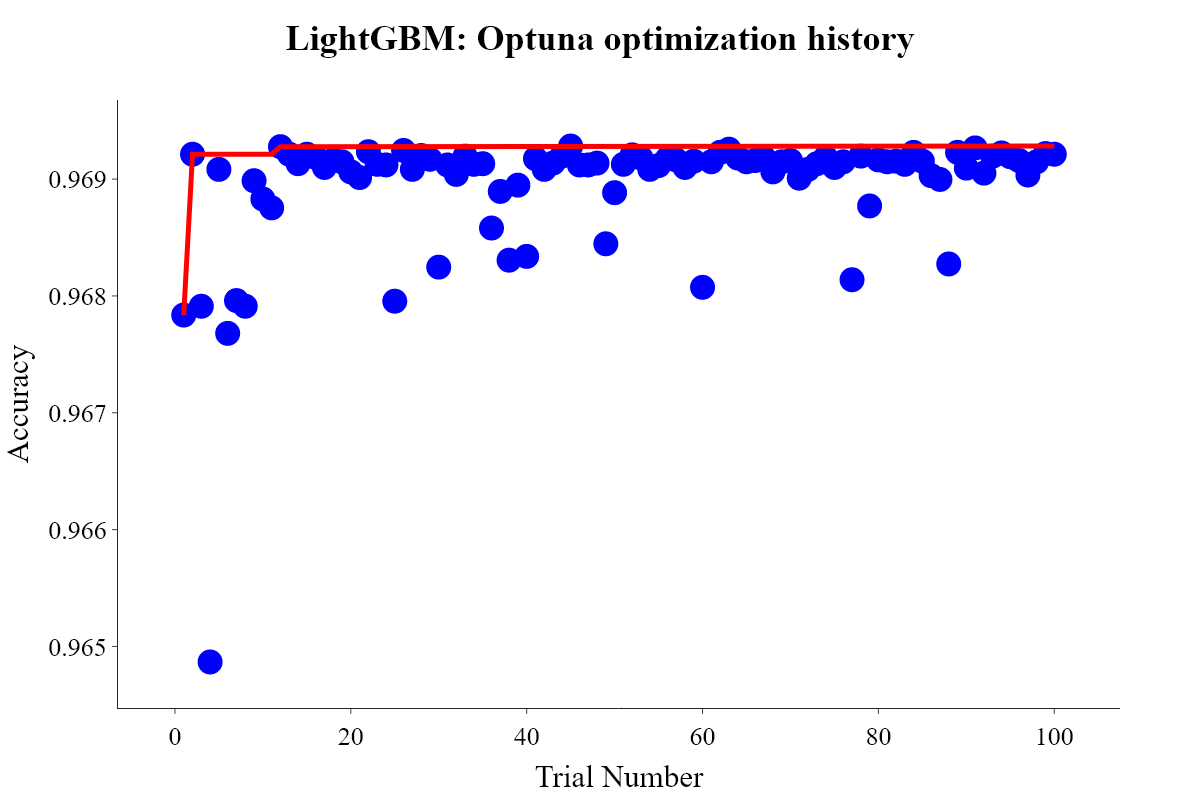

In [77]:
plots.plot_optuna_optimization_history(study, compare_metric_name, plot_title="LightGBM: Optuna optimization history", direction=METRICS[compare_metric_name][2])

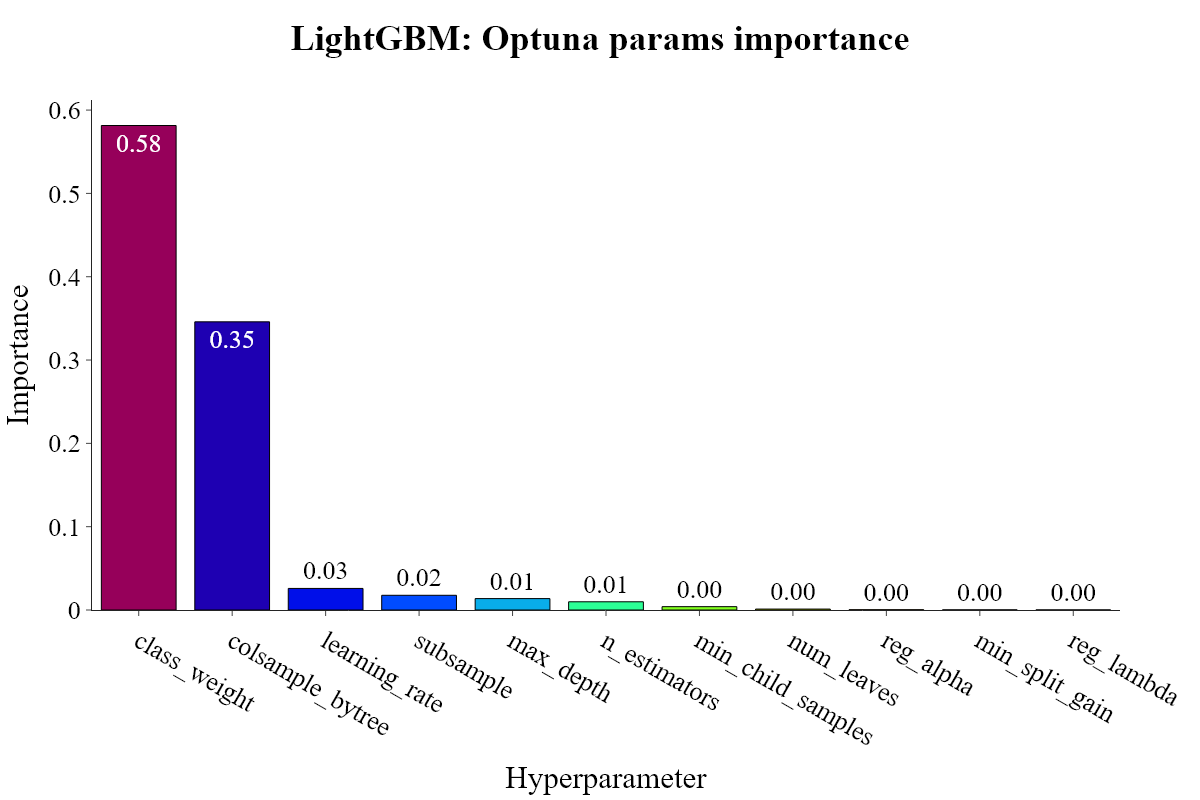

In [78]:
plots.plot_optuna_param_importance(study, plot_title="LightGBM: Optuna params importance")

In [79]:
model = LGBMClassifier(**lgbm_best_params)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9694 +- 0.0006
Validation Accuracy: 0.9692 +- 0.0026


## LightGBM (goss)

In [80]:
model = LGBMClassifier()
cv = RandomSearchCV(
    algorithm=model,
    metric=compare_metric_name,
    cv=CV,
    n_trials=N_TRIALS,
    seed=SEED
)

constant_params_grid = {
    "objective": ("constant", ["binary"]),
    "metric": ("constant", ["binary_logloss"]),
    "boosting_type": ("constant", ["goss"]),
    "seed": ("constant", [SEED]),
    "verbose": ("constant", [-1]),
    "n_jobs": ("constant", [-1]),
    "early_stopping_rounds": ("constant", [100]),
}
tunable_params_grid = {
    "n_estimators": ("int", [50, 1000]),
    "learning_rate": ("float", [1e-3, 0.3]),
    "num_leaves": ("int", [10, 450]),
    "max_depth": ("int", [3, 30]),
    "min_child_samples": ("int", [10, 300]),
    "subsample": ("float", [0.3, 1.0]),
    "colsample_bytree": ("float", [0.3, 1.0]),
    "reg_alpha": ("float", [1e-3, 10]),
    "reg_lambda": ("float", [1e-3, 10]),
    "min_split_gain": ("float", [1e-3, 1.0]),
    "class_weight": ("categorical", ["balanced", None]),
}
params_grid = {**constant_params_grid, **tunable_params_grid}

study = cv.tune(
    train_data[independent_features],
    train_data[target_feature],
    params_grid
)
lgbm_goss_best_params = study.best_trial.params
constant_params = {k: v[1][0] for k, v in constant_params_grid.items()}
lgbm_goss_best_params = {**constant_params, **lgbm_goss_best_params}
print(lgbm_goss_best_params)

[I 2025-07-16 20:15:31,496] A new study created in memory with name: Optuna tuning
[I 2025-07-16 20:15:43,005] Trial 0 finished with value: 0.967944306479773 and parameters: {'n_estimators': 330, 'learning_rate': 0.0206218550445619, 'num_leaves': 94, 'max_depth': 4, 'min_child_samples': 239, 'subsample': 0.6611562428979949, 'colsample_bytree': 0.6463494460474463, 'reg_alpha': 0.200637253882253, 'reg_lambda': 0.0014330180633302001, 'min_split_gain': 0.011842429649211153, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.967944306479773.
[I 2025-07-16 20:15:49,957] Trial 1 finished with value: 0.9690509206227063 and parameters: {'n_estimators': 871, 'learning_rate': 0.1489892757056193, 'num_leaves': 32, 'max_depth': 21, 'min_child_samples': 170, 'subsample': 0.6159539361624266, 'colsample_bytree': 0.5369676166167222, 'reg_alpha': 0.013550416471161316, 'reg_lambda': 0.01552039868746451, 'min_split_gain': 0.04836450152043277, 'class_weight': None}. Best is trial 1 with value: 0.96

{'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'goss', 'seed': 17, 'verbose': -1, 'n_jobs': -1, 'early_stopping_rounds': 100, 'n_estimators': 769, 'learning_rate': 0.05443203483475572, 'num_leaves': 369, 'max_depth': 9, 'min_child_samples': 87, 'subsample': 0.4137283808882335, 'colsample_bytree': 0.4434826355189087, 'reg_alpha': 0.0017534576228199084, 'reg_lambda': 0.019468813747800646, 'min_split_gain': 0.012887706688343032, 'class_weight': None}


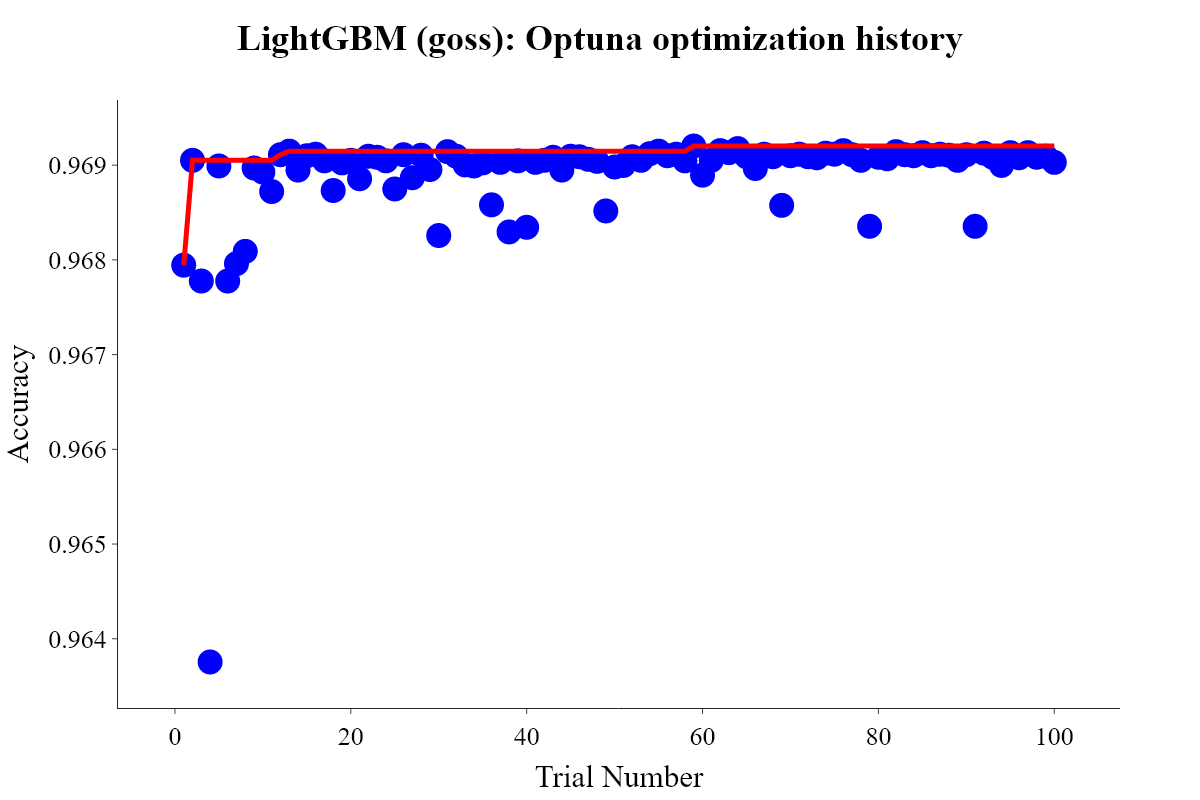

In [81]:
plots.plot_optuna_optimization_history(study, compare_metric_name, plot_title="LightGBM (goss): Optuna optimization history", direction=METRICS[compare_metric_name][2])

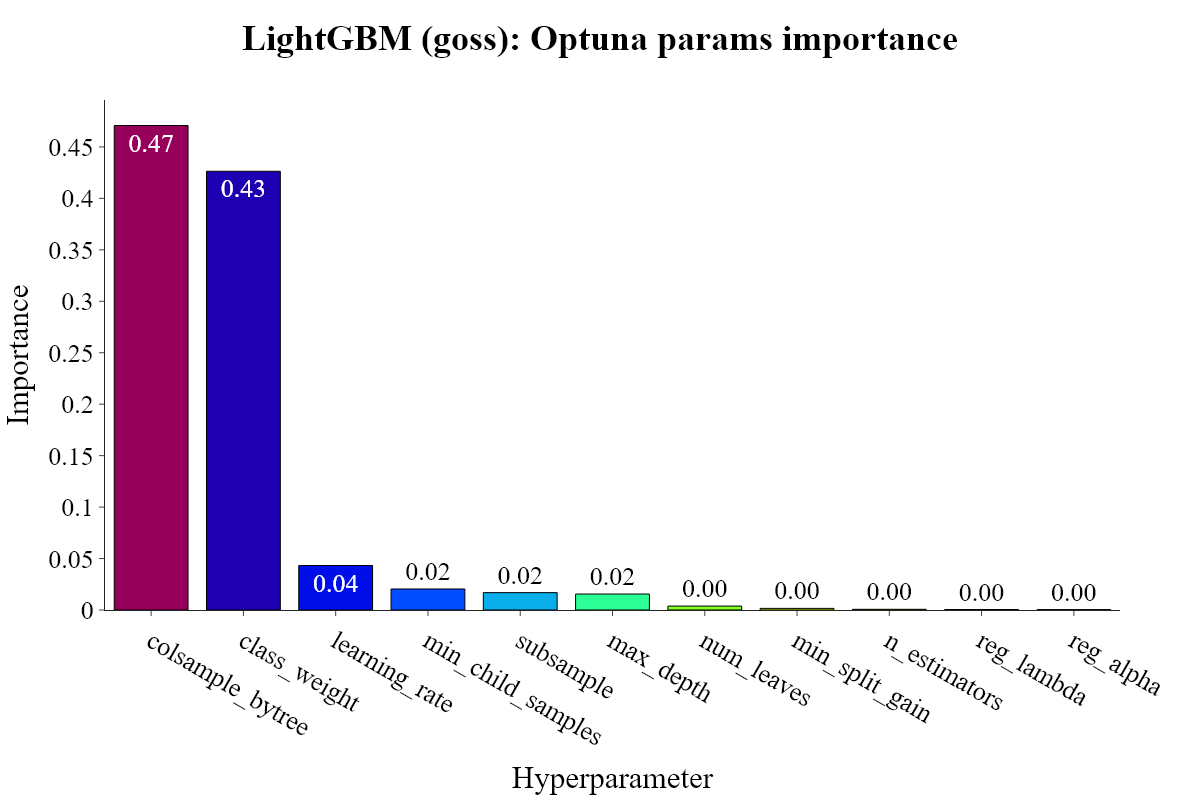

In [82]:
plots.plot_optuna_param_importance(study, plot_title="LightGBM (goss): Optuna params importance")

In [83]:
model = LGBMClassifier(**lgbm_goss_best_params)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=SEED), metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9694 +- 0.0006
Validation Accuracy: 0.9691 +- 0.0025


## XGBoost

In [84]:
model = XGBClassifier()
cv = RandomSearchCV(
    algorithm=model,
    metric=compare_metric_name,
    cv=CV,
    n_trials=N_TRIALS,
    seed=SEED
)

scale_pos_weight = train_data[target_feature].value_counts().get(0, 0) / train_data[target_feature].value_counts().get(1, 1)
constant_params_grid = {
    "objective": ("constant", ["binary:logistic"]),
    "eval_metric": ("constant", ["logloss"]),
    "seed": ("constant", [SEED]),
    "verbosity": ("constant", [0]),
    "n_jobs": ("constant", [-1]),
    "tree_method": ("constant", ["hist"]),
    "enable_categorical": ("constant", [True]),
    "early_stopping_rounds": ("constant", [100]),
}
tunable_params_grid = {
    "n_estimators": ("int", [50, 1000]),
    "learning_rate": ("float", [1e-3, 0.3]),
    "max_depth": ("int", [3, 30]),
    "min_child_weight": ("int", [1, 100]),
    "subsample": ("float", [0.3, 1.0]),
    "colsample_bytree": ("float", [0.3, 1.0]),
    "gamma": ("float", [1e-3, 10.0]),
    "reg_alpha": ("float", [1e-3, 10]),
    "reg_lambda": ("float", [1e-3, 10]),
    "scale_pos_weight": ("categorical", [scale_pos_weight, 1.0]),
}
params_grid = {**constant_params_grid, **tunable_params_grid}

study = cv.tune(
    train_data[independent_features],
    train_data[target_feature],
    params_grid
)
xgb_best_params = study.best_trial.params
constant_params = {k: v[1][0] for k, v in constant_params_grid.items()}
xgb_best_params = {**constant_params, **xgb_best_params}
print(xgb_best_params)

[I 2025-07-16 20:39:49,520] A new study created in memory with name: Optuna tuning
[I 2025-07-16 20:40:08,265] Trial 0 finished with value: 0.9690834200470438 and parameters: {'n_estimators': 330, 'learning_rate': 0.0206218550445619, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.7737830722497602, 'colsample_bytree': 0.6611562428979949, 'gamma': 0.3548816830746042, 'reg_alpha': 0.200637253882253, 'reg_lambda': 0.0014330180633302001, 'scale_pos_weight': 1.0}. Best is trial 0 with value: 0.9690834200470438.
[I 2025-07-16 20:40:17,006] Trial 1 finished with value: 0.969040089424425 and parameters: {'n_estimators': 107, 'learning_rate': 0.138145600849423, 'max_depth': 27, 'min_child_weight': 6, 'subsample': 0.6580472549057305, 'colsample_bytree': 0.5829352503057804, 'gamma': 0.24550085725408072, 'reg_alpha': 0.0859240021375131, 'reg_lambda': 0.013550416471161316, 'scale_pos_weight': 1.0}. Best is trial 0 with value: 0.9690834200470438.
[I 2025-07-16 20:40:27,345] Trial 2 finished wi

{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 17, 'verbosity': 0, 'n_jobs': -1, 'tree_method': 'hist', 'enable_categorical': True, 'early_stopping_rounds': 100, 'n_estimators': 852, 'learning_rate': 0.13882531265784764, 'max_depth': 20, 'min_child_weight': 16, 'subsample': 0.9731816698929993, 'colsample_bytree': 0.4208656979220874, 'gamma': 0.19555692795354224, 'reg_alpha': 0.0017483443319517976, 'reg_lambda': 0.5267881314864609, 'scale_pos_weight': 1.0}


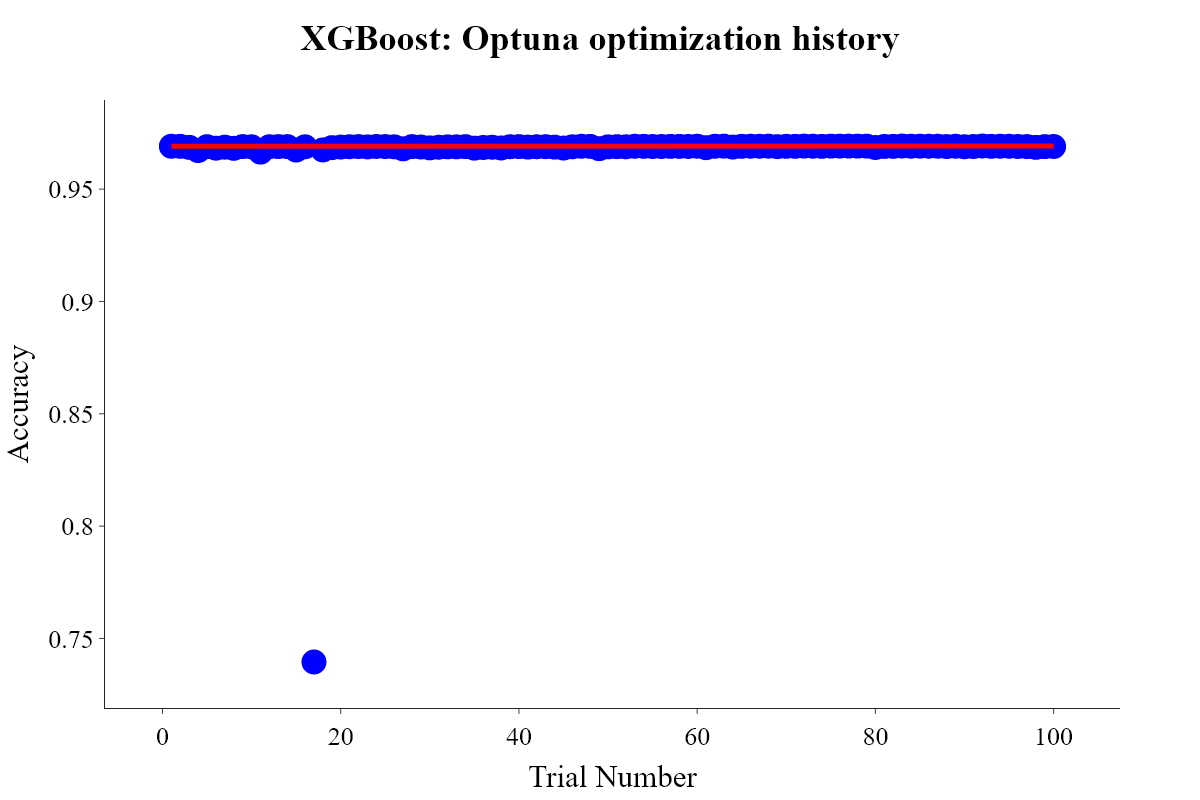

In [85]:
plots.plot_optuna_optimization_history(study, compare_metric_name, plot_title="XGBoost: Optuna optimization history", direction=METRICS[compare_metric_name][2])

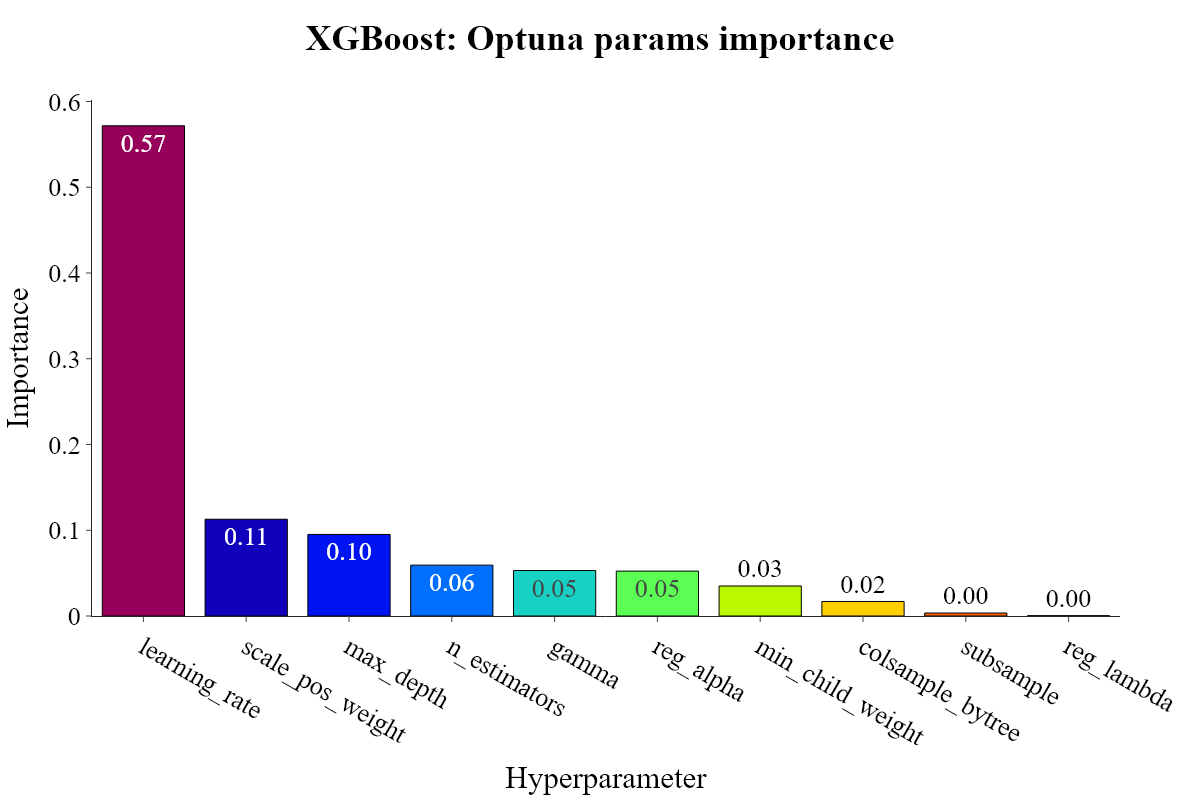

In [86]:
plots.plot_optuna_param_importance(study, plot_title="XGBoost: Optuna params importance")

In [87]:
model = XGBClassifier(**xgb_best_params)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9694 +- 0.0006
Validation Accuracy: 0.9691 +- 0.0025


## Catboost

In [ ]:
model = CatBoostClassifier()
cv = RandomSearchCV(
    algorithm=model,
    metric=compare_metric_name,
    cv=CV,
    n_trials=N_TRIALS,
    seed=SEED
)

constant_params_grid = {
    "random_state": ("constant", [SEED]),
    "verbose": ("constant", [0]),
    "cat_features": ("constant", [categorical_features]),
    "task_type": ("constant", ["GPU"]),
    "loss_function": ("constant", ["Logloss"]),
    "eval_metric": ("constant", ["Logloss"]),
    "early_stopping_rounds": ("constant", [100]),
}
tunable_params_grid = {
    "iterations": ("int", [50, 1000]),
    "learning_rate": ("float", [1e-3, 0.3]),
    "depth": ("int", [3, 10]),
    "l2_leaf_reg": ("float", [1e-3, 30]),
    "random_strength": ("float", [1e-3, 10.0]),
    "bagging_temperature": ("float", [0.3, 1.0]),
    "border_count": ("int", [32, 255]),
    "min_data_in_leaf": ("int", [1, 300]),
    "auto_class_weights": ("categorical", ["Balanced", "SqrtBalanced", None]),
}
params_grid = {**constant_params_grid, **tunable_params_grid}

study = cv.tune(
    train_data[independent_features],
    train_data[target_feature],
    params_grid
)
catboost_best_params = study.best_trial.params
constant_params = {k: v[1][0] for k, v in constant_params_grid.items()}
catboost_best_params = {**constant_params, **catboost_best_params}
print(catboost_best_params)

In [ ]:
plots.plot_optuna_optimization_history(study, compare_metric_name, plot_title="Catboost: Optuna optimization history", direction=METRICS[compare_metric_name][2])

In [ ]:
plots.plot_optuna_param_importance(study, plot_title="Catboost: Optuna params importance")

In [ ]:
model = CatBoostClassifier(**catboost_best_params)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

## Ensemble weight tuning

In [88]:
class EnsembleWeightTunerCV:
    def __init__(
        self,
        estimators: list,
        problem_type: str,
        metric: str,
        cv=KFold(n_splits=5, shuffle=True, random_state=17),
        n_trials: int = 50,
        seed: int = 17,
    ):
        self.estimators = estimators
        self.problem_type = problem_type
        self.cv = cv
        self.n_trials = n_trials
        self.seed = seed

        if metric not in METRICS:
            raise ValueError(f"Unsupported metric: {metric}. Supported: {', '.join(METRICS.keys())}")
        self.eval_metric = METRICS[metric][0]
        self.metric_type = METRICS[metric][1]
        self.direction = METRICS[metric][2]

    def tune(self, X, y) -> optuna.Study:
        # X_sample = X.sample(n=min(20000, X.shape[0]))
        # y_sample = y[X_sample.index]
        y_true, y_pred = self.perform_cv(X, y)
        study = self.create_study()
        study.optimize(
            lambda trial: self.objective(trial, y_true, y_pred),
            n_trials=self.n_trials,
        )
        self.best_weights = np.array([study.best_params[f"w{i}"] for i in range(len(self.estimators))])
        self.best_weights = self.best_weights / self.best_weights.sum()
        return study
    
    def create_study(self) -> optuna.study.Study:
        sampler = optuna.samplers.TPESampler(seed=self.seed)
        return optuna.create_study(
            direction=self.direction,
            sampler=sampler,
            study_name="Weight Tuning Study",
        )

    def objective(self, trial, y_true, y_pred):
        weights = np.array([trial.suggest_float(f"w{i}", 0.01, 0.99) for i in range(len(self.estimators))])
        weights /= weights.sum()
        blended = sum(w * p for w, p in zip(weights, y_pred))
        if self.problem_type == "classification":
            blended = np.argmax(blended, axis=1)
        return self.eval_metric(y_true, blended)

    def perform_cv(self, X: pd.DataFrame, y: pd.Series) -> tuple:
        y_valid_true = []
        y_valid_pred = [[] for _ in range(len(self.estimators))]
        for train_idx, valid_idx in self.cv.split(X, y):
            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
            y_valid_true.extend(y_valid.tolist())
            for i, estimator in enumerate(self.estimators):
                _, pred = fit_and_predict(
                    estimator, X_train, y_train, X_valid, y_valid,
                    metric_type="probs" if self.problem_type == "classification" else self.metric_type
                )
                y_valid_pred[i].extend(pred.tolist())
        y_valid_true = np.array(y_valid_true)
        y_valid_pred = [np.array(pred) for pred in y_valid_pred]
        return y_valid_true, y_valid_pred

    @staticmethod
    def check_X(X: object) -> pd.DataFrame:
        return X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)

    @staticmethod
    def check_y(y: object) -> pd.Series:
        return y if isinstance(y, pd.Series) else pd.Series(y)

ensemble_weights_tuner = EnsembleWeightTunerCV(
    estimators = [
    LGBMClassifier(**lgbm_best_params),
    LGBMClassifier(**lgbm_goss_best_params),
    XGBClassifier(**xgb_best_params),
    XGBClassifier(booster="dart", random_state=SEED, n_jobs=-1, objective='binary:logistic', eval_metric='logloss', enable_categorical=True, tree_method='hist', verbosity=0, early_stopping_rounds=100),
    CatBoostClassifier(random_state=SEED, verbose=0, cat_features=categorical_features, task_type='GPU', loss_function='Logloss', eval_metric='Logloss', early_stopping_rounds=100)
    ],
    problem_type=PROBLEM_TYPE,
    metric=compare_metric_name,
    cv=CV,
    n_trials=N_TRIALS*3,
    seed=SEED,
)
ensemble_weights_tuner.tune(train_data[independent_features], train_data[target_feature])
best_weights = ensemble_weights_tuner.best_weights
for i, estimator in enumerate(ensemble_weights_tuner.estimators):
    print(f"Estimator {i}: {estimator.__class__.__name__}, Weight: {best_weights[i]:.4f}")

[I 2025-07-16 21:07:05,615] A new study created in memory with name: Weight Tuning Study
[I 2025-07-16 21:07:05,625] Trial 0 finished with value: 0.9690995465342259 and parameters: {'w0': 0.2987717026333675, 'w1': 0.5299750204931882, 'w2': 0.19769037120854496, 'w3': 0.07654235102746554, 'w4': 0.7812457507999151}. Best is trial 0 with value: 0.9690995465342259.
[I 2025-07-16 21:07:05,641] Trial 1 finished with value: 0.9691805225653206 and parameters: {'w0': 0.6532068513403384, 'w1': 0.6347704781227631, 'w2': 0.5740908358779733, 'w3': 0.04828165786508915, 'w4': 0.3606573323938779}. Best is trial 1 with value: 0.9691805225653206.
[I 2025-07-16 21:07:05,654] Trial 2 finished with value: 0.9691211401425178 and parameters: {'w0': 0.9367695230820394, 'w1': 0.06884378670907763, 'w2': 0.8567612614752868, 'w3': 0.8697447156250696, 'w4': 0.06016979230804462}. Best is trial 1 with value: 0.9691805225653206.
[I 2025-07-16 21:07:05,662] Trial 3 finished with value: 0.9691805225653206 and parameters

Estimator 0: LGBMClassifier, Weight: 0.2881
Estimator 1: LGBMClassifier, Weight: 0.3270
Estimator 2: XGBClassifier, Weight: 0.2066
Estimator 3: XGBClassifier, Weight: 0.1318
Estimator 4: CatBoostClassifier, Weight: 0.0465


In [89]:
ensemble_model = EnsembleModel(estimators=ensemble_weights_tuner.estimators, problem_type=PROBLEM_TYPE, weights=ensemble_weights_tuner.best_weights)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], ensemble_model, cv=CV, metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9695 +- 0.0006
Validation Accuracy: 0.9693 +- 0.0025


In [104]:
class OOFEnsembleModel:
    """
    A class for creating an out-of-fold ensemble model from multiple base estimators.
    """
    def __init__(self, estimators: list, problem_type: str, weights: np.ndarray = None, cv: sklearn.model_selection.BaseCrossValidator = KFold(n_splits=5, shuffle=True, random_state=17) ) -> None:
        """
        Initialize the OOFEnsembleModel with a list of estimators and optional weights.
        
        Args:
            estimators (list): List of base estimators to include in the ensemble.
            problem_type (str): Type of problem, either "classification" or "regression".
            weights (np.ndarray, optional): Weights for each estimator. If None, equal weights are assigned. Defaults to None.
            cv (sklearn.model_selection.BaseCrossValidator, optional): Cross-validation strategy. Defaults to KFold(n_splits=5, shuffle=True, random_state=17).
        """
        self.estimators = estimators
        self.problem_type = problem_type
        self.weights = weights if weights is not None else np.ones(len(estimators)) / len(estimators)
        if len(self.estimators) != len(self.weights):
            raise ValueError("The number of estimators must match the number of weights.")
        self.cv = cv
        self.n_splits = self.cv.get_n_splits()
        self.n_repeats = getattr(self.cv, 'n_repeats', 1)
        self.trained_estimators = []
    
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame = None, **kwargs) -> np.ndarray:
        """
        Fit the ensemble model on the training data.

        Args:
            X_train (pd.DataFrame): Training features.
            y_train (pd.Series): Training target variable.
            X_test (pd.DataFrame, optional): Validation features. If provided, will be used to evaluate the model during training.

        Returns:
            np.ndarray: Out-of-fold predictions for the training data or predictions for the test data if provided.
        """
        n_classes = len(np.unique(y_train)) if self.problem_type == "classification" else None
        oof_predictions = np.zeros((X_test.shape[0], n_classes)) if self.problem_type == "classification" else np.zeros(X_train.shape[0])
        self.trained_estimators = []

        cv_splits = list(self.cv.split(X_train, y_train))
        for fold_idx, (train_index, valid_index) in enumerate(tqdm(cv_splits, desc="Training folds")):
            X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
            y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
            fold_predictions = np.zeros((X_test.shape[0], n_classes)) if self.problem_type == "classification" else np.zeros(X_test.shape[0])

            fold_estimators = []
            for i, estimator in enumerate(self.estimators):
                if estimator.__class__.__name__.startswith("CatBoost"):
                    idx = self.estimators.index(estimator)
                    estimator = clone(estimator)
                    categorical_features = X_train.select_dtypes(
                        include="category"
                    ).columns.tolist()
                    estimator.set_params(cat_features=categorical_features)
                    self.estimators[idx] = estimator
                sig = signature(estimator.fit)
                fit_params = {}
                if "eval_set" in sig.parameters:
                    fit_params["eval_set"] = [(X_valid_fold, y_valid_fold)]
                if "verbose" in sig.parameters:
                    fit_params["verbose"] = False
                if "X_val" and "y_val" in sig.parameters:
                    fit_params["X_val"] = X_valid_fold
                    fit_params["y_val"] = y_valid_fold
                cloned_estimator = clone(estimator)
                cloned_estimator.fit(X_train_fold, y_train_fold, **fit_params)
                fold_estimators.append(cloned_estimator)
                if self.problem_type == "classification":
                    fold_predictions += self.weights[i] * cloned_estimator.predict_proba(X_test)
                else:
                    fold_predictions += self.weights[i] * cloned_estimator.predict(X_test)

            self.trained_estimators.append(fold_estimators)
            oof_predictions += fold_predictions/(self.n_repeats)
        self.oof_predictions = oof_predictions/ len(self.trained_estimators)
        return self.oof_predictions
        preds = np.argmax(self.oof_predictions, axis=1) if self.problem_type == "classification" else self.oof_predictions.flatten()
        print(accuracy_score(y_train, preds))

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """
        Predict using the ensemble model on new data.

        Args:
            X (pd.DataFrame): Features for prediction.
        Returns:
            np.ndarray: Predicted values.
        """
        if not hasattr(self, 'trained_estimators') or not self.trained_estimators:
            raise ValueError("Model must be fitted before making predictions.")
            
        n_classes = self.oof_predictions.shape[1] if self.problem_type == "classification" else None
        predictions = np.zeros((X.shape[0], n_classes)) if self.problem_type == "classification" else np.zeros(X.shape[0])
        for fold_estimators in self.trained_estimators:
            fold_predictions = np.zeros((X.shape[0], n_classes)) if self.problem_type == "classification" else np.zeros(X.shape[0])
            for i, estimator in enumerate(fold_estimators):
                if self.problem_type == "classification":
                    fold_predictions += self.weights[i] * estimator.predict_proba(X)
                else:
                    fold_predictions += self.weights[i] * estimator.predict(X)
            predictions += fold_predictions/(self.n_repeats)
        predictions /= len(self.trained_estimators)
        if self.problem_type == "classification":
            predictions = np.argmax(predictions, axis=1)
        else:
            predictions = predictions.flatten()
        return predictions
    
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        """
        Predict class probabilities using the ensemble model on new data.

        Args:
            X (pd.DataFrame): Features for prediction.
        Returns:
            np.ndarray: Predicted class probabilities.
        """
        if not hasattr(self, 'trained_estimators') or not self.trained_estimators:
            raise ValueError("Model must be fitted before making predictions.")
        if self.problem_type != "classification":
            raise ValueError("predict_proba is only available for classification problems.")
        n_classes = self.oof_predictions.shape[1]
        predictions = np.zeros((X.shape[0], n_classes))
        for fold_estimators in self.trained_estimators:
            fold_predictions = np.zeros((X.shape[0], n_classes))
            for i, estimator in enumerate(fold_estimators):
                fold_predictions += self.weights[i] * estimator.predict_proba(X)
            predictions += fold_predictions/(self.n_repeats)
        predictions /= len(self.trained_estimators)
        return predictions

In [105]:
oof_ensemble_model = OOFEnsembleModel(estimators=ensemble_weights_tuner.estimators, problem_type=PROBLEM_TYPE, weights=ensemble_weights_tuner.best_weights, cv=CV)
# oof_ensemble_model = OOFEnsembleModel(estimators=ensemble_weights_tuner.estimators, problem_type=PROBLEM_TYPE, weights=ensemble_weights_tuner.best_weights, cv=KFold(n_splits=5, shuffle=True, random_state=SEED))
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], oof_ensemble_model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric_name=compare_metric_name)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Training folds: 100%|██████████| 50/50 [07:24<00:00,  8.89s/it]


Train Accuracy: 0.9694 +- 0.0006
Validation Accuracy: 0.9691 +- 0.0025


In [106]:
# final_model = ensemble_model
final_model = oof_ensemble_model

## Cutoff tuning

In [94]:
class CutoffTunerCV:
    def __init__(
        self,
        algorithm: object,
        metric: str,
        cv: sklearn.model_selection.BaseCrossValidator = KFold(n_splits=5, shuffle=True, random_state=17),
        n_trials: int = 50,
        seed: int = 17,
    ):
        self.algorithm = algorithm
        self.cv = cv
        self.n_trials = n_trials
        self.seed = seed

        if metric not in METRICS:
            raise ValueError(f"Unsupported metric: {metric}. Supported metrics are: {', '.join(METRICS.keys())}")
        self.eval_metric = METRICS[metric][0]
        self.direction = METRICS[metric][2]

    def tune(self, X: np.ndarray, y: np.ndarray) -> optuna.Study:
        """
        Perform cross-validation and tune cutoffs using Optuna.

        Args:
            X (np.ndarray): Feature matrix.
            y (np.ndarray): Target vector.
        
        Returns:
            optuna.Study: Optuna study object containing the results of the optimization.
        """
        y_true, y_proba = self.perform_cv(X, y)
        study = self.create_study()
        study.optimize(
            lambda trial: self.objective(trial, y_true, y_proba),
            n_trials=self.n_trials,
        )
        self.best_cutoffs = np.array([study.best_params[f"cutoff_{i}"] for i in range(y_proba.shape[1])])
        self.best_cutoffs = self.best_cutoffs / self.best_cutoffs.sum()
        return study
    
    def create_study(self) -> optuna.study.Study:
        """
        Create an Optuna study for tuning cutoffs.
        
        Returns:
            optuna.study.Study: Optuna study object.
        """
        sampler = optuna.samplers.TPESampler(seed=self.seed)
        return optuna.create_study(
            direction=self.direction,
            sampler=sampler,
            study_name="Optuna cutoff tuning"
        )
    
    def objective(self, trial, y_true: np.ndarray, y_proba: np.ndarray) -> float:
        """
        Objective function for Optuna to optimize cutoffs.
        
        Args:
            trial (optuna.Trial): Optuna trial object.
            y_true (np.ndarray): True labels.
            y_proba (np.ndarray): Predicted probabilities.
        
        Returns:
            float: Evaluated metric score.
        """
        n_classes = y_proba.shape[1]
        cutoffs = np.array([trial.suggest_float(f"cutoff_{i}", 0.01, 0.99) for i in range(n_classes)])
        cutoffs = cutoffs / cutoffs.sum()
        y_pred = np.argmax(y_proba / cutoffs, axis=1)
        return self.eval_metric(y_true, y_pred)
    
    def perform_cv(self, X: pd.DataFrame, y: pd.Series) -> tuple[np.ndarray, np.ndarray]:
        """
        Perform cross-validation and return true labels and predicted probabilities.
        
        Args:
            X (pd.DataFrame): Feature matrix.
            y (pd.Series): Target vector.
        
        Returns:
            tuple[np.ndarray, np.ndarray]: True labels and predicted probabilities.
        """
        y_valid_true = []
        y_valid_proba = []
        for train_idx, valid_idx in self.cv.split(X, y):
            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
            sig = signature(self.algorithm.fit)
            fit_params = {}
            if "eval_set" in sig.parameters:
                fit_params["eval_set"] = [(X_valid, y_valid)]
            if "verbose" in sig.parameters:
                fit_params["verbose"] = False
            if "X_val" and "y_val" in sig.parameters:
                fit_params["X_val"] = X_valid
                fit_params["y_val"] = y_valid
            self.algorithm.fit(X_train, y_train, **fit_params)
            y_valid_true.extend(y_valid.tolist())
            y_valid_proba.extend(self.algorithm.predict_proba(X_valid).tolist())
        return np.array(y_valid_true), np.array(y_valid_proba)

In [95]:
cutoff_tuner = CutoffTunerCV(
    algorithm=final_model,
    metric=compare_metric_name,
    cv=CV,
    n_trials=N_TRIALS*5,
    seed=SEED,
)
cutoff_tuner.tune(train_data[independent_features], train_data[target_feature])
cutoffs = cutoff_tuner.best_cutoffs
print("Optimal cutoffs:")
for i, cutoff in enumerate(cutoffs):
    print(f"   - {id2label[i]}: {cutoff:.4f}")

[I 2025-07-16 21:52:53,570] A new study created in memory with name: Optuna cutoff tuning
[I 2025-07-16 21:52:53,581] Trial 0 finished with value: 0.9688998056575254 and parameters: {'cutoff_0': 0.2987717026333675, 'cutoff_1': 0.5299750204931882}. Best is trial 0 with value: 0.9688998056575254.
[I 2025-07-16 21:52:53,592] Trial 1 finished with value: 0.968651479162168 and parameters: {'cutoff_0': 0.19769037120854496, 'cutoff_1': 0.07654235102746554}. Best is trial 0 with value: 0.9688998056575254.
[I 2025-07-16 21:52:53,603] Trial 2 finished with value: 0.9691319369466638 and parameters: {'cutoff_0': 0.7812457507999151, 'cutoff_1': 0.6532068513403384}. Best is trial 2 with value: 0.9691319369466638.
[I 2025-07-16 21:52:53,612] Trial 3 finished with value: 0.9691859209673936 and parameters: {'cutoff_0': 0.6347704781227631, 'cutoff_1': 0.5740908358779733}. Best is trial 3 with value: 0.9691859209673936.
[I 2025-07-16 21:52:53,621] Trial 4 finished with value: 0.9619682573958108 and param

Optimal cutoffs:
   - Extrovert: 0.5006
   - Introvert: 0.4994


In [96]:
def predict_with_cutoffs(model: object, cutoffs: np.ndarray, X: pd.DataFrame) -> np.ndarray:
    """
    Predict using the model and apply cutoffs to the predicted probabilities.

    Below are some cases which might be run with the following code:
    y_proba = np.array([[0.1, 0.1, 0.3, 0.1, 0.1, 0.3]])
    cutoffs = np.array([0.1, 0.1, 0.2, 0.1, 0.1, 0.2])
    print(predict_with_cutoffs(None, None, None))

    Cases:
    1. Same probability for two classes, but different cutoffs. The class with the lower cutoff will be chosen.
    y_proba = np.array([[0.1, 0.1, 0.3, 0.1, 0.1, 0.3]])
    cutoffs = np.array([0.2, 0.2, 0.2, 0.2, 0.1, 0.1])
    The output will be:
    y_pred = np.array([5])

    2. All probabilities are lower than cutoffs. The class with the lowest cutoff will be chosen.
    y_proba = np.array([[0.16, 0.16, 0.16, 0.16, 0.16, 0.16]])
    cutoffs = np.array([0.16, 0.16, 0.16, 0.16, 0.16, 0.16])
    The output will be:
    y_pred = np.array([0])

    3. Same probability for two classes and same cutoffs. The class with the lower index will be chosen.
    y_proba = np.array([[0.1, 0.1, 0.3, 0.1, 0.1, 0.3]])
    cutoffs = np.array([0.1, 0.1, 0.2, 0.1, 0.1, 0.2])
    The output will be:
    y_pred = np.array([2])

    Args:
        model (object): Trained model.
        cutoffs (np.ndarray): Cutoffs for each class.
        X (pd.DataFrame): Feature matrix.
    
    Returns:
        np.ndarray: Predicted labels after applying cutoffs.
    """
    y_proba = model.predict_proba(X)
    y_pred = np.argmax(y_proba / cutoffs, axis=1)
    return y_pred

def perform_cv_with_cutoffs(X: pd.DataFrame, y: pd.Series, algorithm: object, cutoffs: np.ndarray, cv: sklearn.model_selection = KFold(n_splits=5, shuffle=True, random_state=17), metric_name: str = "RMSE") -> tuple[list[float], list[float]]:
    """
    Perform cross-validation with cutoffs and return train and validation scores.
    
    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target vector.
        algorithm (object): Trained model.
        cutoffs (np.ndarray): Cutoffs for each class.
        cv (sklearn.model_selection.BaseCrossValidator): Cross-validation strategy.
        metric_name (str): Metric name for evaluation.
    
    Returns:
        tuple[list[float], list[float]]: Train and validation scores.
    """
    if metric_name not in METRICS:
        raise ValueError(f"Unsupported metric: {metric_name}. Supported metrics are: {', '.join(METRICS.keys())}")
    eval_metric = METRICS[metric_name][0]
    train_scores, validation_scores = [], []
    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        algorithm = fit_algorithm(algorithm, X_train, y_train, X_valid, y_valid)
        y_train_pred = predict_with_cutoffs(algorithm, cutoffs, X_train)
        y_valid_pred = predict_with_cutoffs(algorithm, cutoffs, X_valid)
        train_scores.append(eval_metric(y_train, y_train_pred))
        validation_scores.append(eval_metric(y_valid, y_valid_pred))
    return train_scores, validation_scores

In [97]:
train_scores, validation_scores = perform_cv_with_cutoffs(
    X=train_data[independent_features],
    y=train_data[target_feature],
    algorithm=final_model,
    cutoffs=cutoff_tuner.best_cutoffs,
    cv=CV,
    metric_name=compare_metric_name
)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train Accuracy: 0.9695 +- 0.0006
Validation Accuracy: 0.9693 +- 0.0025


In [98]:
train_data_temp, test_data_temp = train_test_split(train_data, test_size=0.2, random_state=SEED, shuffle=True, stratify=train_data[target_feature])
final_model.fit(train_data_temp[independent_features], train_data_temp[target_feature], eval_set=[(test_data_temp[independent_features], test_data_temp[target_feature])])

y_train = train_data_temp[target_feature]
y_train_pred = final_model.predict(train_data_temp[independent_features])
y_train_prob = final_model.predict_proba(train_data_temp[independent_features])
y_train_labels = y_train.map(id2label)

y_test = test_data_temp[target_feature]
y_test_pred = final_model.predict(test_data_temp[independent_features])
y_test_prob = final_model.predict_proba(test_data_temp[independent_features])
y_test_labels = y_test.map(id2label)

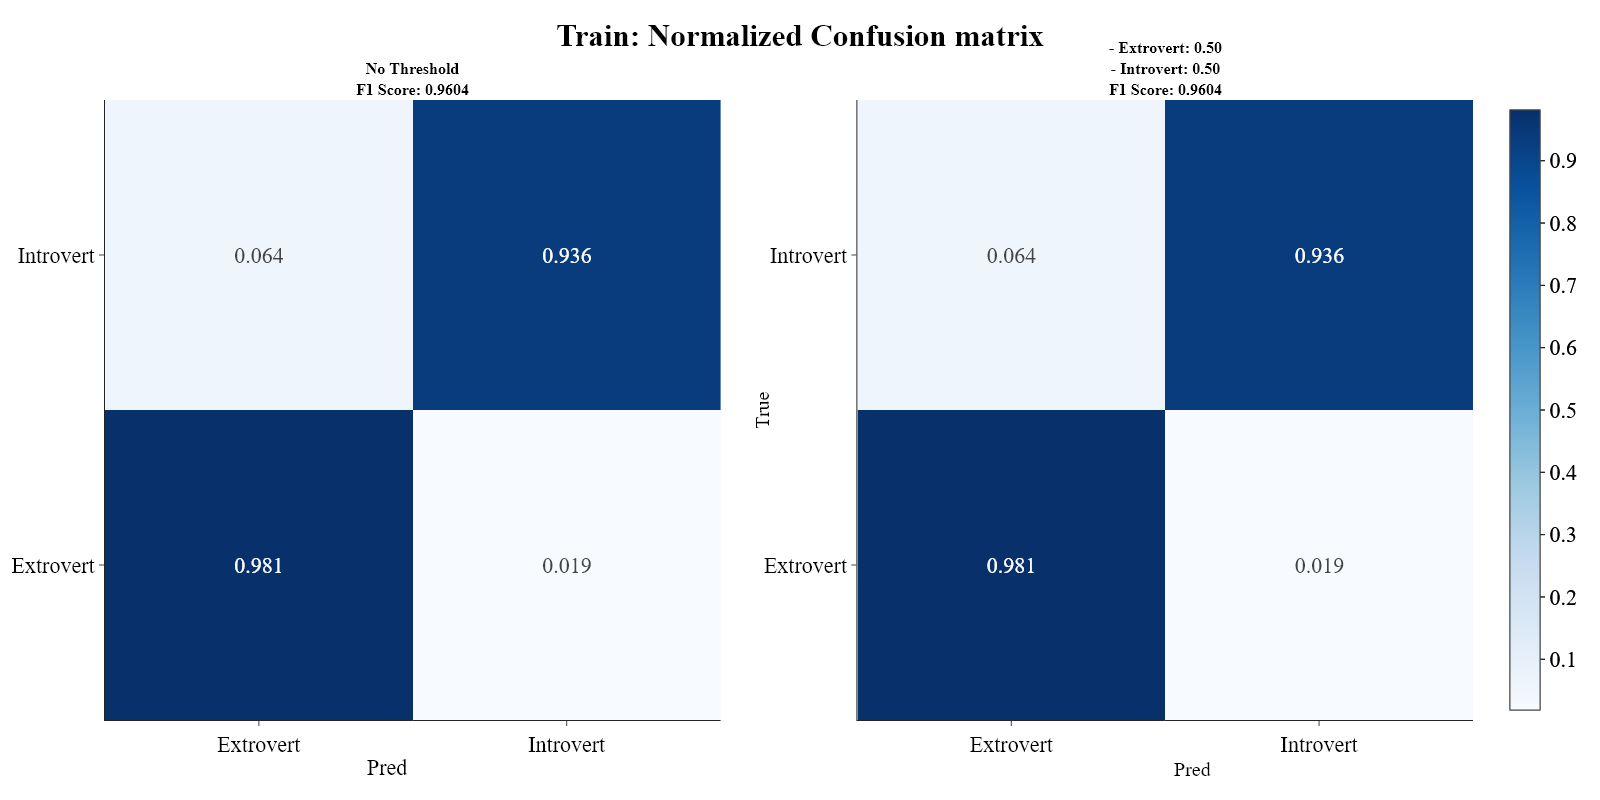

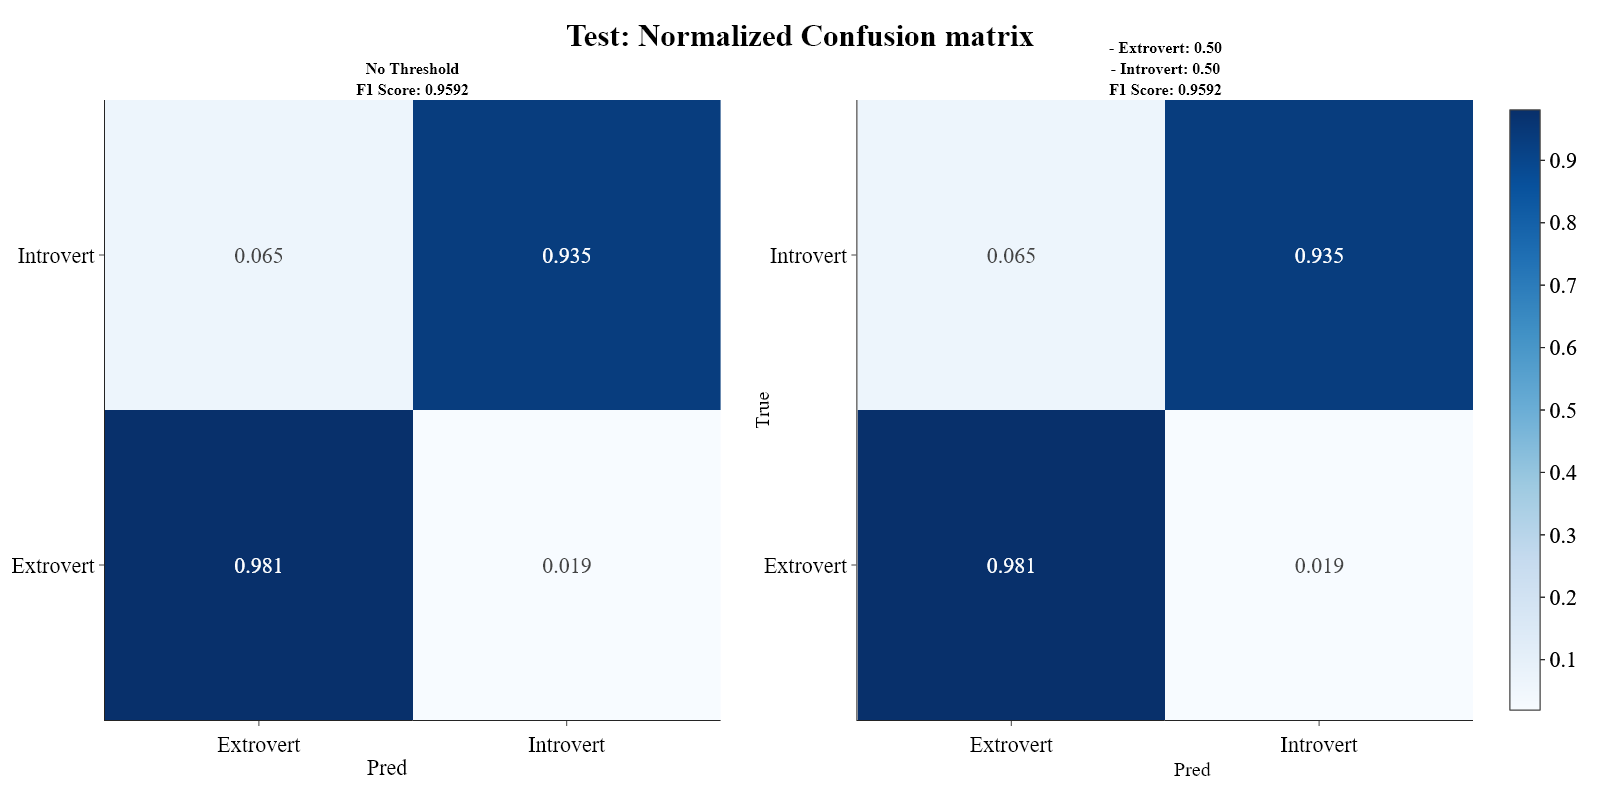

In [99]:
plots.subplot_multilabel_conf_matrix(y_train_labels, y_train_prob, cutoffs=cutoff_tuner.best_cutoffs, id2label=id2label, normalize=True, dataset="Train")
plots.subplot_multilabel_conf_matrix(y_test_labels, y_test_prob, cutoffs=cutoff_tuner.best_cutoffs, id2label=id2label, normalize=True, dataset="Test")

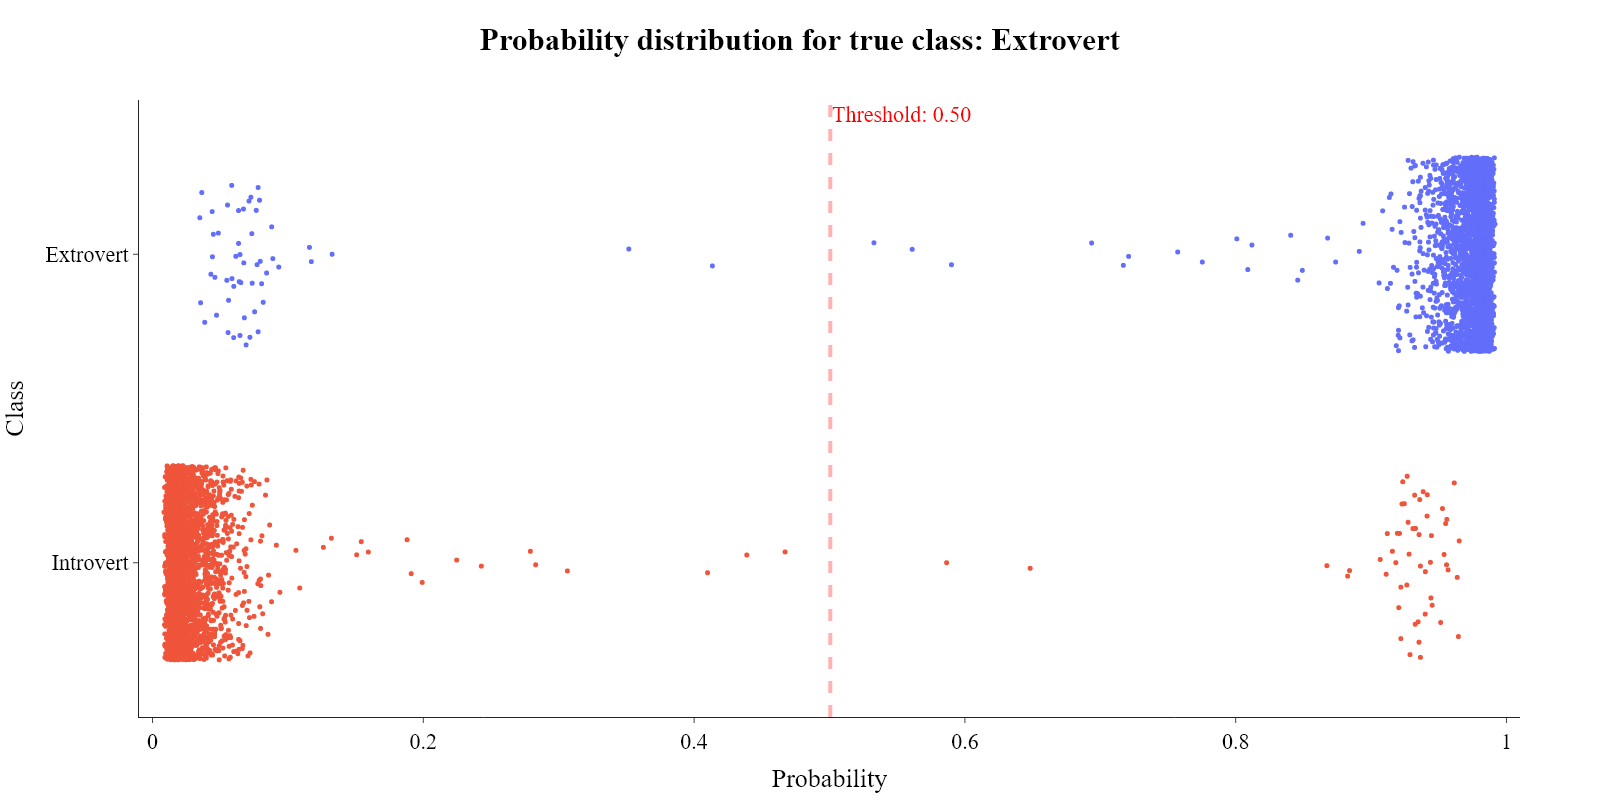

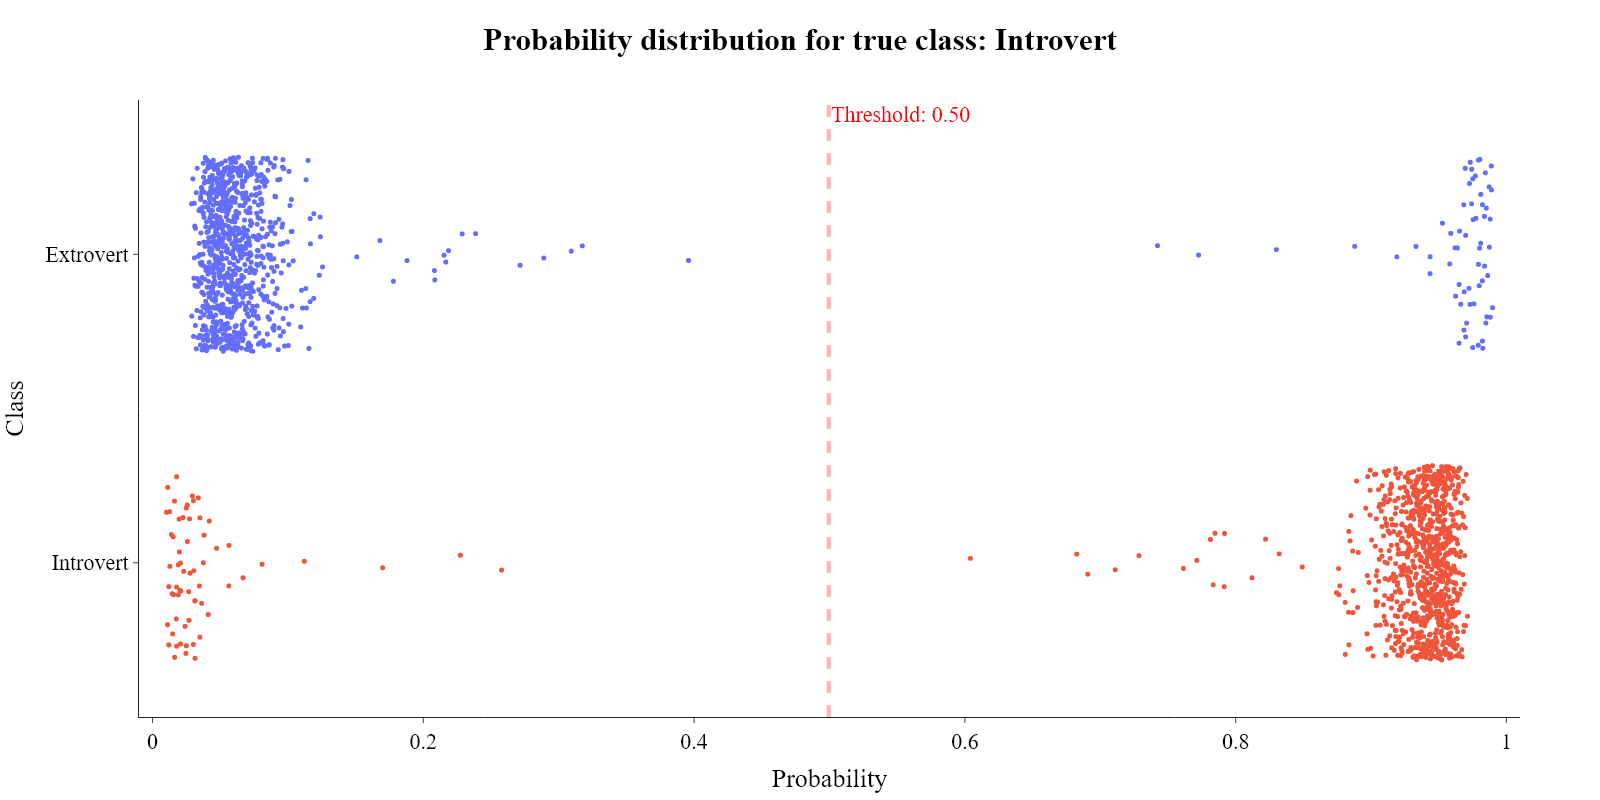

In [100]:
plots.plot_probabilities_per_class(y_true=y_test_labels, probabilities=y_test_prob, labels=label2id.keys(), cutoffs=cutoff_tuner.best_cutoffs)

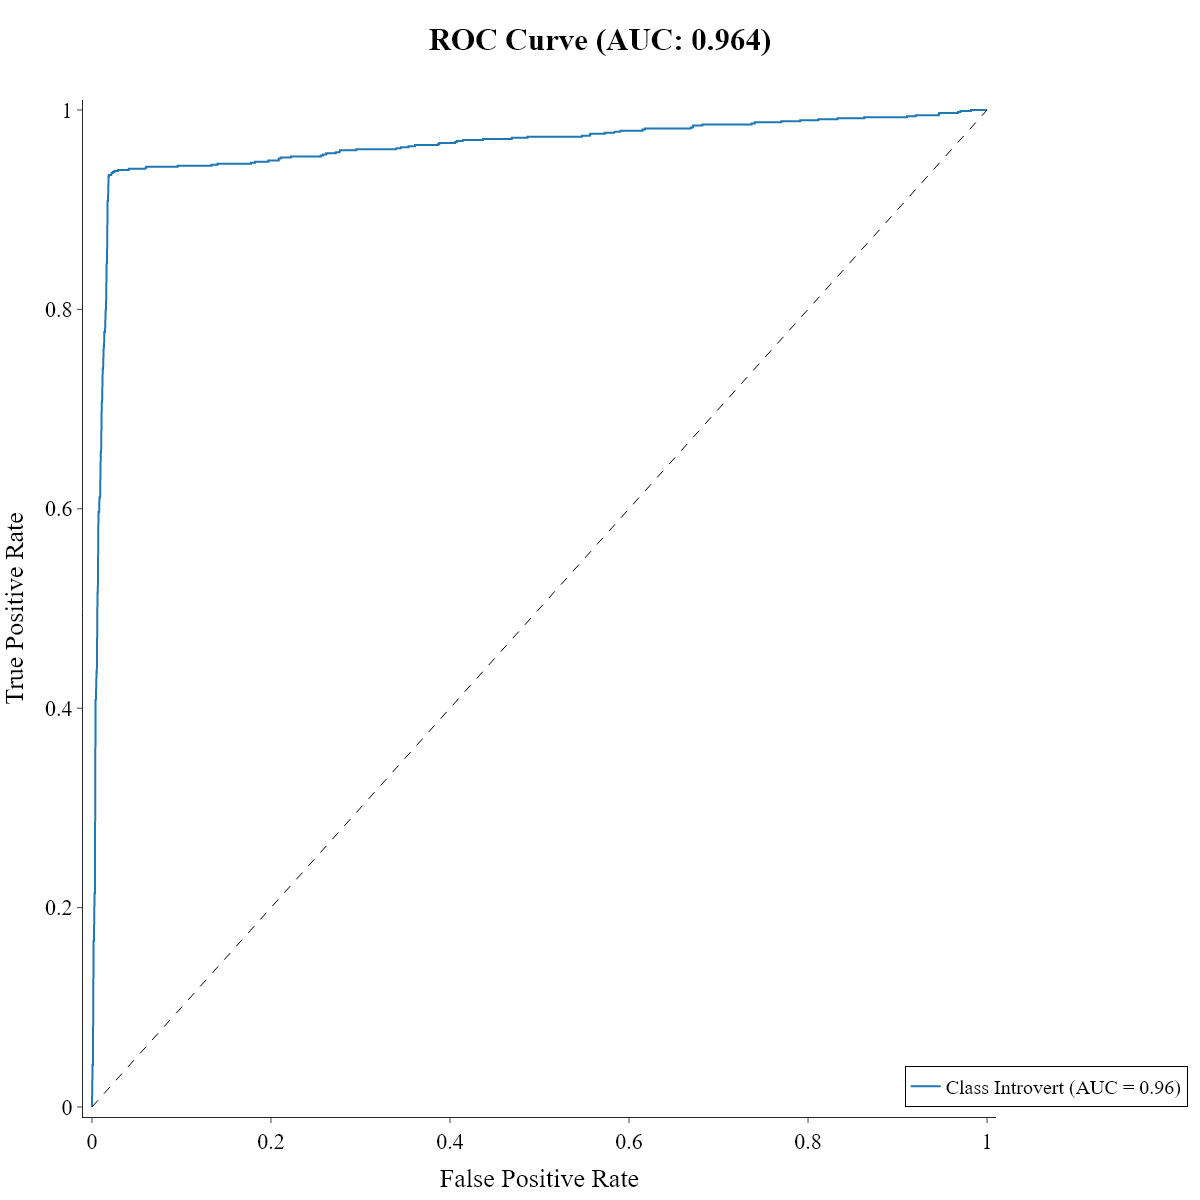

In [101]:
plots.roc_auc_multiclass(y_true=y_test_labels, probabilities=y_test_prob, labels=list(label2id.keys()))

# Final submission

In [107]:
submission = pd.read_csv("input/sample_submission.csv")
if final_model.__class__.__name__ == "OOFEnsembleModel":
    y_proba = final_model.fit(train_data[independent_features], train_data[target_feature], X_test=test_data[independent_features])
    y_pred_no_cutoffs = np.argmax(y_proba, axis=1)
    y_pred = np.argmax(y_proba / cutoffs, axis=1)
    changed_predictions = np.where(y_pred_no_cutoffs != y_pred)[0]
    print(f"Number of changed predictions due to cutoffs: {len(changed_predictions)}")
    print("Changed predictions (index, original, new):")
    for idx in changed_predictions:
        print(f"Index: {idx}, Original: {id2label[y_pred_no_cutoffs[idx]]}, New: {id2label[y_pred[idx]]}, Probabilities: {y_proba[idx]}")
    submission[target_feature] = y_pred
else:
    submission[target_feature] = predict_with_cutoffs(final_model, cutoffs, test_data[independent_features])
submission[target_feature] = submission[target_feature].map(id2label)
submission.to_csv("submission.csv", index=False)
submission.head()

Training folds: 100%|██████████| 50/50 [08:31<00:00, 10.22s/it]

Number of changed predictions due to cutoffs: 0
Changed predictions (index, original, new):


id Personality
0  18524   Extrovert
1  18525   Introvert
2  18526   Extrovert
3  18527   Extrovert
4  18528   Introvert